In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.original_models as original_models
import models.models_3d_atomics_on_variate_to_concepts as new_models
from vasopressor.preprocess_helpers import load_and_create_MIMIC_dataloader
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_selection, get_top_features_per_concept

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:6


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [4]:
def initializeModel(n_concepts, static_dim, changing_dim, seq_len, output_dim, use_summaries = True, use_indicators = True, use_only_last_timestep = False, use_fixes = False, use_grad_norm = False, top_k=''):
    model = original_models.CBM(static_dim = static_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                use_indicators = use_indicators,
                                use_fixes = use_fixes,
                                use_only_last_timestep = use_only_last_timestep,
                                use_grad_norm = use_grad_norm,
                                noise_std = False,
                                use_multiplicative_interactions = False,
                                use_summaries = use_summaries,
                                opt_lr = 1e-3,
                                opt_weight_decay = 1e-5,
                                l1_lambda=1e-3,
                                cos_sim_lambda=1e-2,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, static_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics = True, use_summaries = True, use_indicators = True, use_fixes = False, use_grad_norm = False, top_k=''):
    model = new_models.CBM(static_dim = static_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            use_fixes = use_fixes,
                            use_grad_norm = use_grad_norm,
                            noise_std = False,
                            use_summaries = use_summaries,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-5,
                            l1_lambda=1e-3,
                            cos_sim_lambda=1e-2,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model


In [5]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

seq_len = seq_len
changing_dim = len(changing_vars)
static_dim = len(static_names)

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 8 6


## Original

In [6]:
config_original = {
    "n_concepts": [4, 20],
    "use_summaries": [True, False],
    # "use_indicators": [True, False],
    # "use_fixes": [False, True],
    # "use_only_last_timestep": [True, False],
    # "use_grad_norm": [False, "FULL", "COMPONENT_WISE"],
}

all_config_permutations_og = list(product(*config_original.values()))
all_config_permutations_og = [dict(zip(config_original.keys(), permutation)) for permutation in all_config_permutations_og]
print(len(all_config_permutations_og))
# all_config_permutations_og

4


In [7]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [8]:
histories_original = []

for random_seed in range(3):
    set_seed(random_seed)
    
    for i, config in enumerate(all_config_permutations_og):
        print(i, config)
        
        train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)
        
        model = initializeModel(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
        model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)
        
        model.eval()
        with torch.inference_mode():
            for batch in test_loader:
                *data, y = extract_to(batch, device)
                probs = model(*data)
                
                auc = auroc_metric(probs, y).item()
                acc = accuracy_metric(probs, y).item()
                f1 = f1_metric(probs, y).item()
                # conf_matrix(probs, yb)
            auc = auroc_metric.compute().item()
            acc = accuracy_metric.compute().item()
            f1 = f1_metric.compute().item()
            # conf_matrix.plot()
            # plt.show()
            auroc_metric.reset()
            accuracy_metric.reset()
            # conf_matrix.reset()
            f1_metric.reset()
        
        history = ["original", i, model.val_losses[-1], auc, acc, f1]
        print(history)
        histories_original.append(np.array(history))
        
        # plot_losses(model.train_losses, model.val_losses)
        del model
        gc.collect()
        torch.cuda.empty_cache()
    
histories_original = np.array(histories_original)
histories_original.shape


0 {'n_concepts': 4, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_4_use_summaries_True_seed_0.pt
['original', 0, 0.5099252462387085, 0.9228818416595459, 0.8519821763038635, 0.8582929372787476]


1 {'n_concepts': 4, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_4_use_summaries_False_seed_0.pt
['original', 1, 0.5153680443763733, 0.9210718870162964, 0.848206639289856, 0.8553438782691956]
2 {'n_concepts': 20, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_20_use_summaries_True_seed_0.pt
['original', 2, 0.5226908922195435, 0.9224478006362915, 0.8502659797668457, 0.8580262064933777]
3 {'n_concepts': 20, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_20_use_summaries_False_seed_0.pt
['original', 3, 0.5273461937904358, 0.9228963255882263, 0.851896345615387, 0.8584781885147095]
0 {'n_concepts': 4, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_4_use_summaries_True_seed_1.pt
['original', 0, 0.525508463382721, 0.9068102240562439, 0.8282992839813232, 0.8375415802001953]
1 {'n_concepts': 4, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_4_use_summaries_False_seed_1.pt
['original', 1, 0.525052011013031, 0.9157637357711792, 0.8391110301017761, 0.8466759324073792]
2 {'n_concepts': 20, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_20_use_summaries_True_seed_1.pt
['original', 2, 0.5398592352867126, 0.914946436882019, 0.8368800282478333, 0.8451071381568909]
3 {'n_concepts': 20, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_20_use_summaries_False_seed_1.pt
['original', 3, 0.5345608592033386, 0.9128884077072144, 0.8366225957870483, 0.8440366983413696]
0 {'n_concepts': 4, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_4_use_summaries_True_seed_2.pt
['original', 0, 0.5169414281845093, 0.9158755540847778, 0.8373090624809265, 0.8451486229896545]
1 {'n_concepts': 4, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_4_use_summaries_False_seed_2.pt
['original', 1, 0.5142337083816528, 0.9196872115135193, 0.8475201725959778, 0.8544278144836426]
2 {'n_concepts': 20, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_20_use_summaries_True_seed_2.pt
['original', 2, 0.5280585289001465, 0.9210582971572876, 0.8469195365905762, 0.8542007207870483]
3 {'n_concepts': 20, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c_20_use_summaries_False_seed_2.pt
['original', 3, 0.5298969745635986, 0.91797935962677, 0.8438304662704468, 0.8510638475418091]


(12, 6)

In [9]:
# plot
# plot_metrics(histories_original, n_concepts_list)


## Atomics

In [10]:
config_atomics = {
    "n_atomics": [10, 30], # 30
    "n_concepts": [4, 20], # 20
    "use_summaries_for_atomics": [True, False],
    "use_summaries": [True, False],
    # "use_indicators": [True, False],
    # "use_fixes": [False, True],
    # "use_grad_norm": [False, "FULL", "COMPONENT_WISE"],
}

all_config_permutations_atomics = list(product(*config_atomics.values()))
all_config_permutations_atomics = [dict(zip(config_atomics.keys(), permutation)) for permutation in all_config_permutations_atomics]
print(len(all_config_permutations_atomics))
# all_config_permutations_atomics

16


In [11]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [12]:
history_atomics = []

for random_seed in range(3):
    set_seed(random_seed)
        
    for i, config in enumerate(all_config_permutations_atomics):
        print(i, config)
        
        train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)
        
        model = initializeModel_with_atomics(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
        model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)
        
        model.eval()
        with torch.inference_mode():
            for batch in test_loader:
                X_time, X_ind, X_static, y = extract_to(batch, device)
                probs = model(X_time, X_ind, X_static)
                
                auc = auroc_metric(probs, y).item()
                acc = accuracy_metric(probs, y).item()
                f1 = f1_metric(probs, y).item()
                # conf_matrix(probs, yb)
            auc = auroc_metric.compute().item()
            acc = accuracy_metric.compute().item()
            f1 = f1_metric.compute().item()
            # conf_matrix.plot()
            # plt.show()
            auroc_metric.reset()
            accuracy_metric.reset()
            # conf_matrix.reset()
            f1_metric.reset()

        history = ["atomics", i, model.val_losses[-1], auc, acc, f1]
        print(history)
        history_atomics.append(np.array(history))
        
        # plot_losses(model.train_losses, model.val_losses)
        del model
        gc.collect()
        torch.cuda.empty_cache()

    
history_atomics = np.array(history_atomics)
history_atomics.shape


0 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_True_use_summaries_True_seed_0.pt
['atomics', 0, 0.5247036218643188, 0.9216699600219727, 0.8471769094467163, 0.8543863892555237]
1 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_True_use_summaries_False_seed_0.pt


['atomics', 1, 0.5211860537528992, 0.9202490448951721, 0.847005307674408, 0.8547927141189575]
2 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_False_use_summaries_True_seed_0.pt
['atomics', 2, 0.5715287327766418, 0.907244086265564, 0.8533550500869751, 0.8590747714042664]
3 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_False_use_summaries_False_seed_0.pt
['atomics', 3, 0.5278500914573669, 0.9162989854812622, 0.8429723978042603, 0.8507341146469116]
4 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_True_use_summaries_True_seed_0.pt
['atomics', 4, 0.5171717405319214, 0.9179030656814575, 0.8422001004219055, 0.8500856161117554]
5 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_True_use_summaries_False_seed_0.pt
['atomics', 5, 0.5301887392997742, 0.9200332164764404, 0.8455466032028198, 0.8527727723121643]
6 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_False_use_summaries_True_seed_0.pt
['atomics', 6, 0.5773522853851318, 0.9053027033805847, 0.8497511744499207, 0.8553012013435364]
7 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_False_use_summaries_False_seed_0.pt
['atomics', 7, 0.576684832572937, 0.904255211353302, 0.8455466032028198, 0.8483060598373413]
8 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_True_use_summaries_True_seed_0.pt
['atomics', 8, 0.5214222073554993, 0.9230425357818604, 0.8453750014305115, 0.8531855940818787]
9 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_True_use_summaries_False_seed_0.pt
['atomics', 9, 0.6285886764526367, 0.9203402400016785, 0.8458040356636047, 0.8529580235481262]
10 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_False_use_summaries_True_seed_0.pt
['atomics', 10, 0.8069815039634705, 0.9052904844284058, 0.8598764538764954, 0.8637463450431824]
11 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_False_use_summaries_False_seed_0.pt
['atomics', 11, 0.772754430770874, 0.916397213935852, 0.843058168888092, 0.850632905960083]
12 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_True_use_summaries_True_seed_0.pt
['atomics', 12, 0.5271223783493042, 0.9218804836273193, 0.8477776050567627, 0.8551836609840393]
13 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_True_use_summaries_False_seed_0.pt
['atomics', 13, 0.6525972485542297, 0.9151075482368469, 0.8435730338096619, 0.8510012030601501]
14 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_False_use_summaries_True_seed_0.pt
['atomics', 14, 0.8372089266777039, 0.9061281085014343, 0.8549854159355164, 0.8606300354003906]
15 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_False_use_summaries_False_seed_0.pt
['atomics', 15, 0.7924590110778809, 0.91808021068573, 0.8489788770675659, 0.8558086156845093]
0 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_True_use_summaries_True_seed_1.pt
['atomics', 0, 0.5313735008239746, 0.9138913750648499, 0.8373948931694031, 0.8451417684555054]
1 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_True_use_summaries_False_seed_1.pt
['atomics', 1, 0.5405574440956116, 0.9112812280654907, 0.8331903219223022, 0.8418740630149841]
2 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_False_use_summaries_True_seed_1.pt
['atomics', 2, 0.569831371307373, 0.9052372574806213, 0.8441736698150635, 0.8506824374198914]
3 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_False_use_summaries_False_seed_1.pt
['atomics', 3, 0.5396718978881836, 0.9094827771186829, 0.8337909579277039, 0.8417871594429016]
4 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_True_use_summaries_True_seed_1.pt
['atomics', 4, 0.54523104429245, 0.9145469665527344, 0.8366225957870483, 0.844748854637146]
5 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_True_use_summaries_False_seed_1.pt
['atomics', 5, 0.5405238270759583, 0.9128764867782593, 0.842114269733429, 0.8490318059921265]
6 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_False_use_summaries_True_seed_1.pt
['atomics', 6, 0.5861489772796631, 0.9043070077896118, 0.8512098789215088, 0.8564807176589966]
7 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_False_use_summaries_False_seed_1.pt
['atomics', 7, 0.5891985893249512, 0.8988966941833496, 0.8382529616355896, 0.840618908405304]
8 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_True_use_summaries_True_seed_1.pt
['atomics', 8, 0.543306827545166, 0.9186181426048279, 0.8451175689697266, 0.8521824479103088]
9 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_True_use_summaries_False_seed_1.pt
['atomics', 9, 0.6473478078842163, 0.9129935503005981, 0.8366225957870483, 0.8449006080627441]
10 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_False_use_summaries_True_seed_1.pt
['atomics', 10, 0.8450278043746948, 0.9053313136100769, 0.851638913154602, 0.8563356995582581]
11 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_False_use_summaries_False_seed_1.pt
['atomics', 11, 0.7949323058128357, 0.908902645111084, 0.8355929255485535, 0.8434896469116211]
12 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_True_use_summaries_True_seed_1.pt
['atomics', 12, 0.5512114763259888, 0.9137128591537476, 0.8367942571640015, 0.8444808125495911]
13 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_True_use_summaries_False_seed_1.pt
['atomics', 13, 0.6577402353286743, 0.9118003249168396, 0.8340483903884888, 0.8424568176269531]
14 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_False_use_summaries_True_seed_1.pt
['atomics', 14, 0.8396431803703308, 0.9035500288009644, 0.8375664949417114, 0.8461601138114929]
15 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_False_use_summaries_False_seed_1.pt
['atomics', 15, 0.8012570142745972, 0.9104591012001038, 0.8392826318740845, 0.8471145033836365]
0 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_True_use_summaries_True_seed_2.pt
['atomics', 0, 0.5196355581283569, 0.9139346480369568, 0.8349922895431519, 0.8436458110809326]
1 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_True_use_summaries_False_seed_2.pt
['atomics', 1, 0.5243578553199768, 0.9138728380203247, 0.8366225957870483, 0.8455548286437988]
2 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_False_use_summaries_True_seed_2.pt
['atomics', 2, 0.5601916909217834, 0.9004248976707458, 0.8334477543830872, 0.8445085287094116]
3 {'n_atomics': 10, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_use_summaries_for_atomics_False_use_summaries_False_seed_2.pt
['atomics', 3, 0.570073664188385, 0.8939446210861206, 0.8359361886978149, 0.8385953307151794]
4 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_True_use_summaries_True_seed_2.pt
['atomics', 4, 0.5284987688064575, 0.9169973134994507, 0.838167130947113, 0.8465918302536011]
5 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_True_use_summaries_False_seed_2.pt
['atomics', 5, 0.543062686920166, 0.9119324684143066, 0.8382529616355896, 0.8467354774475098]
6 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_False_use_summaries_True_seed_2.pt
['atomics', 6, 0.5700291991233826, 0.9070079326629639, 0.8464046716690063, 0.853085994720459]
7 {'n_atomics': 10, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c20_use_summaries_for_atomics_False_use_summaries_False_seed_2.pt
['atomics', 7, 0.538367509841919, 0.9136692881584167, 0.8395400643348694, 0.8474714756011963]
8 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_True_use_summaries_True_seed_2.pt
['atomics', 8, 0.5265505313873291, 0.9155137538909912, 0.8371374607086182, 0.8463406562805176]
9 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_True_use_summaries_False_seed_2.pt
['atomics', 9, 0.6395105719566345, 0.9174073934555054, 0.839625895023346, 0.8475157022476196]
10 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_False_use_summaries_True_seed_2.pt
['atomics', 10, 0.8301715850830078, 0.9065696001052856, 0.8513814806938171, 0.8563847541809082]
11 {'n_atomics': 30, 'n_concepts': 4, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c4_use_summaries_for_atomics_False_use_summaries_False_seed_2.pt
['atomics', 11, 0.7746853232383728, 0.9156697988510132, 0.8402265310287476, 0.8480991721153259]
12 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_True_use_summaries_True_seed_2.pt
['atomics', 12, 0.5371266007423401, 0.9146530628204346, 0.8339625597000122, 0.8430529832839966]
13 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': True, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_True_use_summaries_False_seed_2.pt
['atomics', 13, 0.7328348159790039, 0.9020612239837646, 0.8625364899635315, 0.8625364899635315]
14 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_False_use_summaries_True_seed_2.pt
['atomics', 14, 0.8332680463790894, 0.9056761860847473, 0.8576454520225525, 0.8616462349891663]
15 {'n_atomics': 30, 'n_concepts': 20, 'use_summaries_for_atomics': False, 'use_summaries': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a30_c20_use_summaries_for_atomics_False_use_summaries_False_seed_2.pt
['atomics', 15, 0.791214644908905, 0.9178826808929443, 0.846233069896698, 0.8531147837638855]


(48, 6)

In [13]:
columns = ["type", "config", "val_loss", "auc", "acc", "f1"]
dtypes = {'type': str, 'config': int, 'val_loss': float, 'auc': float, 'acc': float, 'f1': float}

df_og = pd.DataFrame(histories_original, columns=columns).astype(dtypes)
df_og = df_og.join(pd.DataFrame(all_config_permutations_og), on="config", how="left")

df_atomics = pd.DataFrame(history_atomics, columns=columns).astype(dtypes)
df_atomics = df_atomics.join(pd.DataFrame(all_config_permutations_atomics), on="config", how="left")

result_df = pd.concat([df_og, df_atomics], ignore_index=True)
# result_df


In [14]:
for col in result_df.columns[3:6]:
    baseline = result_df[(result_df['type'] == 'original') & (result_df['config'] == 0)][col].values[0]
    print(col, baseline)
    result_df[f'{col}_abs_imp'] = result_df[col] - baseline
    # result_df[f'{col}_rel_imp'] = result_df[f'{col}_abs_imp'] / baseline
# result_df

auc 0.9228818416595459
acc 0.8519821763038635
f1 0.8582929372787476


In [15]:
pd.set_option('display.max_rows', 20)
result_df.sort_values(by='acc', ascending=False)
# atomics: atomics, concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics
# original: concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep


,type,config,val_loss,auc,acc,f1,n_concepts,use_summaries,n_atomics,use_summaries_for_atomics,auc_abs_imp,acc_abs_imp,f1_abs_imp
57,atomics,13,0.732835,0.902061,0.862536,0.862536,20,False,30.0,True,-0.020821,0.010554,0.004244
22,atomics,10,0.806982,0.905290,0.859876,0.863746,4,True,30.0,False,-0.017591,0.007894,0.005453
58,atomics,14,0.833268,0.905676,0.857645,0.861646,20,True,30.0,False,-0.017206,0.005663,0.003353
26,atomics,14,0.837209,0.906128,0.854985,0.860630,20,True,30.0,False,-0.016754,0.003003,0.002337
14,atomics,2,0.571529,0.907244,0.853355,0.859075,4,True,10.0,False,-0.015638,0.001373,0.000782
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,atomics,12,0.537127,0.914653,0.833963,0.843053,20,True,30.0,True,-0.008229,-0.018020,-0.015240
31,atomics,3,0.539672,0.909483,0.833791,0.841787,4,False,10.0,False,-0.013399,-0.018191,-0.016506
46,atomics,2,0.560192,0.900425,0.833448,0.844509,4,True,10.0,False,-0.022457,-0.018534,-0.013784
29,atomics,1,0.540557,0.911281,0.833190,0.841874,4,False,10.0,True,-0.011601,-0.018792,-0.016419


In [16]:
for key in sorted(set(list(all_config_permutations_og[0].keys()) + list(all_config_permutations_atomics[0].keys()))):
    display(result_df.groupby(["use_summaries_for_atomics", key], dropna=False)[["auc", "acc", "f1"]].mean())

display(result_df.groupby("type")[["auc", "acc", "f1"]].mean())

auc       acc        f1
use_summaries_for_atomics n_atomics                              
NaN                       NaN        0.917859  0.843237  0.850695
False                     10.0       0.905506  0.842865  0.848887
                          30.0       0.909995  0.847206  0.853597
True                      10.0       0.915766  0.839940  0.847947
                          30.0       0.915594  0.842365  0.849650

auc       acc        f1
use_summaries_for_atomics n_concepts                              
NaN                       4           0.917015  0.842071  0.849572
                          20          0.918703  0.844402  0.851819
False                     4           0.907566  0.843788  0.850339
                          20          0.907935  0.846283  0.852145
True                      4           0.916901  0.840505  0.848540
                          20          0.914459  0.841800  0.849057

auc       acc        f1
use_summaries_for_atomics use_summaries                              
NaN                       False          0.918381  0.844531  0.851671
                          True           0.917337  0.841943  0.849720
False                     False          0.910328  0.840784  0.847148
                          True           0.905172  0.849286  0.855336
True                      False          0.914163  0.842079  0.849344
                          True           0.917197  0.840227  0.848252

,,auc,acc,f1
use_summaries_for_atomics,use_summaries_for_atomics,,,
NaN,NaN,0.917859,0.843237,0.850695
False,False,0.907750,0.845035,0.851242
True,True,0.915680,0.841153,0.848798


,auc,acc,f1
type,,,
atomics,0.911715,0.843094,0.850020
original,0.917859,0.843237,0.850695


## Optimization

In [6]:
# feature weights
config_original = {
    "n_concepts": 4,
    "use_indicators": True,
    "use_fixes": False,
    "use_only_last_timestep": True,
    "use_grad_norm": False,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

model = initializeModel(**config_original, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_original), max_epochs=10000)

for batch in test_loader:
    *data, y = extract_to(batch, device)
    probs = model(*data)

    auc = auroc_metric(probs, y).item()
    acc = accuracy_metric(probs, y).item()
    f1 = f1_metric(probs, y).item()

auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
f1 = f1_metric.compute().item()

auroc_metric.reset()
accuracy_metric.reset()
f1_metric.reset()

print("AUC", auc)
print("ACC", acc)
print("F1", f1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original/vaso_c4_indTrue_fixesFalse_onlylasttimestepTrue_output_dim2_gradnormFalse.pt
AUC 0.9138001799583435
ACC 0.8404839634895325
F1 0.8480340242385864


In [7]:
abs_bottleneck_weights = model.bottleneck.weight.cpu().detach().numpy()
abs_bottleneck_weights = np.abs(abs_bottleneck_weights)
abs_bottleneck_weights.shape


(4, 386)

In [8]:
threshold = 1e-4  # Threshold value

# Iterate over each row (dimension)
for row_idx in range(abs_bottleneck_weights.shape[0]):
    # Select weights bigger than the threshold for the current row
    selected_weights = abs_bottleneck_weights[row_idx][abs_bottleneck_weights[row_idx] < threshold]
    
    # Print the selected weights for the current row
    print(f"Row {row_idx + 1}: Selected weights smaller than threshold ({threshold}):")
    # print(selected_weights)
    print(len(selected_weights))


Row 1: Selected weights smaller than threshold (0.0001):
18
Row 2: Selected weights smaller than threshold (0.0001):
48
Row 3: Selected weights smaller than threshold (0.0001):
26
Row 4: Selected weights smaller than threshold (0.0001):
23


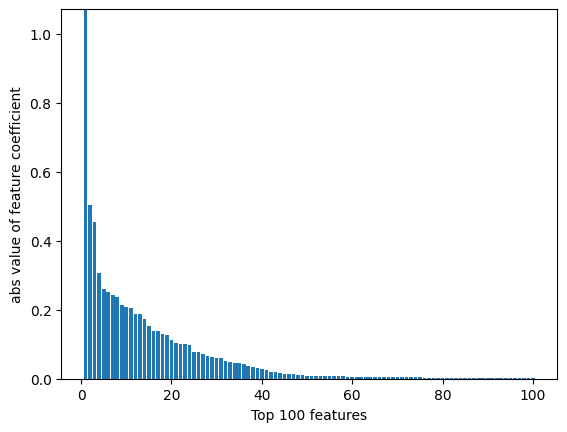

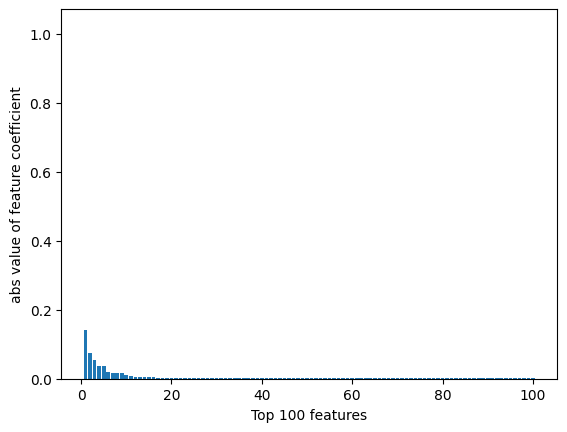

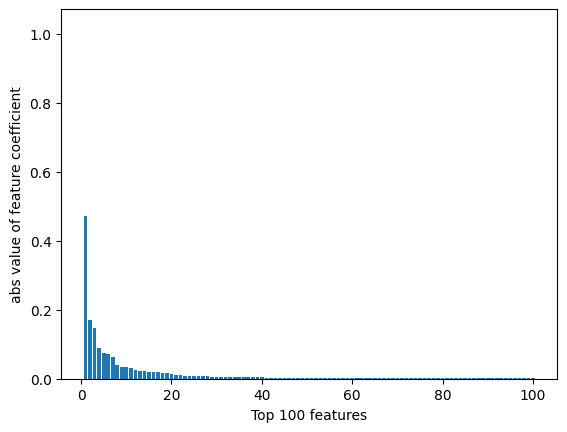

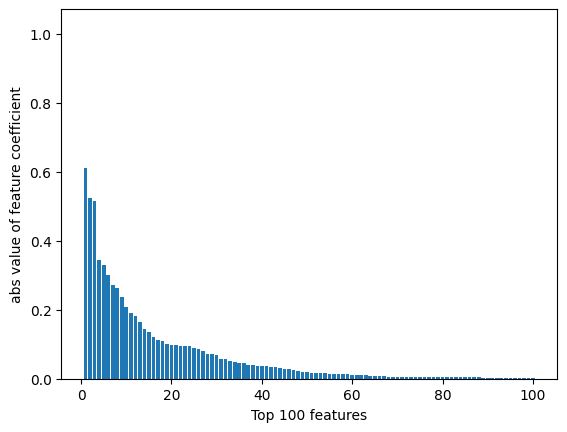

In [9]:
# visualize weight magnitudes
max_y = np.max(abs_bottleneck_weights)

for c in range(abs_bottleneck_weights.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-abs_bottleneck_weights[c])[:100]
    ax.bar(np.arange(1,101), abs_bottleneck_weights[c][inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    ax.set_ylim(0, max_y)
    plt.show()


In [10]:
top_k_inds = get_top_features_per_concept(model.bottleneck)
# top_k_inds
model.linear.weight

Found 4 Concepts
90th percentile per concept [6.4518924 0.6162137 1.6398425 6.4495716]
['Concept 0 len: 37', 'Concept 1 len: 141', 'Concept 2 len: 94', 'Concept 3 len: 45']


Parameter containing:
tensor([[-3.6567, -0.8923,  1.6247,  3.6836],
        [ 3.6758,  0.9358, -1.5211, -3.7086]], device='cuda:14',
       requires_grad=True)

In [ ]:
# write top k inds to csv
top_k_file = experiment_folder + "top-k/top_k_idx.csv"

directory = os.path.dirname(top_k_file)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(top_k_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [11]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               }

greedy_results = greedy_selection(model=model, layers_to_prune=[model.bottleneck], top_k_inds=[top_k_inds], val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
#greedy_results


  0%|          | 0/120 [00:00<?, ?it/s]

 48%|████▊     | 58/120 [2:59:08<3:14:17, 188.03s/it, Score=0.91795, acc=0.5, f1=0.667]

In [ ]:
greedy_results

,Score,Layer,Concept,Feature,acc,f1
0,0.904396,0,1,159,0.5,0.666667
1,0.910184,0,1,383,0.5,0.666667
2,0.912787,0,1,66,0.5,0.666667
3,0.914653,0,1,165,0.5,0.666667
4,0.916223,0,1,374,0.5,0.666667
5,0.916743,0,1,124,0.5,0.666667
6,0.917294,0,1,254,0.5,0.666667
7,0.917613,0,1,75,0.5,0.666667
8,0.917835,0,1,44,0.5,0.666667
9,0.917975,0,1,163,0.5,0.666667


In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

import csv
# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()

## Optimization Atomics

In [23]:
# feature weights
config_atomics = {
    "n_atomics": 10, # 30
    "n_concepts": 4, # 20
    "use_indicators": True,
    "use_fixes": False,
    "use_summaries_for_atomics": True,
    "use_grad_norm": False,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

model = initializeModel_with_atomics(**config_atomics, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_atomics), max_epochs=10000)

for batch in test_loader:
    *data, y = extract_to(batch, device)
    probs = model(*data)

    auc = auroc_metric(probs, y).item()
    acc = accuracy_metric(probs, y).item()
    f1 = f1_metric(probs, y).item()

auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
f1 = f1_metric.compute().item()

auroc_metric.reset()
accuracy_metric.reset()
f1_metric.reset()

print("AUC", auc)
print("ACC", acc)
print("F1", f1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/vaso_a10_c4_indTrue_fixesFalse_output_dim2_summariesTrue_gradnormFalse.pt
AUC 0.8733640909194946
ACC 0.8353354930877686
F1 0.8434875011444092


In [24]:
layers = [model.layer_time_to_atomics, model.layer_to_concepts]
top_k_inds = [get_top_features_per_concept(layer) for layer in layers]
# top_k_inds
model.layer_output.weight

Found 10 Concepts
90th percentile per concept [0.13360962 0.11618172 0.17461674 0.10974458 0.15019093 0.11730425
 4.1245832  0.11287732 0.11427169 0.78483105]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10', 'Concept 4 len: 10', 'Concept 5 len: 10', 'Concept 6 len: 10', 'Concept 7 len: 10', 'Concept 8 len: 10', 'Concept 9 len: 10']
Found 4 Concepts
90th percentile per concept [8.511244   0.13980736 0.14437436 0.14495519]
['Concept 0 len: 25', 'Concept 1 len: 108', 'Concept 2 len: 107', 'Concept 3 len: 106']


Parameter containing:
tensor([[ 7.6388, -0.9657, -0.8828, -0.0554],
        [-7.6021,  0.5786,  1.4751,  0.6264]], device='cuda:14',
       requires_grad=True)

In [25]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               }

greedy_results_atomics = greedy_selection(model=model, layers_to_prune=layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
greedy_results_atomics


  0%|          | 0/140 [00:00<?, ?it/s]

Layer 0 Concept 0 Feat 0 Score 0.8678364157676697
Layer 0 Concept 0 Feat 29 Score 0.8714650273323059
Layer 0 Concept 0 Feat 31 Score 0.8384684920310974
Layer 0 Concept 0 Feat 7 Score 0.8445621728897095
Layer 0 Concept 0 Feat 23 Score 0.851925790309906
Layer 0 Concept 0 Feat 1 Score 0.8597267270088196
Layer 0 Concept 0 Feat 10 Score 0.8625600337982178
Layer 0 Concept 0 Feat 9 Score 0.8625600337982178
Layer 0 Concept 0 Feat 26 Score 0.8635765910148621
Layer 0 Concept 0 Feat 12 Score 0.8577574491500854
Layer 0 Concept 1 Feat 5 Score 0.8765556812286377
Layer 0 Concept 1 Feat 29 Score 0.8520908951759338
Layer 0 Concept 1 Feat 0 Score 0.8648048043251038
Layer 0 Concept 1 Feat 4 Score 0.8601981997489929
Layer 0 Concept 1 Feat 7 Score 0.8625600337982178
Layer 0 Concept 1 Feat 26 Score 0.8625600337982178
Layer 0 Concept 1 Feat 1 Score 0.862647294998169
Layer 0 Concept 1 Feat 14 Score 0.8625600337982178
Layer 0 Concept 1 Feat 9 Score 0.8625600337982178
Layer 0 Concept 1 Feat 27 Score 0.862560033

  1%|          | 1/140 [03:40<8:30:13, 220.24s/it, Score=0.89100]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.871594250202179
Layer 0 Concept 0 Feat 29 Score 0.8782933354377747
Layer 0 Concept 0 Feat 31 Score 0.8893754482269287
Layer 0 Concept 0 Feat 7 Score 0.8899619579315186
Layer 0 Concept 0 Feat 23 Score 0.8904691338539124
Layer 0 Concept 0 Feat 1 Score 0.8916274905204773
Layer 0 Concept 0 Feat 10 Score 0.8906115889549255
Layer 0 Concept 0 Feat 9 Score 0.8909748196601868
Layer 0 Concept 0 Feat 26 Score 0.8919147253036499
Layer 0 Concept 0 Feat 12 Score 0.8896169662475586
Layer 0 Concept 1 Feat 5 Score 0.8799203634262085
Layer 0 Concept 1 Feat 29 Score 0.8684996366500854
Layer 0 Concept 1 Feat 0 Score 0.8911904692649841
Layer 0 Concept 1 Feat 4 Score 0.8917168974876404
Layer 0 Concept 1 Feat 7 Score 0.8913741111755371
Layer 0 Concept 1 Feat 26 Score 0.891386866569519
Layer 0 Concept 1 Feat 1 Score 0.8915248513221741
Layer 0 Concept 1 Feat 14 Score 0.8916915059089661
Layer 0 Concept 1 Feat 9 Score 0.8913118243217468
Layer 0 Concept 1 Fe

  1%|▏         | 2/140 [07:18<8:23:53, 219.08s/it, Score=0.90177]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8893194794654846
Layer 0 Concept 0 Feat 29 Score 0.8943280577659607
Layer 0 Concept 0 Feat 31 Score 0.9002515077590942
Layer 0 Concept 0 Feat 7 Score 0.9024721384048462
Layer 0 Concept 0 Feat 23 Score 0.9015669822692871
Layer 0 Concept 0 Feat 1 Score 0.9016844630241394
Layer 0 Concept 0 Feat 10 Score 0.9019829034805298
Layer 0 Concept 0 Feat 9 Score 0.9015662670135498
Layer 0 Concept 0 Feat 26 Score 0.9021711945533752
Layer 0 Concept 0 Feat 12 Score 0.901076078414917
Layer 0 Concept 1 Feat 5 Score 0.8962643146514893
Layer 0 Concept 1 Feat 29 Score 0.8929449915885925
Layer 0 Concept 1 Feat 0 Score 0.9017521739006042
Layer 0 Concept 1 Feat 4 Score 0.9023078083992004
Layer 0 Concept 1 Feat 7 Score 0.9019733667373657
Layer 0 Concept 1 Feat 26 Score 0.9016780853271484
Layer 0 Concept 1 Feat 1 Score 0.9019405245780945
Layer 0 Concept 1 Feat 14 Score 0.9008896946907043
Layer 0 Concept 1 Feat 9 Score 0.9017236232757568
Layer 0 Concept 1 F

  2%|▏         | 3/140 [10:55<8:18:10, 218.18s/it, Score=0.90574]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8902274370193481
Layer 0 Concept 0 Feat 29 Score 0.8954589366912842
Layer 0 Concept 0 Feat 31 Score 0.9044406414031982
Layer 0 Concept 0 Feat 7 Score 0.9059115052223206
Layer 0 Concept 0 Feat 23 Score 0.9056036472320557
Layer 0 Concept 0 Feat 1 Score 0.9061321020126343
Layer 0 Concept 0 Feat 10 Score 0.905688464641571
Layer 0 Concept 0 Feat 9 Score 0.9053164124488831
Layer 0 Concept 0 Feat 26 Score 0.9057601690292358
Layer 0 Concept 0 Feat 12 Score 0.9045958518981934
Layer 0 Concept 1 Feat 5 Score 0.897384524345398
Layer 0 Concept 1 Feat 29 Score 0.8950619101524353
Layer 0 Concept 1 Feat 0 Score 0.9056716561317444
Layer 0 Concept 1 Feat 4 Score 0.9058112502098083
Layer 0 Concept 1 Feat 7 Score 0.9059590101242065
Layer 0 Concept 1 Feat 26 Score 0.9056916832923889
Layer 0 Concept 1 Feat 1 Score 0.9056012034416199
Layer 0 Concept 1 Feat 14 Score 0.90544193983078
Layer 0 Concept 1 Feat 9 Score 0.9052674770355225
Layer 0 Concept 1 Feat

  3%|▎         | 4/140 [14:33<8:14:08, 218.01s/it, Score=0.90630]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906296491622925
Layer 0 Concept 0 Feat 29 Score 0.896074652671814
Layer 0 Concept 0 Feat 31 Score 0.905556857585907
Layer 0 Concept 0 Feat 7 Score 0.9062396287918091
Layer 0 Concept 0 Feat 23 Score 0.9059172868728638
Layer 0 Concept 0 Feat 1 Score 0.906425416469574
Layer 0 Concept 0 Feat 10 Score 0.9062634110450745
Layer 0 Concept 0 Feat 9 Score 0.9061611294746399
Layer 0 Concept 0 Feat 26 Score 0.9064205288887024
Layer 0 Concept 0 Feat 12 Score 0.9050079584121704
Layer 0 Concept 1 Feat 5 Score 0.8977743983268738
Layer 0 Concept 1 Feat 29 Score 0.8951225280761719
Layer 0 Concept 1 Feat 0 Score 0.90629643201828
Layer 0 Concept 1 Feat 4 Score 0.9063563346862793
Layer 0 Concept 1 Feat 7 Score 0.9064415693283081
Layer 0 Concept 1 Feat 26 Score 0.9063149690628052
Layer 0 Concept 1 Feat 1 Score 0.9064004421234131
Layer 0 Concept 1 Feat 14 Score 0.9063018560409546
Layer 0 Concept 1 Feat 9 Score 0.9063368439674377
Layer 0 Concept 1 Feat 

  4%|▎         | 5/140 [18:11<8:10:13, 217.88s/it, Score=0.90646]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906294107437134
Layer 0 Concept 0 Feat 29 Score 0.8961063623428345
Layer 0 Concept 0 Feat 31 Score 0.9056953191757202
Layer 0 Concept 0 Feat 7 Score 0.9064753651618958
Layer 0 Concept 0 Feat 23 Score 0.9063004851341248
Layer 0 Concept 0 Feat 1 Score 0.906603991985321
Layer 0 Concept 0 Feat 10 Score 0.9065099358558655
Layer 0 Concept 0 Feat 9 Score 0.9063467979431152
Layer 0 Concept 0 Feat 26 Score 0.9066134691238403
Layer 0 Concept 0 Feat 12 Score 0.905238151550293
Layer 0 Concept 1 Feat 5 Score 0.8978039026260376
Layer 0 Concept 1 Feat 29 Score 0.895190954208374
Layer 0 Concept 1 Feat 0 Score 0.9064593315124512
Layer 0 Concept 1 Feat 4 Score 0.9063798189163208
Layer 0 Concept 1 Feat 7 Score 0.9062128663063049
Layer 0 Concept 1 Feat 26 Score 0.9063912034034729
Layer 0 Concept 1 Feat 1 Score 0.9064220190048218
Layer 0 Concept 1 Feat 14 Score 0.9062219858169556
Layer 0 Concept 1 Feat 9 Score 0.9065324664115906
Layer 0 Concept 2 Fea

  4%|▍         | 6/140 [21:48<8:06:01, 217.62s/it, Score=0.90661]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906530141830444
Layer 0 Concept 0 Feat 29 Score 0.8961634635925293
Layer 0 Concept 0 Feat 31 Score 0.9055763483047485
Layer 0 Concept 0 Feat 7 Score 0.9065374135971069
Layer 0 Concept 0 Feat 23 Score 0.9063901901245117
Layer 0 Concept 0 Feat 1 Score 0.9067229628562927
Layer 0 Concept 0 Feat 10 Score 0.9066731929779053
Layer 0 Concept 0 Feat 9 Score 0.906502902507782
Layer 0 Concept 0 Feat 12 Score 0.9055200219154358
Layer 0 Concept 1 Feat 5 Score 0.8977677822113037
Layer 0 Concept 1 Feat 29 Score 0.8952161073684692
Layer 0 Concept 1 Feat 0 Score 0.9065628051757812
Layer 0 Concept 1 Feat 4 Score 0.9065440893173218
Layer 0 Concept 1 Feat 7 Score 0.9064954519271851
Layer 0 Concept 1 Feat 26 Score 0.906586229801178
Layer 0 Concept 1 Feat 1 Score 0.9066128730773926
Layer 0 Concept 1 Feat 14 Score 0.906355082988739
Layer 0 Concept 1 Feat 9 Score 0.9067317247390747
Layer 0 Concept 2 Feat 29 Score 0.8826993703842163
Layer 0 Concept 2 Fea

  5%|▌         | 7/140 [25:24<8:01:50, 217.37s/it, Score=0.90673]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.890652060508728
Layer 0 Concept 0 Feat 29 Score 0.8961920738220215
Layer 0 Concept 0 Feat 31 Score 0.9057052731513977
Layer 0 Concept 0 Feat 7 Score 0.9065228700637817
Layer 0 Concept 0 Feat 23 Score 0.9063804745674133
Layer 0 Concept 0 Feat 1 Score 0.9066526889801025
Layer 0 Concept 0 Feat 10 Score 0.9067620038986206
Layer 0 Concept 0 Feat 9 Score 0.9065572023391724
Layer 0 Concept 0 Feat 12 Score 0.9055600762367249
Layer 0 Concept 1 Feat 5 Score 0.8977863192558289
Layer 0 Concept 1 Feat 29 Score 0.8952358961105347
Layer 0 Concept 1 Feat 0 Score 0.9065632224082947
Layer 0 Concept 1 Feat 4 Score 0.9064323902130127
Layer 0 Concept 1 Feat 7 Score 0.9064557552337646
Layer 0 Concept 1 Feat 26 Score 0.9067891836166382
Layer 0 Concept 1 Feat 1 Score 0.9066541194915771
Layer 0 Concept 1 Feat 14 Score 0.9063533544540405
Layer 0 Concept 2 Feat 29 Score 0.8827062845230103
Layer 0 Concept 2 Feat 2 Score 0.8891383409500122
Layer 0 Concept 2 F

  6%|▌         | 8/140 [29:02<7:58:12, 217.37s/it, Score=0.90679]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906475901603699
Layer 0 Concept 0 Feat 29 Score 0.8962230682373047
Layer 0 Concept 0 Feat 31 Score 0.9058004021644592
Layer 0 Concept 0 Feat 7 Score 0.9065275192260742
Layer 0 Concept 0 Feat 23 Score 0.9064290523529053
Layer 0 Concept 0 Feat 1 Score 0.9068028926849365
Layer 0 Concept 0 Feat 10 Score 0.9066455364227295
Layer 0 Concept 0 Feat 9 Score 0.9066199660301208
Layer 0 Concept 0 Feat 12 Score 0.9056562781333923
Layer 0 Concept 1 Feat 5 Score 0.8978027105331421
Layer 0 Concept 1 Feat 29 Score 0.8952678442001343
Layer 0 Concept 1 Feat 0 Score 0.9065449237823486
Layer 0 Concept 1 Feat 4 Score 0.9064115881919861
Layer 0 Concept 1 Feat 7 Score 0.9064817428588867
Layer 0 Concept 1 Feat 1 Score 0.9067570567131042
Layer 0 Concept 1 Feat 14 Score 0.9063316583633423
Layer 0 Concept 2 Feat 29 Score 0.8827085494995117
Layer 0 Concept 2 Feat 2 Score 0.8891401290893555
Layer 0 Concept 2 Feat 0 Score 0.8933471441268921
Layer 0 Concept 2 F

  6%|▋         | 9/140 [32:39<7:54:33, 217.36s/it, Score=0.90680]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907104730606079
Layer 0 Concept 0 Feat 29 Score 0.8961849808692932
Layer 0 Concept 0 Feat 31 Score 0.906055212020874
Layer 0 Concept 0 Feat 7 Score 0.9066419005393982
Layer 0 Concept 0 Feat 23 Score 0.906653642654419
Layer 0 Concept 0 Feat 10 Score 0.9068028926849365
Layer 0 Concept 0 Feat 9 Score 0.9065589308738708
Layer 0 Concept 0 Feat 12 Score 0.905425488948822
Layer 0 Concept 1 Feat 5 Score 0.8978091478347778
Layer 0 Concept 1 Feat 29 Score 0.8953648209571838
Layer 0 Concept 1 Feat 0 Score 0.9068375825881958
Layer 0 Concept 1 Feat 4 Score 0.9063812494277954
Layer 0 Concept 1 Feat 7 Score 0.9068278074264526
Layer 0 Concept 1 Feat 1 Score 0.9064618945121765
Layer 0 Concept 1 Feat 14 Score 0.9064438343048096
Layer 0 Concept 2 Feat 29 Score 0.8827319145202637
Layer 0 Concept 2 Feat 2 Score 0.8891382217407227
Layer 0 Concept 2 Feat 0 Score 0.8933586478233337
Layer 0 Concept 2 Feat 5 Score 0.8564380407333374
Layer 0 Concept 2 Feat

  7%|▋         | 10/140 [36:15<7:49:46, 216.82s/it, Score=0.90703]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907155990600586
Layer 0 Concept 0 Feat 29 Score 0.8961923718452454
Layer 0 Concept 0 Feat 31 Score 0.9059723615646362
Layer 0 Concept 0 Feat 7 Score 0.9066342115402222
Layer 0 Concept 0 Feat 23 Score 0.9066452980041504
Layer 0 Concept 0 Feat 10 Score 0.9067761898040771
Layer 0 Concept 0 Feat 9 Score 0.9066475033760071
Layer 0 Concept 0 Feat 12 Score 0.905531108379364
Layer 0 Concept 1 Feat 5 Score 0.8978245854377747
Layer 0 Concept 1 Feat 29 Score 0.8953287601470947
Layer 0 Concept 1 Feat 0 Score 0.9067854285240173
Layer 0 Concept 1 Feat 4 Score 0.9065185189247131
Layer 0 Concept 1 Feat 7 Score 0.9068765044212341
Layer 0 Concept 1 Feat 1 Score 0.906810462474823
Layer 0 Concept 1 Feat 14 Score 0.9065862894058228
Layer 0 Concept 2 Feat 29 Score 0.8827182054519653
Layer 0 Concept 2 Feat 2 Score 0.889139711856842
Layer 0 Concept 2 Feat 0 Score 0.8933492302894592
Layer 0 Concept 2 Feat 5 Score 0.8564403057098389
Layer 0 Concept 2 Feat

  8%|▊         | 11/140 [39:49<7:44:09, 215.89s/it, Score=0.90712]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907549381256104
Layer 0 Concept 0 Feat 29 Score 0.8962433338165283
Layer 0 Concept 0 Feat 31 Score 0.9057076573371887
Layer 0 Concept 0 Feat 7 Score 0.9068605899810791
Layer 0 Concept 0 Feat 23 Score 0.906644344329834
Layer 0 Concept 0 Feat 10 Score 0.9068493843078613
Layer 0 Concept 0 Feat 9 Score 0.9068350195884705
Layer 0 Concept 0 Feat 12 Score 0.9054845571517944
Layer 0 Concept 1 Feat 5 Score 0.8978068828582764
Layer 0 Concept 1 Feat 29 Score 0.8952196836471558
Layer 0 Concept 1 Feat 0 Score 0.9070595502853394
Layer 0 Concept 1 Feat 4 Score 0.906566858291626
Layer 0 Concept 1 Feat 7 Score 0.9068945646286011
Layer 0 Concept 1 Feat 1 Score 0.9066429138183594
Layer 0 Concept 1 Feat 14 Score 0.9065444469451904
Layer 0 Concept 2 Feat 29 Score 0.882703423500061
Layer 0 Concept 2 Feat 2 Score 0.8891397714614868
Layer 0 Concept 2 Feat 0 Score 0.8933623433113098
Layer 0 Concept 2 Feat 5 Score 0.8564403057098389
Layer 0 Concept 2 Feat

  9%|▊         | 12/140 [43:24<7:40:10, 215.71s/it, Score=0.90706]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907275795936584
Layer 0 Concept 0 Feat 29 Score 0.89621901512146
Layer 0 Concept 0 Feat 31 Score 0.9058277010917664
Layer 0 Concept 0 Feat 7 Score 0.9069949984550476
Layer 0 Concept 0 Feat 23 Score 0.9067854881286621
Layer 0 Concept 0 Feat 10 Score 0.906789243221283
Layer 0 Concept 0 Feat 9 Score 0.9066705703735352
Layer 0 Concept 0 Feat 12 Score 0.9056330323219299
Layer 0 Concept 1 Feat 5 Score 0.89774489402771
Layer 0 Concept 1 Feat 29 Score 0.8954441547393799
Layer 0 Concept 1 Feat 4 Score 0.9067720770835876
Layer 0 Concept 1 Feat 7 Score 0.9070171117782593
Layer 0 Concept 1 Feat 1 Score 0.9068818688392639
Layer 0 Concept 1 Feat 14 Score 0.906909704208374
Layer 0 Concept 2 Feat 29 Score 0.8827324509620667
Layer 0 Concept 2 Feat 2 Score 0.8891403675079346
Layer 0 Concept 2 Feat 0 Score 0.8933601975440979
Layer 0 Concept 2 Feat 5 Score 0.8564417362213135
Layer 0 Concept 2 Feat 4 Score 0.8578767776489258
Layer 0 Concept 2 Feat 27

  9%|▉         | 13/140 [46:57<7:34:48, 214.87s/it, Score=0.90709]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907053470611572
Layer 0 Concept 0 Feat 29 Score 0.8962193727493286
Layer 0 Concept 0 Feat 31 Score 0.9059190154075623
Layer 0 Concept 0 Feat 7 Score 0.9069517850875854
Layer 0 Concept 0 Feat 23 Score 0.9067601561546326
Layer 0 Concept 0 Feat 10 Score 0.9067271947860718
Layer 0 Concept 0 Feat 9 Score 0.9066703915596008
Layer 0 Concept 0 Feat 12 Score 0.9056631922721863
Layer 0 Concept 1 Feat 5 Score 0.8977602124214172
Layer 0 Concept 1 Feat 29 Score 0.8954015374183655
Layer 0 Concept 1 Feat 4 Score 0.9066389203071594
Layer 0 Concept 1 Feat 7 Score 0.9071434736251831
Layer 0 Concept 1 Feat 1 Score 0.9068141579627991
Layer 0 Concept 1 Feat 14 Score 0.906844973564148
Layer 0 Concept 2 Feat 29 Score 0.8827387690544128
Layer 0 Concept 2 Feat 2 Score 0.8891404867172241
Layer 0 Concept 2 Feat 0 Score 0.8933541178703308
Layer 0 Concept 2 Feat 5 Score 0.8564419746398926
Layer 0 Concept 2 Feat 4 Score 0.8578764796257019
Layer 0 Concept 2 Fe

 10%|█         | 14/140 [50:31<7:30:54, 214.72s/it, Score=0.90714]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906999826431274
Layer 0 Concept 0 Feat 29 Score 0.8963427543640137
Layer 0 Concept 0 Feat 31 Score 0.9059180021286011
Layer 0 Concept 0 Feat 7 Score 0.90712970495224
Layer 0 Concept 0 Feat 23 Score 0.906985878944397
Layer 0 Concept 0 Feat 10 Score 0.9069520831108093
Layer 0 Concept 0 Feat 9 Score 0.9068638682365417
Layer 0 Concept 0 Feat 12 Score 0.9056838154792786
Layer 0 Concept 1 Feat 5 Score 0.8977580070495605
Layer 0 Concept 1 Feat 29 Score 0.8953441381454468
Layer 0 Concept 1 Feat 4 Score 0.9066279530525208
Layer 0 Concept 1 Feat 1 Score 0.9069073796272278
Layer 0 Concept 1 Feat 14 Score 0.9070296287536621
Layer 0 Concept 2 Feat 29 Score 0.8827670216560364
Layer 0 Concept 2 Feat 2 Score 0.8891410827636719
Layer 0 Concept 2 Feat 0 Score 0.8933508396148682
Layer 0 Concept 2 Feat 5 Score 0.8564422130584717
Layer 0 Concept 2 Feat 4 Score 0.8578768372535706
Layer 0 Concept 2 Feat 27 Score 0.8801381587982178
Layer 0 Concept 2 Fea

 11%|█         | 15/140 [54:05<7:26:56, 214.53s/it, Score=0.90713]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907043933868408
Layer 0 Concept 0 Feat 29 Score 0.8963063955307007
Layer 0 Concept 0 Feat 31 Score 0.9057666659355164
Layer 0 Concept 0 Feat 23 Score 0.906915009021759
Layer 0 Concept 0 Feat 10 Score 0.9069381356239319
Layer 0 Concept 0 Feat 9 Score 0.9068359732627869
Layer 0 Concept 0 Feat 12 Score 0.9054934978485107
Layer 0 Concept 1 Feat 5 Score 0.897789478302002
Layer 0 Concept 1 Feat 29 Score 0.8954219222068787
Layer 0 Concept 1 Feat 4 Score 0.9065636992454529
Layer 0 Concept 1 Feat 1 Score 0.9068036079406738
Layer 0 Concept 1 Feat 14 Score 0.9070253968238831
Layer 0 Concept 2 Feat 29 Score 0.8827679753303528
Layer 0 Concept 2 Feat 2 Score 0.8891420364379883
Layer 0 Concept 2 Feat 0 Score 0.8933217525482178
Layer 0 Concept 2 Feat 5 Score 0.856440007686615
Layer 0 Concept 2 Feat 4 Score 0.8578747510910034
Layer 0 Concept 2 Feat 27 Score 0.880084216594696
Layer 0 Concept 2 Feat 31 Score 0.8742824792861938
Layer 0 Concept 2 Fea

 11%|█▏        | 16/140 [57:37<7:21:37, 213.69s/it, Score=0.90711]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907150626182556
Layer 0 Concept 0 Feat 29 Score 0.8964027762413025
Layer 0 Concept 0 Feat 31 Score 0.9063009023666382
Layer 0 Concept 0 Feat 23 Score 0.9071723222732544
Layer 0 Concept 0 Feat 10 Score 0.9071643948554993
Layer 0 Concept 0 Feat 9 Score 0.906985342502594
Layer 0 Concept 0 Feat 12 Score 0.9057251811027527
Layer 0 Concept 1 Feat 5 Score 0.897864818572998
Layer 0 Concept 1 Feat 29 Score 0.8954444527626038
Layer 0 Concept 1 Feat 4 Score 0.9065935611724854
Layer 0 Concept 1 Feat 1 Score 0.9069293737411499
Layer 0 Concept 1 Feat 14 Score 0.9072028994560242
Layer 0 Concept 2 Feat 29 Score 0.8827189207077026
Layer 0 Concept 2 Feat 2 Score 0.8891404867172241
Layer 0 Concept 2 Feat 0 Score 0.8933265209197998
Layer 0 Concept 2 Feat 5 Score 0.8564404845237732
Layer 0 Concept 2 Feat 4 Score 0.8578735589981079
Layer 0 Concept 2 Feat 27 Score 0.8802075386047363
Layer 0 Concept 2 Feat 31 Score 0.8743144869804382
Layer 0 Concept 2 F

 12%|█▏        | 17/140 [1:01:11<7:17:56, 213.63s/it, Score=0.90720]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907275199890137
Layer 0 Concept 0 Feat 29 Score 0.8965081572532654
Layer 0 Concept 0 Feat 31 Score 0.9060124754905701
Layer 0 Concept 0 Feat 23 Score 0.9074140787124634
Layer 0 Concept 0 Feat 10 Score 0.9071611166000366
Layer 0 Concept 0 Feat 9 Score 0.9070626497268677
Layer 0 Concept 0 Feat 12 Score 0.9059337377548218
Layer 0 Concept 1 Feat 5 Score 0.8978146910667419
Layer 0 Concept 1 Feat 29 Score 0.8953981995582581
Layer 0 Concept 1 Feat 4 Score 0.9064638018608093
Layer 0 Concept 1 Feat 1 Score 0.9070219993591309
Layer 0 Concept 2 Feat 29 Score 0.8827123045921326
Layer 0 Concept 2 Feat 2 Score 0.8891383409500122
Layer 0 Concept 2 Feat 0 Score 0.8933339715003967
Layer 0 Concept 2 Feat 5 Score 0.8564394116401672
Layer 0 Concept 2 Feat 4 Score 0.8578733205795288
Layer 0 Concept 2 Feat 27 Score 0.8802312016487122
Layer 0 Concept 2 Feat 31 Score 0.874320387840271
Layer 0 Concept 2 Feat 21 Score 0.883091151714325
Layer 0 Concept 2 F

 13%|█▎        | 18/140 [1:04:44<7:14:20, 213.61s/it, Score=0.90741]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906769752502441
Layer 0 Concept 0 Feat 29 Score 0.8964422941207886
Layer 0 Concept 0 Feat 31 Score 0.9058842658996582
Layer 0 Concept 0 Feat 10 Score 0.9071847796440125
Layer 0 Concept 0 Feat 9 Score 0.9069911241531372
Layer 0 Concept 0 Feat 12 Score 0.9053727388381958
Layer 0 Concept 1 Feat 5 Score 0.897804856300354
Layer 0 Concept 1 Feat 29 Score 0.8955913782119751
Layer 0 Concept 1 Feat 4 Score 0.9066386222839355
Layer 0 Concept 1 Feat 1 Score 0.9070879817008972
Layer 0 Concept 2 Feat 29 Score 0.8827124238014221
Layer 0 Concept 2 Feat 2 Score 0.8891377449035645
Layer 0 Concept 2 Feat 0 Score 0.8933352828025818
Layer 0 Concept 2 Feat 5 Score 0.8564387559890747
Layer 0 Concept 2 Feat 4 Score 0.8578738570213318
Layer 0 Concept 2 Feat 27 Score 0.8801422119140625
Layer 0 Concept 2 Feat 31 Score 0.8742990493774414
Layer 0 Concept 2 Feat 21 Score 0.883088231086731
Layer 0 Concept 2 Feat 9 Score 0.9063228964805603
Layer 0 Concept 3 Fe

 14%|█▎        | 19/140 [1:08:15<7:08:59, 212.73s/it, Score=0.90729]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8907047510147095
Layer 0 Concept 0 Feat 29 Score 0.8963642716407776
Layer 0 Concept 0 Feat 31 Score 0.9060180187225342
Layer 0 Concept 0 Feat 10 Score 0.9071903228759766
Layer 0 Concept 0 Feat 9 Score 0.9070058465003967
Layer 0 Concept 0 Feat 12 Score 0.9053484201431274
Layer 0 Concept 1 Feat 5 Score 0.8978069424629211
Layer 0 Concept 1 Feat 29 Score 0.8955811262130737
Layer 0 Concept 1 Feat 4 Score 0.9067221879959106
Layer 0 Concept 1 Feat 1 Score 0.9069662094116211
Layer 0 Concept 2 Feat 29 Score 0.8827155232429504
Layer 0 Concept 2 Feat 2 Score 0.8891373872756958
Layer 0 Concept 2 Feat 0 Score 0.8933210372924805
Layer 0 Concept 2 Feat 5 Score 0.8564386367797852
Layer 0 Concept 2 Feat 4 Score 0.857873797416687
Layer 0 Concept 2 Feat 27 Score 0.8801535367965698
Layer 0 Concept 2 Feat 31 Score 0.8742932081222534
Layer 0 Concept 2 Feat 21 Score 0.8830904960632324
Layer 0 Concept 2 Feat 9 Score 0.9063869714736938
Layer 0 Concept 3 F

 14%|█▍        | 20/140 [1:11:45<7:04:06, 212.05s/it, Score=0.90719]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906569480895996
Layer 0 Concept 0 Feat 29 Score 0.8963886499404907
Layer 0 Concept 0 Feat 31 Score 0.9060481786727905
Layer 0 Concept 0 Feat 9 Score 0.9067456722259521
Layer 0 Concept 0 Feat 12 Score 0.9056451320648193
Layer 0 Concept 1 Feat 5 Score 0.8977806568145752
Layer 0 Concept 1 Feat 29 Score 0.895304799079895
Layer 0 Concept 1 Feat 4 Score 0.9064055681228638
Layer 0 Concept 1 Feat 1 Score 0.9067200422286987
Layer 0 Concept 2 Feat 29 Score 0.8827033042907715
Layer 0 Concept 2 Feat 2 Score 0.8891348838806152
Layer 0 Concept 2 Feat 0 Score 0.8933180570602417
Layer 0 Concept 2 Feat 5 Score 0.8564375638961792
Layer 0 Concept 2 Feat 4 Score 0.8578712344169617
Layer 0 Concept 2 Feat 27 Score 0.8801513910293579
Layer 0 Concept 2 Feat 31 Score 0.874271035194397
Layer 0 Concept 2 Feat 21 Score 0.8830864429473877
Layer 0 Concept 2 Feat 9 Score 0.9063665866851807
Layer 0 Concept 3 Feat 27 Score 0.8856570720672607
Layer 0 Concept 3 Fe

 15%|█▌        | 21/140 [1:15:14<6:58:49, 211.17s/it, Score=0.90683]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906373977661133
Layer 0 Concept 0 Feat 29 Score 0.8963087797164917
Layer 0 Concept 0 Feat 31 Score 0.906096339225769
Layer 0 Concept 0 Feat 9 Score 0.9064466953277588
Layer 0 Concept 0 Feat 12 Score 0.9055678844451904
Layer 0 Concept 1 Feat 5 Score 0.8977322578430176
Layer 0 Concept 1 Feat 29 Score 0.8953327536582947
Layer 0 Concept 1 Feat 4 Score 0.9063553810119629
Layer 0 Concept 1 Feat 1 Score 0.9063808917999268
Layer 0 Concept 2 Feat 29 Score 0.8826961517333984
Layer 0 Concept 2 Feat 2 Score 0.8891384601593018
Layer 0 Concept 2 Feat 0 Score 0.8932825326919556
Layer 0 Concept 2 Feat 5 Score 0.8564372658729553
Layer 0 Concept 2 Feat 4 Score 0.8578709959983826
Layer 0 Concept 2 Feat 27 Score 0.8800694346427917
Layer 0 Concept 2 Feat 31 Score 0.87427818775177
Layer 0 Concept 2 Feat 21 Score 0.8830816149711609
Layer 0 Concept 2 Feat 9 Score 0.9063284993171692
Layer 0 Concept 3 Feat 27 Score 0.8856674432754517
Layer 0 Concept 3 Fea

 16%|█▌        | 22/140 [1:18:44<6:54:36, 210.82s/it, Score=0.90665]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8906221985816956
Layer 0 Concept 0 Feat 29 Score 0.8962473273277283
Layer 0 Concept 0 Feat 31 Score 0.9057322144508362
Layer 0 Concept 0 Feat 9 Score 0.9065266847610474
Layer 0 Concept 0 Feat 12 Score 0.9049753546714783
Layer 0 Concept 1 Feat 5 Score 0.8976673483848572
Layer 0 Concept 1 Feat 29 Score 0.8949259519577026
Layer 0 Concept 1 Feat 4 Score 0.9062381386756897
Layer 0 Concept 1 Feat 1 Score 0.9063153266906738
Layer 0 Concept 2 Feat 29 Score 0.8827077150344849
Layer 0 Concept 2 Feat 2 Score 0.8891384601593018
Layer 0 Concept 2 Feat 0 Score 0.8933124542236328
Layer 0 Concept 2 Feat 5 Score 0.8564367294311523
Layer 0 Concept 2 Feat 4 Score 0.8578699231147766
Layer 0 Concept 2 Feat 27 Score 0.88003009557724
Layer 0 Concept 2 Feat 31 Score 0.8742778301239014
Layer 0 Concept 2 Feat 21 Score 0.8830752372741699
Layer 0 Concept 2 Feat 9 Score 0.9061124324798584
Layer 0 Concept 3 Feat 27 Score 0.8856558799743652
Layer 0 Concept 3 Fe

 16%|█▋        | 23/140 [1:22:14<6:50:20, 210.44s/it, Score=0.90653]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8905884623527527
Layer 0 Concept 0 Feat 29 Score 0.8961926698684692
Layer 0 Concept 0 Feat 31 Score 0.9057433605194092
Layer 0 Concept 0 Feat 12 Score 0.9047839045524597
Layer 0 Concept 1 Feat 5 Score 0.897659182548523
Layer 0 Concept 1 Feat 29 Score 0.894953727722168
Layer 0 Concept 1 Feat 4 Score 0.9060369729995728
Layer 0 Concept 1 Feat 1 Score 0.9062838554382324
Layer 0 Concept 2 Feat 29 Score 0.8827090263366699
Layer 0 Concept 2 Feat 2 Score 0.8891361951828003
Layer 0 Concept 2 Feat 0 Score 0.8933056592941284
Layer 0 Concept 2 Feat 5 Score 0.8564352989196777
Layer 0 Concept 2 Feat 4 Score 0.8578685522079468
Layer 0 Concept 2 Feat 27 Score 0.8799513578414917
Layer 0 Concept 2 Feat 31 Score 0.874276876449585
Layer 0 Concept 2 Feat 21 Score 0.8830761909484863
Layer 0 Concept 2 Feat 9 Score 0.9060957431793213
Layer 0 Concept 3 Feat 27 Score 0.8856626749038696
Layer 0 Concept 3 Feat 29 Score 0.8600099086761475
Layer 0 Concept 3 Fe

 17%|█▋        | 24/140 [1:25:42<6:45:16, 209.62s/it, Score=0.90628]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8905768990516663
Layer 0 Concept 0 Feat 29 Score 0.8962293863296509
Layer 0 Concept 0 Feat 31 Score 0.9052877426147461
Layer 0 Concept 0 Feat 12 Score 0.9046118259429932
Layer 0 Concept 1 Feat 5 Score 0.8976870775222778
Layer 0 Concept 1 Feat 29 Score 0.8948760628700256
Layer 0 Concept 1 Feat 4 Score 0.9057703614234924
Layer 0 Concept 2 Feat 29 Score 0.8827071189880371
Layer 0 Concept 2 Feat 2 Score 0.8891352415084839
Layer 0 Concept 2 Feat 0 Score 0.8933253288269043
Layer 0 Concept 2 Feat 5 Score 0.8564340472221375
Layer 0 Concept 2 Feat 4 Score 0.8578686118125916
Layer 0 Concept 2 Feat 27 Score 0.879955530166626
Layer 0 Concept 2 Feat 31 Score 0.8742707967758179
Layer 0 Concept 2 Feat 21 Score 0.8830749988555908
Layer 0 Concept 2 Feat 9 Score 0.9060651063919067
Layer 0 Concept 3 Feat 27 Score 0.8856540322303772
Layer 0 Concept 3 Feat 29 Score 0.8600128293037415
Layer 0 Concept 3 Feat 24 Score 0.8913681507110596
Layer 0 Concept 3

 18%|█▊        | 25/140 [1:29:09<6:40:44, 209.09s/it, Score=0.90612]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8905739784240723
Layer 0 Concept 0 Feat 29 Score 0.8962811231613159
Layer 0 Concept 0 Feat 31 Score 0.9053207635879517
Layer 0 Concept 0 Feat 12 Score 0.9049701690673828
Layer 0 Concept 1 Feat 5 Score 0.8977330327033997
Layer 0 Concept 1 Feat 29 Score 0.894903302192688
Layer 0 Concept 1 Feat 4 Score 0.9059370160102844
Layer 0 Concept 2 Feat 29 Score 0.8827010989189148
Layer 0 Concept 2 Feat 2 Score 0.8891363143920898
Layer 0 Concept 2 Feat 0 Score 0.8933207392692566
Layer 0 Concept 2 Feat 5 Score 0.8564344644546509
Layer 0 Concept 2 Feat 4 Score 0.8578687906265259
Layer 0 Concept 2 Feat 27 Score 0.8800266981124878
Layer 0 Concept 2 Feat 31 Score 0.8742480278015137
Layer 0 Concept 2 Feat 21 Score 0.8830775022506714
Layer 0 Concept 2 Feat 9 Score 0.9061955213546753
Layer 0 Concept 3 Feat 27 Score 0.8856550455093384
Layer 0 Concept 3 Feat 29 Score 0.8600325584411621
Layer 0 Concept 3 Feat 24 Score 0.8913066387176514
Layer 0 Concept 3

 19%|█▊        | 26/140 [1:32:39<6:37:33, 209.24s/it, Score=0.90620]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8946310877799988
Layer 0 Concept 0 Feat 29 Score 0.8982268571853638
Layer 0 Concept 0 Feat 31 Score 0.905775249004364
Layer 0 Concept 0 Feat 12 Score 0.9055517315864563
Layer 0 Concept 1 Feat 5 Score 0.9012106657028198
Layer 0 Concept 1 Feat 29 Score 0.8994641304016113
Layer 0 Concept 1 Feat 4 Score 0.9059293270111084
Layer 0 Concept 2 Feat 29 Score 0.8826956748962402
Layer 0 Concept 2 Feat 2 Score 0.889937162399292
Layer 0 Concept 2 Feat 0 Score 0.8952533006668091
Layer 0 Concept 2 Feat 5 Score 0.8575137853622437
Layer 0 Concept 2 Feat 4 Score 0.8591141104698181
Layer 0 Concept 2 Feat 27 Score 0.8850468993186951
Layer 0 Concept 2 Feat 31 Score 0.8766622543334961
Layer 0 Concept 2 Feat 21 Score 0.8835981488227844
Layer 0 Concept 3 Feat 27 Score 0.8873236179351807
Layer 0 Concept 3 Feat 29 Score 0.8606722354888916
Layer 0 Concept 3 Feat 24 Score 0.8961758613586426
Layer 0 Concept 3 Feat 3 Score 0.8968847990036011
Layer 0 Concept 3 

 19%|█▉        | 27/140 [1:36:05<6:32:24, 208.36s/it, Score=0.90791]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941642045974731
Layer 0 Concept 0 Feat 29 Score 0.8988324403762817
Layer 0 Concept 0 Feat 31 Score 0.9074854254722595
Layer 0 Concept 0 Feat 12 Score 0.9070878028869629
Layer 0 Concept 1 Feat 5 Score 0.9007291793823242
Layer 0 Concept 1 Feat 29 Score 0.8998483419418335
Layer 0 Concept 1 Feat 4 Score 0.9078437685966492
Layer 0 Concept 2 Feat 29 Score 0.8827085494995117
Layer 0 Concept 2 Feat 2 Score 0.8899360299110413
Layer 0 Concept 2 Feat 0 Score 0.8951961994171143
Layer 0 Concept 2 Feat 5 Score 0.8575087785720825
Layer 0 Concept 2 Feat 4 Score 0.8591140508651733
Layer 0 Concept 2 Feat 27 Score 0.88401859998703
Layer 0 Concept 2 Feat 31 Score 0.8765428066253662
Layer 0 Concept 2 Feat 21 Score 0.8835567235946655
Layer 0 Concept 3 Feat 27 Score 0.8873345851898193
Layer 0 Concept 3 Feat 29 Score 0.8607190847396851
Layer 0 Concept 3 Feat 24 Score 0.8944479823112488
Layer 0 Concept 3 Feat 3 Score 0.8952434062957764
Layer 0 Concept 3 

 20%|██        | 28/140 [1:39:35<6:29:48, 208.82s/it, Score=0.90821]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941644430160522
Layer 0 Concept 0 Feat 29 Score 0.8988170623779297
Layer 0 Concept 0 Feat 31 Score 0.9075638055801392
Layer 0 Concept 0 Feat 12 Score 0.9072422981262207
Layer 0 Concept 1 Feat 5 Score 0.9007076025009155
Layer 0 Concept 1 Feat 29 Score 0.8999179005622864
Layer 0 Concept 1 Feat 4 Score 0.907892107963562
Layer 0 Concept 2 Feat 29 Score 0.8827305436134338
Layer 0 Concept 2 Feat 2 Score 0.8899351954460144
Layer 0 Concept 2 Feat 0 Score 0.8952085971832275
Layer 0 Concept 2 Feat 5 Score 0.8575077056884766
Layer 0 Concept 2 Feat 4 Score 0.8591138124465942
Layer 0 Concept 2 Feat 27 Score 0.8840253353118896
Layer 0 Concept 2 Feat 31 Score 0.8765578866004944
Layer 0 Concept 2 Feat 21 Score 0.8835574388504028
Layer 0 Concept 3 Feat 27 Score 0.8873440027236938
Layer 0 Concept 3 Feat 29 Score 0.8607019186019897
Layer 0 Concept 3 Feat 24 Score 0.894486665725708
Layer 0 Concept 3 Feat 3 Score 0.895369291305542
Layer 0 Concept 3 F

 21%|██        | 29/140 [1:43:02<6:24:54, 208.05s/it, Score=0.90804]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941454887390137
Layer 0 Concept 0 Feat 29 Score 0.8987810611724854
Layer 0 Concept 0 Feat 31 Score 0.9074826836585999
Layer 0 Concept 0 Feat 12 Score 0.9071767330169678
Layer 0 Concept 1 Feat 5 Score 0.9007270932197571
Layer 0 Concept 1 Feat 29 Score 0.899868369102478
Layer 0 Concept 1 Feat 4 Score 0.9078261852264404
Layer 0 Concept 2 Feat 29 Score 0.8827439546585083
Layer 0 Concept 2 Feat 2 Score 0.8899309635162354
Layer 0 Concept 2 Feat 0 Score 0.8951895236968994
Layer 0 Concept 2 Feat 5 Score 0.857500433921814
Layer 0 Concept 2 Feat 4 Score 0.8591057062149048
Layer 0 Concept 2 Feat 27 Score 0.8840526938438416
Layer 0 Concept 2 Feat 31 Score 0.8765347003936768
Layer 0 Concept 2 Feat 21 Score 0.8835558891296387
Layer 0 Concept 3 Feat 27 Score 0.8873525857925415
Layer 0 Concept 3 Feat 29 Score 0.8607319593429565
Layer 0 Concept 3 Feat 24 Score 0.8944151401519775
Layer 0 Concept 3 Feat 3 Score 0.8953415155410767
Layer 0 Concept 3 

 21%|██▏       | 30/140 [1:46:25<6:19:08, 206.80s/it, Score=0.90791]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941277265548706
Layer 0 Concept 0 Feat 29 Score 0.8987347483634949
Layer 0 Concept 0 Feat 31 Score 0.9073226451873779
Layer 0 Concept 0 Feat 12 Score 0.9070672988891602
Layer 0 Concept 1 Feat 5 Score 0.9007589221000671
Layer 0 Concept 1 Feat 29 Score 0.8996757864952087
Layer 0 Concept 1 Feat 4 Score 0.9077205061912537
Layer 0 Concept 2 Feat 29 Score 0.8826987147331238
Layer 0 Concept 2 Feat 2 Score 0.8899293541908264
Layer 0 Concept 2 Feat 0 Score 0.8951592445373535
Layer 0 Concept 2 Feat 5 Score 0.8575000762939453
Layer 0 Concept 2 Feat 4 Score 0.8591044545173645
Layer 0 Concept 2 Feat 27 Score 0.8839941024780273
Layer 0 Concept 2 Feat 31 Score 0.8765087723731995
Layer 0 Concept 2 Feat 21 Score 0.8835534453392029
Layer 0 Concept 3 Feat 27 Score 0.8873353004455566
Layer 0 Concept 3 Feat 29 Score 0.860701858997345
Layer 0 Concept 3 Feat 24 Score 0.8943442702293396
Layer 0 Concept 3 Feat 3 Score 0.8953484296798706
Layer 0 Concept 3

 22%|██▏       | 31/140 [1:49:51<6:15:10, 206.52s/it, Score=0.90778]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8942697644233704
Layer 0 Concept 0 Feat 29 Score 0.8987182378768921
Layer 0 Concept 0 Feat 31 Score 0.9072666168212891
Layer 0 Concept 0 Feat 12 Score 0.9071576595306396
Layer 0 Concept 1 Feat 5 Score 0.900733470916748
Layer 0 Concept 1 Feat 29 Score 0.899615466594696
Layer 0 Concept 1 Feat 4 Score 0.9075523614883423
Layer 0 Concept 2 Feat 29 Score 0.8827261924743652
Layer 0 Concept 2 Feat 2 Score 0.8899325132369995
Layer 0 Concept 2 Feat 0 Score 0.8952006101608276
Layer 0 Concept 2 Feat 5 Score 0.8574998378753662
Layer 0 Concept 2 Feat 4 Score 0.8591035008430481
Layer 0 Concept 2 Feat 27 Score 0.8841204047203064
Layer 0 Concept 2 Feat 31 Score 0.8765298128128052
Layer 0 Concept 2 Feat 21 Score 0.8835635185241699
Layer 0 Concept 3 Feat 27 Score 0.8873357176780701
Layer 0 Concept 3 Feat 29 Score 0.860720157623291
Layer 0 Concept 3 Feat 24 Score 0.8946534395217896
Layer 0 Concept 3 Feat 3 Score 0.8955281972885132
Layer 0 Concept 3 F

 23%|██▎       | 32/140 [1:53:17<6:11:03, 206.15s/it, Score=0.90788]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8942381739616394
Layer 0 Concept 0 Feat 29 Score 0.8986884355545044
Layer 0 Concept 0 Feat 31 Score 0.9073924422264099
Layer 0 Concept 0 Feat 12 Score 0.9070966839790344
Layer 0 Concept 1 Feat 5 Score 0.900724470615387
Layer 0 Concept 1 Feat 29 Score 0.8997066020965576
Layer 0 Concept 1 Feat 4 Score 0.9075562357902527
Layer 0 Concept 2 Feat 29 Score 0.8827105760574341
Layer 0 Concept 2 Feat 2 Score 0.8899330496788025
Layer 0 Concept 2 Feat 0 Score 0.8951792120933533
Layer 0 Concept 2 Feat 5 Score 0.8574999570846558
Layer 0 Concept 2 Feat 4 Score 0.8591039776802063
Layer 0 Concept 2 Feat 27 Score 0.8842055797576904
Layer 0 Concept 2 Feat 31 Score 0.8765276074409485
Layer 0 Concept 2 Feat 21 Score 0.8835673928260803
Layer 0 Concept 3 Feat 27 Score 0.8873285055160522
Layer 0 Concept 3 Feat 29 Score 0.8606871366500854
Layer 0 Concept 3 Feat 24 Score 0.8947007060050964
Layer 0 Concept 3 Feat 3 Score 0.895681619644165
Layer 0 Concept 3 

 24%|██▎       | 33/140 [1:56:41<6:06:55, 205.76s/it, Score=0.90807]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8942975997924805
Layer 0 Concept 0 Feat 29 Score 0.8987433314323425
Layer 0 Concept 0 Feat 31 Score 0.9073486924171448
Layer 0 Concept 0 Feat 12 Score 0.9071820974349976
Layer 0 Concept 1 Feat 5 Score 0.9007384777069092
Layer 0 Concept 1 Feat 29 Score 0.8997139930725098
Layer 0 Concept 1 Feat 4 Score 0.9077109694480896
Layer 0 Concept 2 Feat 29 Score 0.8827206492424011
Layer 0 Concept 2 Feat 2 Score 0.8899328112602234
Layer 0 Concept 2 Feat 0 Score 0.8951714038848877
Layer 0 Concept 2 Feat 5 Score 0.857499361038208
Layer 0 Concept 2 Feat 4 Score 0.8591038584709167
Layer 0 Concept 2 Feat 27 Score 0.884233832359314
Layer 0 Concept 2 Feat 31 Score 0.8765275478363037
Layer 0 Concept 2 Feat 21 Score 0.8835694193840027
Layer 0 Concept 3 Feat 27 Score 0.8873480558395386
Layer 0 Concept 3 Feat 29 Score 0.8606823682785034
Layer 0 Concept 3 Feat 24 Score 0.8947186470031738
Layer 0 Concept 3 Feat 3 Score 0.8956563472747803
Layer 0 Concept 3 

 24%|██▍       | 34/140 [2:00:07<6:03:24, 205.70s/it, Score=0.90771]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8942641019821167
Layer 0 Concept 0 Feat 29 Score 0.8986948728561401
Layer 0 Concept 0 Feat 31 Score 0.9073762893676758
Layer 0 Concept 0 Feat 12 Score 0.9069890975952148
Layer 0 Concept 1 Feat 5 Score 0.9008126258850098
Layer 0 Concept 1 Feat 29 Score 0.899718165397644
Layer 0 Concept 2 Feat 29 Score 0.8827399015426636
Layer 0 Concept 2 Feat 2 Score 0.8899319171905518
Layer 0 Concept 2 Feat 0 Score 0.895200252532959
Layer 0 Concept 2 Feat 5 Score 0.8574997186660767
Layer 0 Concept 2 Feat 4 Score 0.8591032028198242
Layer 0 Concept 2 Feat 27 Score 0.8841161727905273
Layer 0 Concept 2 Feat 31 Score 0.8765373229980469
Layer 0 Concept 2 Feat 21 Score 0.883568286895752
Layer 0 Concept 3 Feat 27 Score 0.8873509764671326
Layer 0 Concept 3 Feat 29 Score 0.8607443571090698
Layer 0 Concept 3 Feat 24 Score 0.8946846723556519
Layer 0 Concept 3 Feat 3 Score 0.8956217765808105
Layer 0 Concept 3 Feat 10 Score 0.9035871028900146
Layer 0 Concept 3 

 25%|██▌       | 35/140 [2:03:30<5:58:48, 205.03s/it, Score=0.90761]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.894184947013855
Layer 0 Concept 0 Feat 29 Score 0.8987747430801392
Layer 0 Concept 0 Feat 31 Score 0.9068316221237183
Layer 0 Concept 0 Feat 12 Score 0.9066972732543945
Layer 0 Concept 1 Feat 5 Score 0.9007821083068848
Layer 0 Concept 1 Feat 29 Score 0.8995928764343262
Layer 0 Concept 2 Feat 29 Score 0.8826883435249329
Layer 0 Concept 2 Feat 2 Score 0.8899309635162354
Layer 0 Concept 2 Feat 0 Score 0.895193338394165
Layer 0 Concept 2 Feat 5 Score 0.8574984073638916
Layer 0 Concept 2 Feat 4 Score 0.859102725982666
Layer 0 Concept 2 Feat 27 Score 0.8840295076370239
Layer 0 Concept 2 Feat 31 Score 0.8764935731887817
Layer 0 Concept 2 Feat 21 Score 0.883564293384552
Layer 0 Concept 3 Feat 27 Score 0.8873485922813416
Layer 0 Concept 3 Feat 29 Score 0.8607118129730225
Layer 0 Concept 3 Feat 24 Score 0.8947769403457642
Layer 0 Concept 3 Feat 3 Score 0.8955227136611938
Layer 0 Concept 3 Feat 10 Score 0.9034756422042847
Layer 0 Concept 3 F

 26%|██▌       | 36/140 [2:06:53<5:53:56, 204.20s/it, Score=0.90746]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941236734390259
Layer 0 Concept 0 Feat 29 Score 0.8985549211502075
Layer 0 Concept 0 Feat 31 Score 0.90692138671875
Layer 0 Concept 0 Feat 12 Score 0.9065719246864319
Layer 0 Concept 1 Feat 5 Score 0.9007190465927124
Layer 0 Concept 1 Feat 29 Score 0.8994497060775757
Layer 0 Concept 2 Feat 29 Score 0.8826650977134705
Layer 0 Concept 2 Feat 2 Score 0.8899317383766174
Layer 0 Concept 2 Feat 0 Score 0.8951840996742249
Layer 0 Concept 2 Feat 5 Score 0.8574972152709961
Layer 0 Concept 2 Feat 4 Score 0.8591017723083496
Layer 0 Concept 2 Feat 27 Score 0.8839850425720215
Layer 0 Concept 2 Feat 31 Score 0.8765010237693787
Layer 0 Concept 2 Feat 21 Score 0.8835597038269043
Layer 0 Concept 3 Feat 27 Score 0.8873311281204224
Layer 0 Concept 3 Feat 29 Score 0.8606623411178589
Layer 0 Concept 3 Feat 24 Score 0.8944952487945557
Layer 0 Concept 3 Feat 3 Score 0.895430862903595
Layer 0 Concept 3 Feat 10 Score 0.9034280776977539
Layer 0 Concept 3 

 26%|██▋       | 37/140 [2:10:16<5:50:05, 203.94s/it, Score=0.90696]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941326141357422
Layer 0 Concept 0 Feat 29 Score 0.8985936641693115
Layer 0 Concept 0 Feat 31 Score 0.9062751531600952
Layer 0 Concept 0 Feat 12 Score 0.9064220190048218
Layer 0 Concept 1 Feat 5 Score 0.9007002115249634
Layer 0 Concept 1 Feat 29 Score 0.8997014760971069
Layer 0 Concept 2 Feat 29 Score 0.8801827430725098
Layer 0 Concept 2 Feat 2 Score 0.8876100182533264
Layer 0 Concept 2 Feat 0 Score 0.8935921788215637
Layer 0 Concept 2 Feat 5 Score 0.8540167212486267
Layer 0 Concept 2 Feat 4 Score 0.8552838563919067
Layer 0 Concept 2 Feat 27 Score 0.8835291266441345
Layer 0 Concept 2 Feat 31 Score 0.8764762282371521
Layer 0 Concept 2 Feat 21 Score 0.8826907873153687
Layer 0 Concept 3 Feat 27 Score 0.8838976621627808
Layer 0 Concept 3 Feat 29 Score 0.8605810403823853
Layer 0 Concept 3 Feat 24 Score 0.8945386409759521
Layer 0 Concept 3 Feat 3 Score 0.8952579498291016
Layer 0 Concept 3 Feat 10 Score 0.9030494689941406
Layer 0 Concept

 27%|██▋       | 38/140 [2:13:40<5:46:57, 204.10s/it, Score=0.90686]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8941421508789062
Layer 0 Concept 0 Feat 29 Score 0.8986634016036987
Layer 0 Concept 0 Feat 31 Score 0.9060928225517273
Layer 0 Concept 0 Feat 12 Score 0.9063283205032349
Layer 0 Concept 1 Feat 5 Score 0.9006485342979431
Layer 0 Concept 1 Feat 29 Score 0.8997446298599243
Layer 0 Concept 2 Feat 29 Score 0.880192220211029
Layer 0 Concept 2 Feat 2 Score 0.8876152038574219
Layer 0 Concept 2 Feat 0 Score 0.8936241865158081
Layer 0 Concept 2 Feat 5 Score 0.8540189266204834
Layer 0 Concept 2 Feat 4 Score 0.8552906513214111
Layer 0 Concept 2 Feat 27 Score 0.8835104703903198
Layer 0 Concept 2 Feat 31 Score 0.8764636516571045
Layer 0 Concept 2 Feat 21 Score 0.8826916217803955
Layer 0 Concept 3 Feat 27 Score 0.883907675743103
Layer 0 Concept 3 Feat 29 Score 0.8605860471725464
Layer 0 Concept 3 Feat 24 Score 0.8945966958999634
Layer 0 Concept 3 Feat 3 Score 0.8952763080596924
Layer 0 Concept 3 Feat 10 Score 0.9030944108963013
Layer 0 Concept 3

 28%|██▊       | 39/140 [2:17:00<5:41:02, 202.60s/it, Score=0.90633]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8940293788909912
Layer 0 Concept 0 Feat 29 Score 0.8984120488166809
Layer 0 Concept 0 Feat 31 Score 0.9055461287498474
Layer 0 Concept 1 Feat 5 Score 0.9005606770515442
Layer 0 Concept 1 Feat 29 Score 0.899527907371521
Layer 0 Concept 2 Feat 29 Score 0.880172848701477
Layer 0 Concept 2 Feat 2 Score 0.887611985206604
Layer 0 Concept 2 Feat 0 Score 0.8935657143592834
Layer 0 Concept 2 Feat 5 Score 0.8540164828300476
Layer 0 Concept 2 Feat 4 Score 0.8552834987640381
Layer 0 Concept 2 Feat 27 Score 0.8834230899810791
Layer 0 Concept 2 Feat 31 Score 0.8764398097991943
Layer 0 Concept 2 Feat 21 Score 0.8826824426651001
Layer 0 Concept 3 Feat 27 Score 0.8838704228401184
Layer 0 Concept 3 Feat 29 Score 0.860553503036499
Layer 0 Concept 3 Feat 24 Score 0.8943114280700684
Layer 0 Concept 3 Feat 3 Score 0.8947372436523438
Layer 0 Concept 3 Feat 10 Score 0.902694046497345
Layer 0 Concept 3 Feat 7 Score 0.9025002717971802
Layer 0 Concept 3 Fea

 29%|██▊       | 40/140 [2:20:22<5:37:28, 202.48s/it, Score=0.90598]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8940783739089966
Layer 0 Concept 0 Feat 29 Score 0.8983768224716187
Layer 0 Concept 0 Feat 31 Score 0.9055628180503845
Layer 0 Concept 1 Feat 5 Score 0.9008575677871704
Layer 0 Concept 1 Feat 29 Score 0.8992258310317993
Layer 0 Concept 2 Feat 29 Score 0.8802013993263245
Layer 0 Concept 2 Feat 2 Score 0.8876148462295532
Layer 0 Concept 2 Feat 0 Score 0.8936713337898254
Layer 0 Concept 2 Feat 5 Score 0.8540234565734863
Layer 0 Concept 2 Feat 4 Score 0.8552814722061157
Layer 0 Concept 2 Feat 27 Score 0.8836476802825928
Layer 0 Concept 2 Feat 31 Score 0.8764461278915405
Layer 0 Concept 2 Feat 21 Score 0.882719874382019
Layer 0 Concept 3 Feat 27 Score 0.8838365077972412
Layer 0 Concept 3 Feat 29 Score 0.8605350852012634
Layer 0 Concept 3 Feat 24 Score 0.8950941562652588
Layer 0 Concept 3 Feat 3 Score 0.8950906991958618
Layer 0 Concept 3 Feat 10 Score 0.9023092985153198
Layer 0 Concept 3 Feat 7 Score 0.9022883772850037
Layer 0 Concept 3

 29%|██▉       | 41/140 [2:23:44<5:34:05, 202.48s/it, Score=0.90645]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8996988534927368
Layer 0 Concept 0 Feat 29 Score 0.8988416194915771
Layer 0 Concept 0 Feat 31 Score 0.9062502384185791
Layer 0 Concept 1 Feat 5 Score 0.9038066864013672
Layer 0 Concept 1 Feat 29 Score 0.900798499584198
Layer 0 Concept 2 Feat 29 Score 0.8808801174163818
Layer 0 Concept 2 Feat 2 Score 0.8877111673355103
Layer 0 Concept 2 Feat 0 Score 0.8940541744232178
Layer 0 Concept 2 Feat 5 Score 0.8541238307952881
Layer 0 Concept 2 Feat 4 Score 0.8554040193557739
Layer 0 Concept 2 Feat 27 Score 0.8916059732437134
Layer 0 Concept 2 Feat 31 Score 0.8774815201759338
Layer 0 Concept 2 Feat 21 Score 0.8834388256072998
Layer 0 Concept 3 Feat 27 Score 0.8839348554611206
Layer 0 Concept 3 Feat 29 Score 0.8622521162033081
Layer 0 Concept 3 Feat 24 Score 0.9020418524742126
Layer 0 Concept 3 Feat 3 Score 0.905771017074585
Layer 0 Concept 3 Feat 10 Score 0.9059004187583923
Layer 0 Concept 3 Feat 7 Score 0.9060638546943665
Layer 0 Concept 3 

 30%|███       | 42/140 [2:27:03<5:28:48, 201.31s/it, Score=0.90660]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9005852341651917
Layer 0 Concept 0 Feat 29 Score 0.899348258972168
Layer 0 Concept 0 Feat 31 Score 0.9063801169395447
Layer 0 Concept 1 Feat 5 Score 0.9045919179916382
Layer 0 Concept 1 Feat 29 Score 0.9015147686004639
Layer 0 Concept 2 Feat 29 Score 0.8809536695480347
Layer 0 Concept 2 Feat 2 Score 0.8877489566802979
Layer 0 Concept 2 Feat 0 Score 0.894383430480957
Layer 0 Concept 2 Feat 5 Score 0.8541603088378906
Layer 0 Concept 2 Feat 4 Score 0.8554455041885376
Layer 0 Concept 2 Feat 27 Score 0.8928571939468384
Layer 0 Concept 2 Feat 31 Score 0.8777004480361938
Layer 0 Concept 2 Feat 21 Score 0.88358074426651
Layer 0 Concept 3 Feat 27 Score 0.8839763402938843
Layer 0 Concept 3 Feat 29 Score 0.8622981309890747
Layer 0 Concept 3 Feat 24 Score 0.9034603238105774
Layer 0 Concept 3 Feat 3 Score 0.905640721321106
Layer 0 Concept 3 Feat 10 Score 0.90594083070755
Layer 0 Concept 3 Feat 7 Score 0.9062322378158569
Layer 0 Concept 3 Feat 

 31%|███       | 43/140 [2:30:21<5:24:03, 200.45s/it, Score=0.90680]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9004669785499573
Layer 0 Concept 0 Feat 29 Score 0.8993477821350098
Layer 0 Concept 0 Feat 31 Score 0.9065844416618347
Layer 0 Concept 1 Feat 5 Score 0.9044432640075684
Layer 0 Concept 1 Feat 29 Score 0.9014941453933716
Layer 0 Concept 2 Feat 29 Score 0.8809518218040466
Layer 0 Concept 2 Feat 2 Score 0.8877375721931458
Layer 0 Concept 2 Feat 0 Score 0.8942704200744629
Layer 0 Concept 2 Feat 5 Score 0.8541536927223206
Layer 0 Concept 2 Feat 4 Score 0.8554325103759766
Layer 0 Concept 2 Feat 27 Score 0.8926700949668884
Layer 0 Concept 2 Feat 31 Score 0.8776895999908447
Layer 0 Concept 2 Feat 21 Score 0.8835405111312866
Layer 0 Concept 3 Feat 27 Score 0.8839850425720215
Layer 0 Concept 3 Feat 29 Score 0.8623412251472473
Layer 0 Concept 3 Feat 24 Score 0.9031984806060791
Layer 0 Concept 3 Feat 3 Score 0.9059934616088867
Layer 0 Concept 3 Feat 10 Score 0.9061176776885986
Layer 0 Concept 3 Feat 7 Score 0.9063916802406311
Layer 0 Concept 

 31%|███▏      | 44/140 [2:33:41<5:20:31, 200.33s/it, Score=0.90672]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9009172916412354
Layer 0 Concept 0 Feat 29 Score 0.8999165296554565
Layer 0 Concept 0 Feat 31 Score 0.9066014885902405
Layer 0 Concept 1 Feat 5 Score 0.904312252998352
Layer 0 Concept 1 Feat 29 Score 0.901695191860199
Layer 0 Concept 2 Feat 29 Score 0.880929708480835
Layer 0 Concept 2 Feat 2 Score 0.8877600431442261
Layer 0 Concept 2 Feat 0 Score 0.8943594098091125
Layer 0 Concept 2 Feat 5 Score 0.8542014360427856
Layer 0 Concept 2 Feat 4 Score 0.8555032014846802
Layer 0 Concept 2 Feat 27 Score 0.8928247690200806
Layer 0 Concept 2 Feat 31 Score 0.8782153725624084
Layer 0 Concept 2 Feat 21 Score 0.8838596343994141
Layer 0 Concept 3 Feat 27 Score 0.8840239644050598
Layer 0 Concept 3 Feat 29 Score 0.8621327877044678
Layer 0 Concept 3 Feat 24 Score 0.9034699201583862
Layer 0 Concept 3 Feat 3 Score 0.9056640863418579
Layer 0 Concept 3 Feat 10 Score 0.9059470295906067
Layer 0 Concept 3 Feat 7 Score 0.9060108661651611
Layer 0 Concept 3 F

 32%|███▏      | 45/140 [2:36:58<5:15:34, 199.32s/it, Score=0.90660]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9008275270462036
Layer 0 Concept 0 Feat 29 Score 0.8998604416847229
Layer 0 Concept 1 Feat 5 Score 0.9042528867721558
Layer 0 Concept 1 Feat 29 Score 0.901648998260498
Layer 0 Concept 2 Feat 29 Score 0.8809125423431396
Layer 0 Concept 2 Feat 2 Score 0.8877562880516052
Layer 0 Concept 2 Feat 0 Score 0.8943288326263428
Layer 0 Concept 2 Feat 5 Score 0.8541998863220215
Layer 0 Concept 2 Feat 4 Score 0.8555025458335876
Layer 0 Concept 2 Feat 27 Score 0.8926425576210022
Layer 0 Concept 2 Feat 31 Score 0.8781899809837341
Layer 0 Concept 2 Feat 21 Score 0.8838406801223755
Layer 0 Concept 3 Feat 27 Score 0.8840150833129883
Layer 0 Concept 3 Feat 29 Score 0.8621103167533875
Layer 0 Concept 3 Feat 24 Score 0.9032720327377319
Layer 0 Concept 3 Feat 3 Score 0.9054538607597351
Layer 0 Concept 3 Feat 10 Score 0.9059485793113708
Layer 0 Concept 3 Feat 7 Score 0.9059761762619019
Layer 0 Concept 3 Feat 2 Score 0.905211865901947
Layer 0 Concept 3 F

 33%|███▎      | 46/140 [2:40:17<5:11:48, 199.03s/it, Score=0.90642]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9006246328353882
Layer 0 Concept 0 Feat 29 Score 0.8997548222541809
Layer 0 Concept 1 Feat 5 Score 0.9041239619255066
Layer 0 Concept 1 Feat 29 Score 0.9014908075332642
Layer 0 Concept 2 Feat 29 Score 0.8808945417404175
Layer 0 Concept 2 Feat 2 Score 0.8877533078193665
Layer 0 Concept 2 Feat 0 Score 0.8943272829055786
Layer 0 Concept 2 Feat 5 Score 0.8541954159736633
Layer 0 Concept 2 Feat 4 Score 0.8554975986480713
Layer 0 Concept 2 Feat 27 Score 0.8924776911735535
Layer 0 Concept 2 Feat 31 Score 0.8781507015228271
Layer 0 Concept 2 Feat 21 Score 0.8838154077529907
Layer 0 Concept 3 Feat 27 Score 0.8840012550354004
Layer 0 Concept 3 Feat 29 Score 0.862036943435669
Layer 0 Concept 3 Feat 24 Score 0.9031383991241455
Layer 0 Concept 3 Feat 3 Score 0.9052166938781738
Layer 0 Concept 3 Feat 10 Score 0.9057456851005554
Layer 0 Concept 3 Feat 7 Score 0.9057645797729492
Layer 0 Concept 3 Feat 2 Score 0.9050659537315369
Layer 0 Concept 3 

 34%|███▎      | 47/140 [2:43:32<5:06:38, 197.83s/it, Score=0.90602]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9001831412315369
Layer 0 Concept 0 Feat 29 Score 0.8995983600616455
Layer 0 Concept 1 Feat 5 Score 0.9037072658538818
Layer 0 Concept 1 Feat 29 Score 0.9012303948402405
Layer 0 Concept 2 Feat 29 Score 0.8808547258377075
Layer 0 Concept 2 Feat 2 Score 0.8877507448196411
Layer 0 Concept 2 Feat 0 Score 0.8942966461181641
Layer 0 Concept 2 Feat 5 Score 0.8541911840438843
Layer 0 Concept 2 Feat 4 Score 0.8554881811141968
Layer 0 Concept 2 Feat 27 Score 0.892210066318512
Layer 0 Concept 2 Feat 31 Score 0.8780611753463745
Layer 0 Concept 2 Feat 21 Score 0.8837647438049316
Layer 0 Concept 3 Feat 27 Score 0.8839820027351379
Layer 0 Concept 3 Feat 29 Score 0.8619233965873718
Layer 0 Concept 3 Feat 24 Score 0.902752161026001
Layer 0 Concept 3 Feat 3 Score 0.9045379757881165
Layer 0 Concept 3 Feat 10 Score 0.9053005576133728
Layer 0 Concept 3 Feat 7 Score 0.9052961468696594
Layer 0 Concept 3 Feat 2 Score 0.9047199487686157
Layer 0 Concept 3 F

 34%|███▍      | 48/140 [2:46:48<5:02:26, 197.24s/it, Score=0.90540]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8999444246292114
Layer 0 Concept 0 Feat 29 Score 0.8992530703544617
Layer 0 Concept 1 Feat 5 Score 0.9034988880157471
Layer 0 Concept 1 Feat 29 Score 0.9008417129516602
Layer 0 Concept 2 Feat 29 Score 0.8808166980743408
Layer 0 Concept 2 Feat 2 Score 0.8877438306808472
Layer 0 Concept 2 Feat 0 Score 0.8942817449569702
Layer 0 Concept 2 Feat 5 Score 0.8541738390922546
Layer 0 Concept 2 Feat 4 Score 0.8554702997207642
Layer 0 Concept 2 Feat 27 Score 0.8917093276977539
Layer 0 Concept 2 Feat 31 Score 0.8779951333999634
Layer 0 Concept 2 Feat 21 Score 0.8837292194366455
Layer 0 Concept 3 Feat 27 Score 0.8839867115020752
Layer 0 Concept 3 Feat 29 Score 0.8618879318237305
Layer 0 Concept 3 Feat 24 Score 0.9020814895629883
Layer 0 Concept 3 Feat 3 Score 0.9038881063461304
Layer 0 Concept 3 Feat 10 Score 0.90497887134552
Layer 0 Concept 3 Feat 7 Score 0.9049460887908936
Layer 0 Concept 3 Feat 2 Score 0.9042561054229736
Layer 0 Concept 4 F

 35%|███▌      | 49/140 [2:50:04<4:58:43, 196.96s/it, Score=0.90498]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.899715781211853
Layer 0 Concept 0 Feat 29 Score 0.8991584181785583
Layer 0 Concept 1 Feat 5 Score 0.9031250476837158
Layer 0 Concept 1 Feat 29 Score 0.9008138179779053
Layer 0 Concept 2 Feat 29 Score 0.8807860612869263
Layer 0 Concept 2 Feat 2 Score 0.887736976146698
Layer 0 Concept 2 Feat 0 Score 0.894309937953949
Layer 0 Concept 2 Feat 5 Score 0.854184627532959
Layer 0 Concept 2 Feat 4 Score 0.8554819822311401
Layer 0 Concept 2 Feat 27 Score 0.8921926617622375
Layer 0 Concept 2 Feat 31 Score 0.877970814704895
Layer 0 Concept 2 Feat 21 Score 0.883762001991272
Layer 0 Concept 3 Feat 27 Score 0.8839609622955322
Layer 0 Concept 3 Feat 29 Score 0.8617432117462158
Layer 0 Concept 3 Feat 24 Score 0.9021720886230469
Layer 0 Concept 3 Feat 3 Score 0.9032863974571228
Layer 0 Concept 3 Feat 7 Score 0.9044698476791382
Layer 0 Concept 3 Feat 2 Score 0.9039426445960999
Layer 0 Concept 4 Feat 2 Score 0.887551486492157
Layer 0 Concept 4 Feat 29

 36%|███▌      | 50/140 [2:53:21<4:55:37, 197.09s/it, Score=0.90447]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8995844721794128
Layer 0 Concept 0 Feat 29 Score 0.8986480236053467
Layer 0 Concept 1 Feat 5 Score 0.9030618667602539
Layer 0 Concept 1 Feat 29 Score 0.9004734754562378
Layer 0 Concept 2 Feat 29 Score 0.8807272911071777
Layer 0 Concept 2 Feat 2 Score 0.8877296447753906
Layer 0 Concept 2 Feat 0 Score 0.8942432403564453
Layer 0 Concept 2 Feat 5 Score 0.85417640209198
Layer 0 Concept 2 Feat 4 Score 0.8554725646972656
Layer 0 Concept 2 Feat 27 Score 0.8925157189369202
Layer 0 Concept 2 Feat 31 Score 0.8780549168586731
Layer 0 Concept 2 Feat 21 Score 0.8838398456573486
Layer 0 Concept 3 Feat 27 Score 0.8839141130447388
Layer 0 Concept 3 Feat 29 Score 0.8615657687187195
Layer 0 Concept 3 Feat 24 Score 0.9024287462234497
Layer 0 Concept 3 Feat 3 Score 0.9029988050460815
Layer 0 Concept 3 Feat 2 Score 0.9037597179412842
Layer 0 Concept 4 Feat 2 Score 0.8875511288642883
Layer 0 Concept 4 Feat 29 Score 0.8631581664085388
Layer 0 Concept 4 F

 36%|███▋      | 51/140 [2:56:34<4:50:15, 195.68s/it, Score=0.90404]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8996591567993164
Layer 0 Concept 0 Feat 29 Score 0.8993591070175171
Layer 0 Concept 1 Feat 5 Score 0.9028037190437317
Layer 0 Concept 1 Feat 29 Score 0.9010112285614014
Layer 0 Concept 2 Feat 29 Score 0.8812920451164246
Layer 0 Concept 2 Feat 2 Score 0.8879148364067078
Layer 0 Concept 2 Feat 0 Score 0.894392728805542
Layer 0 Concept 2 Feat 5 Score 0.8544527292251587
Layer 0 Concept 2 Feat 4 Score 0.8558351993560791
Layer 0 Concept 2 Feat 27 Score 0.892926812171936
Layer 0 Concept 2 Feat 31 Score 0.8800773024559021
Layer 0 Concept 2 Feat 21 Score 0.8843878507614136
Layer 0 Concept 3 Feat 27 Score 0.8841736316680908
Layer 0 Concept 3 Feat 29 Score 0.8617761135101318
Layer 0 Concept 3 Feat 24 Score 0.9022522568702698
Layer 0 Concept 3 Feat 3 Score 0.9022568464279175
Layer 0 Concept 3 Feat 2 Score 0.9035953879356384
Layer 0 Concept 4 Feat 2 Score 0.8878375291824341
Layer 0 Concept 4 Feat 29 Score 0.8651554584503174
Layer 0 Concept 4 F

 37%|███▋      | 52/140 [2:59:49<4:47:00, 195.69s/it, Score=0.90419]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9002101421356201
Layer 0 Concept 0 Feat 29 Score 0.8987300992012024
Layer 0 Concept 1 Feat 5 Score 0.9029913544654846
Layer 0 Concept 1 Feat 29 Score 0.9006453156471252
Layer 0 Concept 2 Feat 29 Score 0.8814531564712524
Layer 0 Concept 2 Feat 2 Score 0.8879493474960327
Layer 0 Concept 2 Feat 0 Score 0.89441978931427
Layer 0 Concept 2 Feat 5 Score 0.8544758558273315
Layer 0 Concept 2 Feat 4 Score 0.8558664321899414
Layer 0 Concept 2 Feat 27 Score 0.8927599191665649
Layer 0 Concept 2 Feat 31 Score 0.8797256350517273
Layer 0 Concept 2 Feat 21 Score 0.8842061161994934
Layer 0 Concept 3 Feat 27 Score 0.8841443061828613
Layer 0 Concept 3 Feat 29 Score 0.8616956472396851
Layer 0 Concept 3 Feat 24 Score 0.9022454023361206
Layer 0 Concept 3 Feat 3 Score 0.9027866125106812
Layer 0 Concept 3 Feat 2 Score 0.903537392616272
Layer 0 Concept 4 Feat 2 Score 0.8880777359008789
Layer 0 Concept 4 Feat 29 Score 0.8643190860748291
Layer 0 Concept 4 Fe

 38%|███▊      | 53/140 [3:03:06<4:44:01, 195.88s/it, Score=0.90362]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.89970862865448
Layer 0 Concept 0 Feat 29 Score 0.8985320329666138
Layer 0 Concept 1 Feat 5 Score 0.9025429487228394
Layer 0 Concept 1 Feat 29 Score 0.9003968834877014
Layer 0 Concept 2 Feat 29 Score 0.8814247846603394
Layer 0 Concept 2 Feat 2 Score 0.8879441022872925
Layer 0 Concept 2 Feat 0 Score 0.8942077159881592
Layer 0 Concept 2 Feat 5 Score 0.8544575572013855
Layer 0 Concept 2 Feat 4 Score 0.8558470606803894
Layer 0 Concept 2 Feat 27 Score 0.8924940228462219
Layer 0 Concept 2 Feat 31 Score 0.8796136975288391
Layer 0 Concept 2 Feat 21 Score 0.8841238021850586
Layer 0 Concept 3 Feat 27 Score 0.8841351270675659
Layer 0 Concept 3 Feat 29 Score 0.861517071723938
Layer 0 Concept 3 Feat 24 Score 0.9015130996704102
Layer 0 Concept 3 Feat 3 Score 0.9020101428031921
Layer 0 Concept 3 Feat 2 Score 0.9030042290687561
Layer 0 Concept 4 Feat 2 Score 0.8880326747894287
Layer 0 Concept 4 Feat 29 Score 0.8641414642333984
Layer 0 Concept 4 Fe

 39%|███▊      | 54/140 [3:06:20<4:40:15, 195.53s/it, Score=0.90300]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.9007176160812378
Layer 0 Concept 0 Feat 29 Score 0.8982374668121338
Layer 0 Concept 1 Feat 5 Score 0.9026113152503967
Layer 0 Concept 1 Feat 29 Score 0.9002821445465088
Layer 0 Concept 2 Feat 29 Score 0.8814101219177246
Layer 0 Concept 2 Feat 2 Score 0.8879483938217163
Layer 0 Concept 2 Feat 0 Score 0.8940666913986206
Layer 0 Concept 2 Feat 5 Score 0.85446697473526
Layer 0 Concept 2 Feat 4 Score 0.855859637260437
Layer 0 Concept 2 Feat 27 Score 0.8926815390586853
Layer 0 Concept 2 Feat 31 Score 0.87980055809021
Layer 0 Concept 2 Feat 21 Score 0.8842133283615112
Layer 0 Concept 3 Feat 27 Score 0.8840892314910889
Layer 0 Concept 3 Feat 29 Score 0.8615414500236511
Layer 0 Concept 3 Feat 24 Score 0.9012997150421143
Layer 0 Concept 3 Feat 3 Score 0.9035394787788391
Layer 0 Concept 4 Feat 2 Score 0.8881012201309204
Layer 0 Concept 4 Feat 29 Score 0.8638956546783447
Layer 0 Concept 4 Feat 5 Score 0.9022762179374695
Layer 0 Concept 4 Feat

 39%|███▉      | 55/140 [3:09:37<4:37:19, 195.76s/it, Score=0.90354]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8996011018753052
Layer 0 Concept 0 Feat 29 Score 0.8986425399780273
Layer 0 Concept 1 Feat 5 Score 0.9024866223335266
Layer 0 Concept 1 Feat 29 Score 0.9003686308860779
Layer 0 Concept 2 Feat 29 Score 0.8814288377761841
Layer 0 Concept 2 Feat 2 Score 0.8879491686820984
Layer 0 Concept 2 Feat 0 Score 0.8941726088523865
Layer 0 Concept 2 Feat 5 Score 0.8544644117355347
Layer 0 Concept 2 Feat 4 Score 0.8558504581451416
Layer 0 Concept 2 Feat 27 Score 0.8919464349746704
Layer 0 Concept 2 Feat 31 Score 0.8795233368873596
Layer 0 Concept 2 Feat 21 Score 0.884090781211853
Layer 0 Concept 3 Feat 27 Score 0.8841394186019897
Layer 0 Concept 3 Feat 29 Score 0.8615216016769409
Layer 0 Concept 3 Feat 24 Score 0.901131272315979
Layer 0 Concept 4 Feat 2 Score 0.8880027532577515
Layer 0 Concept 4 Feat 29 Score 0.8642751574516296
Layer 0 Concept 4 Feat 5 Score 0.9021096229553223
Layer 0 Concept 4 Feat 19 Score 0.9000200629234314
Layer 0 Concept 5 

 40%|████      | 56/140 [3:12:50<4:33:12, 195.14s/it, Score=0.90284]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8991263508796692
Layer 0 Concept 0 Feat 29 Score 0.8983059525489807
Layer 0 Concept 1 Feat 5 Score 0.9019747972488403
Layer 0 Concept 1 Feat 29 Score 0.8999238014221191
Layer 0 Concept 2 Feat 29 Score 0.8813455104827881
Layer 0 Concept 2 Feat 2 Score 0.8879448771476746
Layer 0 Concept 2 Feat 0 Score 0.8941160440444946
Layer 0 Concept 2 Feat 5 Score 0.8544594645500183
Layer 0 Concept 2 Feat 4 Score 0.8558421730995178
Layer 0 Concept 2 Feat 27 Score 0.8915331363677979
Layer 0 Concept 2 Feat 31 Score 0.8794046640396118
Layer 0 Concept 2 Feat 21 Score 0.8840323090553284
Layer 0 Concept 3 Feat 27 Score 0.8840988874435425
Layer 0 Concept 3 Feat 29 Score 0.8613617420196533
Layer 0 Concept 3 Feat 24 Score 0.9005880355834961
Layer 0 Concept 4 Feat 2 Score 0.8879702091217041
Layer 0 Concept 4 Feat 29 Score 0.8640813827514648
Layer 0 Concept 4 Feat 5 Score 0.9013813734054565
Layer 0 Concept 4 Feat 19 Score 0.8995682001113892
Layer 0 Concept 

 41%|████      | 57/140 [3:16:00<4:27:47, 193.58s/it, Score=0.90197]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.89960777759552
Layer 0 Concept 0 Feat 29 Score 0.8987540006637573
Layer 0 Concept 1 Feat 29 Score 0.9010534286499023
Layer 0 Concept 2 Feat 29 Score 0.8816878199577332
Layer 0 Concept 2 Feat 2 Score 0.8880050182342529
Layer 0 Concept 2 Feat 0 Score 0.8940056562423706
Layer 0 Concept 2 Feat 5 Score 0.8545827865600586
Layer 0 Concept 2 Feat 4 Score 0.855963408946991
Layer 0 Concept 2 Feat 27 Score 0.893105149269104
Layer 0 Concept 2 Feat 31 Score 0.8800876140594482
Layer 0 Concept 2 Feat 21 Score 0.8846449851989746
Layer 0 Concept 3 Feat 27 Score 0.8841185569763184
Layer 0 Concept 3 Feat 29 Score 0.8611856698989868
Layer 0 Concept 3 Feat 24 Score 0.9010896682739258
Layer 0 Concept 4 Feat 2 Score 0.8883184194564819
Layer 0 Concept 4 Feat 29 Score 0.8641087412834167
Layer 0 Concept 4 Feat 5 Score 0.9007374048233032
Layer 0 Concept 4 Feat 19 Score 0.8990392684936523
Layer 0 Concept 5 Feat 4 Score 0.8978437185287476
Layer 0 Concept 5 Fe

 41%|████▏     | 58/140 [3:19:13<4:24:06, 193.25s/it, Score=0.90109]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8988401293754578
Layer 0 Concept 0 Feat 29 Score 0.8981327414512634
Layer 0 Concept 1 Feat 29 Score 0.900153398513794
Layer 0 Concept 2 Feat 29 Score 0.881702721118927
Layer 0 Concept 2 Feat 2 Score 0.8880031108856201
Layer 0 Concept 2 Feat 0 Score 0.8938394784927368
Layer 0 Concept 2 Feat 5 Score 0.8545757532119751
Layer 0 Concept 2 Feat 4 Score 0.8559392690658569
Layer 0 Concept 2 Feat 27 Score 0.8918470144271851
Layer 0 Concept 2 Feat 31 Score 0.8797816038131714
Layer 0 Concept 2 Feat 21 Score 0.8844496011734009
Layer 0 Concept 3 Feat 27 Score 0.8842354416847229
Layer 0 Concept 3 Feat 29 Score 0.8609947562217712
Layer 0 Concept 4 Feat 2 Score 0.8882195949554443
Layer 0 Concept 4 Feat 29 Score 0.8636857867240906
Layer 0 Concept 4 Feat 5 Score 0.8997722268104553
Layer 0 Concept 4 Feat 19 Score 0.8984366655349731
Layer 0 Concept 5 Feat 4 Score 0.8970217704772949
Layer 0 Concept 5 Feat 29 Score 0.8991464972496033
Layer 0 Concept 6 

 42%|████▏     | 59/140 [3:22:24<4:20:13, 192.76s/it, Score=0.90015]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8984019756317139
Layer 0 Concept 0 Feat 29 Score 0.8971527814865112
Layer 0 Concept 2 Feat 29 Score 0.8817230463027954
Layer 0 Concept 2 Feat 2 Score 0.8879340887069702
Layer 0 Concept 2 Feat 0 Score 0.8936340808868408
Layer 0 Concept 2 Feat 5 Score 0.8544792532920837
Layer 0 Concept 2 Feat 4 Score 0.8558499813079834
Layer 0 Concept 2 Feat 27 Score 0.8908678293228149
Layer 0 Concept 2 Feat 31 Score 0.879702091217041
Layer 0 Concept 2 Feat 21 Score 0.8843802213668823
Layer 0 Concept 3 Feat 27 Score 0.8842483162879944
Layer 0 Concept 3 Feat 29 Score 0.8610184192657471
Layer 0 Concept 4 Feat 2 Score 0.888105571269989
Layer 0 Concept 4 Feat 29 Score 0.8639843463897705
Layer 0 Concept 4 Feat 5 Score 0.8995947241783142
Layer 0 Concept 4 Feat 19 Score 0.8978172540664673
Layer 0 Concept 5 Feat 4 Score 0.8970414400100708
Layer 0 Concept 5 Feat 29 Score 0.8982682228088379
Layer 0 Concept 6 Feat 31 Score 0.42285919189453125
Layer 0 Concept 6

 43%|████▎     | 60/140 [3:25:35<4:16:03, 192.04s/it, Score=0.89959]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8979077339172363
Layer 0 Concept 0 Feat 29 Score 0.8971275091171265
Layer 0 Concept 2 Feat 29 Score 0.882085382938385
Layer 0 Concept 2 Feat 2 Score 0.8882657289505005
Layer 0 Concept 2 Feat 0 Score 0.8937298059463501
Layer 0 Concept 2 Feat 5 Score 0.8549486398696899
Layer 0 Concept 2 Feat 4 Score 0.8564047813415527
Layer 0 Concept 2 Feat 27 Score 0.8904780745506287
Layer 0 Concept 2 Feat 31 Score 0.8811118602752686
Layer 0 Concept 2 Feat 21 Score 0.8850398063659668
Layer 0 Concept 3 Feat 27 Score 0.8847107291221619
Layer 0 Concept 3 Feat 29 Score 0.8607295751571655
Layer 0 Concept 4 Feat 2 Score 0.888700008392334
Layer 0 Concept 4 Feat 29 Score 0.8656017780303955
Layer 0 Concept 4 Feat 19 Score 0.8979822397232056
Layer 0 Concept 5 Feat 4 Score 0.8965954780578613
Layer 0 Concept 5 Feat 29 Score 0.8981908559799194
Layer 0 Concept 6 Feat 31 Score 0.4228609800338745
Layer 0 Concept 6 Feat 30 Score 0.8773452639579773
Layer 0 Concept 6

 44%|████▎     | 61/140 [3:28:44<4:11:42, 191.18s/it, Score=0.89835]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8968287110328674
Layer 0 Concept 0 Feat 29 Score 0.8962123990058899
Layer 0 Concept 2 Feat 29 Score 0.881907045841217
Layer 0 Concept 2 Feat 2 Score 0.888246476650238
Layer 0 Concept 2 Feat 0 Score 0.8936113119125366
Layer 0 Concept 2 Feat 5 Score 0.8549236059188843
Layer 0 Concept 2 Feat 4 Score 0.8563697338104248
Layer 0 Concept 2 Feat 27 Score 0.8895427584648132
Layer 0 Concept 2 Feat 31 Score 0.8807922005653381
Layer 0 Concept 2 Feat 21 Score 0.8848332166671753
Layer 0 Concept 3 Feat 27 Score 0.8845961093902588
Layer 0 Concept 3 Feat 29 Score 0.8602488040924072
Layer 0 Concept 4 Feat 2 Score 0.888583242893219
Layer 0 Concept 4 Feat 29 Score 0.8650121092796326
Layer 0 Concept 4 Feat 19 Score 0.8969711661338806
Layer 0 Concept 5 Feat 4 Score 0.8956300020217896
Layer 0 Concept 5 Feat 29 Score 0.8972015380859375
Layer 0 Concept 6 Feat 31 Score 0.4228609502315521
Layer 0 Concept 6 Feat 30 Score 0.877345085144043
Layer 0 Concept 6 F

 44%|████▍     | 62/140 [3:31:56<4:08:44, 191.33s/it, Score=0.89720]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8958037495613098
Layer 0 Concept 0 Feat 29 Score 0.8952478170394897
Layer 0 Concept 2 Feat 29 Score 0.8819061517715454
Layer 0 Concept 2 Feat 2 Score 0.8882324695587158
Layer 0 Concept 2 Feat 0 Score 0.893494725227356
Layer 0 Concept 2 Feat 5 Score 0.8548758029937744
Layer 0 Concept 2 Feat 4 Score 0.8563017845153809
Layer 0 Concept 2 Feat 27 Score 0.8885365724563599
Layer 0 Concept 2 Feat 31 Score 0.8809300661087036
Layer 0 Concept 2 Feat 21 Score 0.8846635222434998
Layer 0 Concept 3 Feat 27 Score 0.8848525881767273
Layer 0 Concept 3 Feat 29 Score 0.8601305484771729
Layer 0 Concept 4 Feat 2 Score 0.888652503490448
Layer 0 Concept 4 Feat 29 Score 0.8650296330451965
Layer 0 Concept 4 Feat 19 Score 0.8960738182067871
Layer 0 Concept 5 Feat 4 Score 0.8954049348831177
Layer 0 Concept 6 Feat 31 Score 0.42286258935928345
Layer 0 Concept 6 Feat 30 Score 0.8773447275161743
Layer 0 Concept 6 Feat 20 Score 0.8774308562278748
Layer 0 Concept 

 45%|████▌     | 63/140 [3:35:06<4:05:12, 191.07s/it, Score=0.89607]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8948391675949097
Layer 0 Concept 0 Feat 29 Score 0.8944818377494812
Layer 0 Concept 2 Feat 29 Score 0.8814445734024048
Layer 0 Concept 2 Feat 2 Score 0.8881487250328064
Layer 0 Concept 2 Feat 0 Score 0.8934210538864136
Layer 0 Concept 2 Feat 5 Score 0.8547593355178833
Layer 0 Concept 2 Feat 4 Score 0.8561604022979736
Layer 0 Concept 2 Feat 27 Score 0.8872950077056885
Layer 0 Concept 2 Feat 31 Score 0.8810107707977295
Layer 0 Concept 2 Feat 21 Score 0.8844517469406128
Layer 0 Concept 3 Feat 27 Score 0.8845248222351074
Layer 0 Concept 3 Feat 29 Score 0.8591963052749634
Layer 0 Concept 4 Feat 2 Score 0.8886827230453491
Layer 0 Concept 4 Feat 29 Score 0.8639950156211853
Layer 0 Concept 5 Feat 4 Score 0.8949284553527832
Layer 0 Concept 6 Feat 31 Score 0.42286229133605957
Layer 0 Concept 6 Feat 30 Score 0.8773444890975952
Layer 0 Concept 6 Feat 20 Score 0.8774298429489136
Layer 0 Concept 6 Feat 17 Score 0.654578685760498
Layer 0 Concept

 46%|████▌     | 64/140 [3:38:15<4:01:21, 190.54s/it, Score=0.89493]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 0 Score 0.8938252925872803
Layer 0 Concept 0 Feat 29 Score 0.8935403823852539
Layer 0 Concept 2 Feat 29 Score 0.8810684680938721
Layer 0 Concept 2 Feat 2 Score 0.88815838098526
Layer 0 Concept 2 Feat 0 Score 0.89327472448349
Layer 0 Concept 2 Feat 5 Score 0.8547742366790771
Layer 0 Concept 2 Feat 4 Score 0.8561855554580688
Layer 0 Concept 2 Feat 27 Score 0.8864657878875732
Layer 0 Concept 2 Feat 31 Score 0.8808810710906982
Layer 0 Concept 2 Feat 21 Score 0.8844079375267029
Layer 0 Concept 3 Feat 27 Score 0.8844305276870728
Layer 0 Concept 3 Feat 29 Score 0.8585085868835449
Layer 0 Concept 4 Feat 2 Score 0.8884532451629639
Layer 0 Concept 4 Feat 29 Score 0.8630490899085999
Layer 0 Concept 6 Feat 31 Score 0.42286378145217896
Layer 0 Concept 6 Feat 30 Score 0.8773448467254639
Layer 0 Concept 6 Feat 20 Score 0.8774296045303345
Layer 0 Concept 6 Feat 17 Score 0.6539486646652222
Layer 0 Concept 6 Feat 16 Score 0.8918481469154358
Layer 0 Concept 6

 46%|████▋     | 65/140 [3:41:23<3:57:07, 189.70s/it, Score=0.89383]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.8928738832473755
Layer 0 Concept 2 Feat 29 Score 0.8808268308639526
Layer 0 Concept 2 Feat 2 Score 0.8881516456604004
Layer 0 Concept 2 Feat 0 Score 0.8932511210441589
Layer 0 Concept 2 Feat 5 Score 0.8548109531402588
Layer 0 Concept 2 Feat 4 Score 0.8561987280845642
Layer 0 Concept 2 Feat 27 Score 0.8854244351387024
Layer 0 Concept 2 Feat 31 Score 0.8803704977035522
Layer 0 Concept 2 Feat 21 Score 0.8841143846511841
Layer 0 Concept 3 Feat 27 Score 0.8843286037445068
Layer 0 Concept 3 Feat 29 Score 0.8580223321914673
Layer 0 Concept 4 Feat 2 Score 0.8887695074081421
Layer 0 Concept 4 Feat 29 Score 0.8628687262535095
Layer 0 Concept 6 Feat 31 Score 0.42286649346351624
Layer 0 Concept 6 Feat 30 Score 0.8773449063301086
Layer 0 Concept 6 Feat 20 Score 0.8774305582046509
Layer 0 Concept 6 Feat 17 Score 0.6533422470092773
Layer 0 Concept 6 Feat 16 Score 0.8907303214073181
Layer 0 Concept 6 Feat 6 Score 0.8642354011535645
Layer 0 Conce

 47%|████▋     | 66/140 [3:44:29<3:52:41, 188.67s/it, Score=0.89325]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.8927350640296936
Layer 0 Concept 2 Feat 29 Score 0.8807675838470459
Layer 0 Concept 2 Feat 2 Score 0.8884344100952148
Layer 0 Concept 2 Feat 5 Score 0.8700259923934937
Layer 0 Concept 2 Feat 4 Score 0.8728973865509033
Layer 0 Concept 2 Feat 27 Score 0.8880164623260498
Layer 0 Concept 2 Feat 31 Score 0.8915702104568481
Layer 0 Concept 2 Feat 21 Score 0.8898107409477234
Layer 0 Concept 3 Feat 27 Score 0.8891681432723999
Layer 0 Concept 3 Feat 29 Score 0.8606784343719482
Layer 0 Concept 4 Feat 2 Score 0.8915197849273682
Layer 0 Concept 4 Feat 29 Score 0.8740127086639404
Layer 0 Concept 6 Feat 31 Score 0.4229622483253479
Layer 0 Concept 6 Feat 30 Score 0.8774646520614624
Layer 0 Concept 6 Feat 20 Score 0.877482533454895
Layer 0 Concept 6 Feat 17 Score 0.6528740525245667
Layer 0 Concept 6 Feat 16 Score 0.8970290422439575
Layer 0 Concept 6 Feat 6 Score 0.8643648028373718
Layer 0 Concept 6 Feat 21 Score 0.5705623626708984
Layer 0 Concep

 48%|████▊     | 67/140 [3:47:35<3:48:22, 187.71s/it, Score=0.89703]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.8965895771980286
Layer 0 Concept 2 Feat 29 Score 0.8935070037841797
Layer 0 Concept 2 Feat 2 Score 0.8989186882972717
Layer 0 Concept 2 Feat 5 Score 0.8812036514282227
Layer 0 Concept 2 Feat 4 Score 0.8816101551055908
Layer 0 Concept 2 Feat 27 Score 0.894381046295166
Layer 0 Concept 2 Feat 31 Score 0.8947755098342896
Layer 0 Concept 2 Feat 21 Score 0.8931654095649719
Layer 0 Concept 3 Feat 27 Score 0.8966103792190552
Layer 0 Concept 3 Feat 29 Score 0.847192108631134
Layer 0 Concept 4 Feat 2 Score 0.8956344127655029
Layer 0 Concept 4 Feat 29 Score 0.8912001848220825
Layer 0 Concept 6 Feat 31 Score 0.5453944802284241
Layer 0 Concept 6 Feat 30 Score 0.8896644711494446
Layer 0 Concept 6 Feat 20 Score 0.8668120503425598
Layer 0 Concept 6 Feat 17 Score 0.8406281471252441
Layer 0 Concept 6 Feat 6 Score 0.7950989007949829
Layer 0 Concept 6 Feat 21 Score 0.6963403820991516
Layer 0 Concept 6 Feat 18 Score 0.8151180148124695
Layer 0 Concept

 49%|████▊     | 68/140 [3:50:42<3:45:06, 187.59s/it, Score=0.89908]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.899034857749939
Layer 0 Concept 2 Feat 29 Score 0.8949992060661316
Layer 0 Concept 2 Feat 2 Score 0.9005166888237
Layer 0 Concept 2 Feat 5 Score 0.8852385878562927
Layer 0 Concept 2 Feat 4 Score 0.8859109878540039
Layer 0 Concept 2 Feat 27 Score 0.8979472517967224
Layer 0 Concept 2 Feat 31 Score 0.8979709148406982
Layer 0 Concept 2 Feat 21 Score 0.8958196640014648
Layer 0 Concept 3 Feat 27 Score 0.8986784219741821
Layer 0 Concept 3 Feat 29 Score 0.8482738733291626
Layer 0 Concept 4 Feat 2 Score 0.8980289101600647
Layer 0 Concept 4 Feat 29 Score 0.8944944739341736
Layer 0 Concept 6 Feat 31 Score 0.5452184677124023
Layer 0 Concept 6 Feat 30 Score 0.889712929725647
Layer 0 Concept 6 Feat 20 Score 0.8666929006576538
Layer 0 Concept 6 Feat 17 Score 0.8416417837142944
Layer 0 Concept 6 Feat 6 Score 0.7951017022132874
Layer 0 Concept 6 Feat 21 Score 0.6961765885353088
Layer 0 Concept 6 Feat 18 Score 0.8168157339096069
Layer 0 Concept 6 

 49%|████▉     | 69/140 [3:53:49<3:41:51, 187.48s/it, Score=0.90052]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.9005136489868164
Layer 0 Concept 2 Feat 29 Score 0.8948523998260498
Layer 0 Concept 2 Feat 5 Score 0.8972421288490295
Layer 0 Concept 2 Feat 4 Score 0.8985487222671509
Layer 0 Concept 2 Feat 27 Score 0.900015115737915
Layer 0 Concept 2 Feat 31 Score 0.9007119536399841
Layer 0 Concept 2 Feat 21 Score 0.8996723294258118
Layer 0 Concept 3 Feat 27 Score 0.9012641906738281
Layer 0 Concept 3 Feat 29 Score 0.8493844866752625
Layer 0 Concept 4 Feat 2 Score 0.9011931419372559
Layer 0 Concept 4 Feat 29 Score 0.8984607458114624
Layer 0 Concept 6 Feat 31 Score 0.5452578067779541
Layer 0 Concept 6 Feat 30 Score 0.8899412751197815
Layer 0 Concept 6 Feat 20 Score 0.8666949272155762
Layer 0 Concept 6 Feat 17 Score 0.8423160314559937
Layer 0 Concept 6 Feat 6 Score 0.7952660918235779
Layer 0 Concept 6 Feat 21 Score 0.6962729692459106
Layer 0 Concept 6 Feat 18 Score 0.8171265125274658
Layer 0 Concept 6 Feat 8 Score 0.8788978457450867
Layer 0 Concep

 50%|█████     | 70/140 [3:56:53<3:37:28, 186.40s/it, Score=0.90156]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.9015547037124634
Layer 0 Concept 2 Feat 29 Score 0.894737720489502
Layer 0 Concept 2 Feat 5 Score 0.898566484451294
Layer 0 Concept 2 Feat 4 Score 0.8996508121490479
Layer 0 Concept 2 Feat 27 Score 0.9011826515197754
Layer 0 Concept 2 Feat 31 Score 0.9017294049263
Layer 0 Concept 2 Feat 21 Score 0.9006902575492859
Layer 0 Concept 3 Feat 27 Score 0.9022649526596069
Layer 0 Concept 3 Feat 29 Score 0.8498506546020508
Layer 0 Concept 4 Feat 2 Score 0.9022011160850525
Layer 0 Concept 4 Feat 29 Score 0.8999923467636108
Layer 0 Concept 6 Feat 31 Score 0.5458592176437378
Layer 0 Concept 6 Feat 30 Score 0.8899520039558411
Layer 0 Concept 6 Feat 20 Score 0.8670397996902466
Layer 0 Concept 6 Feat 17 Score 0.8430254459381104
Layer 0 Concept 6 Feat 6 Score 0.795438289642334
Layer 0 Concept 6 Feat 21 Score 0.6967668533325195
Layer 0 Concept 6 Feat 18 Score 0.8178606033325195
Layer 0 Concept 6 Feat 8 Score 0.8789127469062805
Layer 0 Concept 6 F

 51%|█████     | 71/140 [3:59:59<3:34:17, 186.34s/it, Score=0.90226]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.9022784233093262
Layer 0 Concept 2 Feat 29 Score 0.8956195116043091
Layer 0 Concept 2 Feat 5 Score 0.8993605375289917
Layer 0 Concept 2 Feat 4 Score 0.9002963304519653
Layer 0 Concept 2 Feat 27 Score 0.9018489122390747
Layer 0 Concept 2 Feat 31 Score 0.902431309223175
Layer 0 Concept 2 Feat 21 Score 0.901402473449707
Layer 0 Concept 3 Feat 29 Score 0.8502678275108337
Layer 0 Concept 4 Feat 2 Score 0.902725338935852
Layer 0 Concept 4 Feat 29 Score 0.900866687297821
Layer 0 Concept 6 Feat 31 Score 0.5452008247375488
Layer 0 Concept 6 Feat 30 Score 0.8900033235549927
Layer 0 Concept 6 Feat 20 Score 0.8666329383850098
Layer 0 Concept 6 Feat 17 Score 0.843347430229187
Layer 0 Concept 6 Feat 6 Score 0.7952591776847839
Layer 0 Concept 6 Feat 21 Score 0.6962193250656128
Layer 0 Concept 6 Feat 18 Score 0.8182058334350586
Layer 0 Concept 6 Feat 8 Score 0.8790081143379211
Layer 0 Concept 6 Feat 12 Score 0.8500547409057617
Layer 0 Concept 7 

 51%|█████▏    | 72/140 [4:03:06<3:31:12, 186.36s/it, Score=0.90273]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.9027271270751953
Layer 0 Concept 2 Feat 29 Score 0.8957198858261108
Layer 0 Concept 2 Feat 5 Score 0.9000019431114197
Layer 0 Concept 2 Feat 4 Score 0.900949239730835
Layer 0 Concept 2 Feat 27 Score 0.9023357629776001
Layer 0 Concept 2 Feat 31 Score 0.9028202891349792
Layer 0 Concept 2 Feat 21 Score 0.9020742177963257
Layer 0 Concept 3 Feat 29 Score 0.8506830930709839
Layer 0 Concept 4 Feat 29 Score 0.9020320177078247
Layer 0 Concept 6 Feat 31 Score 0.5452578663825989
Layer 0 Concept 6 Feat 30 Score 0.8902082443237305
Layer 0 Concept 6 Feat 20 Score 0.8667912483215332
Layer 0 Concept 6 Feat 17 Score 0.8434909582138062
Layer 0 Concept 6 Feat 6 Score 0.7953327298164368
Layer 0 Concept 6 Feat 21 Score 0.6960467100143433
Layer 0 Concept 6 Feat 18 Score 0.8182410001754761
Layer 0 Concept 6 Feat 8 Score 0.87959885597229
Layer 0 Concept 6 Feat 12 Score 0.8500455617904663
Layer 0 Concept 7 Feat 31 Score 0.9027199745178223
Layer 0 Concept

 52%|█████▏    | 73/140 [4:06:09<3:27:02, 185.41s/it, Score=0.90282]

f1 0.13743995130062103
Layer 0 Concept 0 Feat 29 Score 0.9028306603431702
Layer 0 Concept 2 Feat 29 Score 0.8957289457321167
Layer 0 Concept 2 Feat 5 Score 0.8997876048088074
Layer 0 Concept 2 Feat 4 Score 0.9007821083068848
Layer 0 Concept 2 Feat 27 Score 0.902424156665802
Layer 0 Concept 2 Feat 21 Score 0.9021438956260681
Layer 0 Concept 3 Feat 29 Score 0.8506543636322021
Layer 0 Concept 4 Feat 29 Score 0.9021162390708923
Layer 0 Concept 6 Feat 31 Score 0.5453318953514099
Layer 0 Concept 6 Feat 30 Score 0.8901998996734619
Layer 0 Concept 6 Feat 20 Score 0.8668403625488281
Layer 0 Concept 6 Feat 17 Score 0.8435604572296143
Layer 0 Concept 6 Feat 6 Score 0.7953459024429321
Layer 0 Concept 6 Feat 21 Score 0.696101725101471
Layer 0 Concept 6 Feat 18 Score 0.8183181285858154
Layer 0 Concept 6 Feat 8 Score 0.8795414566993713
Layer 0 Concept 6 Feat 12 Score 0.8500710725784302
Layer 0 Concept 7 Feat 31 Score 0.9028138518333435
Layer 0 Concept 9 Feat 21 Score 0.807906985282898
Layer 0 Concept

 53%|█████▎    | 74/140 [4:09:13<3:23:33, 185.05s/it, Score=0.90283]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8957338333129883
Layer 0 Concept 2 Feat 5 Score 0.8998020887374878
Layer 0 Concept 2 Feat 4 Score 0.9007956385612488
Layer 0 Concept 2 Feat 27 Score 0.9024311304092407
Layer 0 Concept 2 Feat 21 Score 0.9021540880203247
Layer 0 Concept 3 Feat 29 Score 0.8506537079811096
Layer 0 Concept 4 Feat 29 Score 0.9021204113960266
Layer 0 Concept 6 Feat 31 Score 0.5453261137008667
Layer 0 Concept 6 Feat 30 Score 0.8901985883712769
Layer 0 Concept 6 Feat 20 Score 0.8668397665023804
Layer 0 Concept 6 Feat 17 Score 0.8435646891593933
Layer 0 Concept 6 Feat 6 Score 0.7953435182571411
Layer 0 Concept 6 Feat 21 Score 0.696097731590271
Layer 0 Concept 6 Feat 18 Score 0.8183280825614929
Layer 0 Concept 6 Feat 8 Score 0.879543662071228
Layer 0 Concept 6 Feat 12 Score 0.850070059299469
Layer 0 Concept 7 Feat 31 Score 0.9028244018554688
Layer 0 Concept 9 Feat 21 Score 0.8079050779342651
Layer 0 Concept 9 Feat 24 Score 0.865967869758606
Layer 0 Concept 

 54%|█████▎    | 75/140 [4:12:18<3:20:19, 184.91s/it, Score=0.90283]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8956469893455505
Layer 0 Concept 2 Feat 5 Score 0.899803638458252
Layer 0 Concept 2 Feat 4 Score 0.9007965922355652
Layer 0 Concept 2 Feat 27 Score 0.9024322032928467
Layer 0 Concept 2 Feat 21 Score 0.9021543264389038
Layer 0 Concept 3 Feat 29 Score 0.8524402976036072
Layer 0 Concept 4 Feat 29 Score 0.9021208882331848
Layer 0 Concept 6 Feat 31 Score 0.5439579486846924
Layer 0 Concept 6 Feat 30 Score 0.8901994228363037
Layer 0 Concept 6 Feat 20 Score 0.8681747317314148
Layer 0 Concept 6 Feat 17 Score 0.843564510345459
Layer 0 Concept 6 Feat 6 Score 0.7958914637565613
Layer 0 Concept 6 Feat 21 Score 0.6950291395187378
Layer 0 Concept 6 Feat 18 Score 0.8183275461196899
Layer 0 Concept 6 Feat 8 Score 0.8795434236526489
Layer 0 Concept 6 Feat 12 Score 0.8509353399276733
Layer 0 Concept 7 Feat 31 Score 0.9028248190879822
Layer 0 Concept 9 Feat 21 Score 0.8087308406829834
Layer 0 Concept 9 Feat 24 Score 0.8659677505493164
Layer 0 Concep

 54%|█████▍    | 76/140 [4:15:22<3:17:07, 184.80s/it, Score=0.90282]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8956419229507446
Layer 0 Concept 2 Feat 5 Score 0.8997958898544312
Layer 0 Concept 2 Feat 4 Score 0.9007891416549683
Layer 0 Concept 2 Feat 27 Score 0.9024262428283691
Layer 0 Concept 2 Feat 21 Score 0.9021507501602173
Layer 0 Concept 3 Feat 29 Score 0.8524357080459595
Layer 0 Concept 4 Feat 29 Score 0.9021178483963013
Layer 0 Concept 6 Feat 31 Score 0.5439571142196655
Layer 0 Concept 6 Feat 30 Score 0.8901991844177246
Layer 0 Concept 6 Feat 20 Score 0.8681743144989014
Layer 0 Concept 6 Feat 17 Score 0.8435609340667725
Layer 0 Concept 6 Feat 6 Score 0.7958911061286926
Layer 0 Concept 6 Feat 21 Score 0.6950286626815796
Layer 0 Concept 6 Feat 18 Score 0.8183229565620422
Layer 0 Concept 6 Feat 8 Score 0.8795425891876221
Layer 0 Concept 6 Feat 12 Score 0.8509351015090942
Layer 0 Concept 9 Feat 21 Score 0.8087303042411804
Layer 0 Concept 9 Feat 24 Score 0.865967869758606
Layer 0 Concept 9 Feat 14 Score 0.8844282627105713
Layer 0 Conce

 55%|█████▌    | 77/140 [4:18:26<3:13:30, 184.30s/it, Score=0.90243]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8956418037414551
Layer 0 Concept 2 Feat 5 Score 0.8993779420852661
Layer 0 Concept 2 Feat 4 Score 0.9003536701202393
Layer 0 Concept 2 Feat 21 Score 0.9017668962478638
Layer 0 Concept 3 Feat 29 Score 0.8520175218582153
Layer 0 Concept 4 Feat 29 Score 0.9017189741134644
Layer 0 Concept 6 Feat 31 Score 0.5437036752700806
Layer 0 Concept 6 Feat 30 Score 0.8901935815811157
Layer 0 Concept 6 Feat 20 Score 0.8680099248886108
Layer 0 Concept 6 Feat 17 Score 0.8433085680007935
Layer 0 Concept 6 Feat 6 Score 0.795810341835022
Layer 0 Concept 6 Feat 21 Score 0.6948153972625732
Layer 0 Concept 6 Feat 18 Score 0.8180575370788574
Layer 0 Concept 6 Feat 8 Score 0.879517674446106
Layer 0 Concept 6 Feat 12 Score 0.8508316278457642
Layer 0 Concept 9 Feat 21 Score 0.8085994124412537
Layer 0 Concept 9 Feat 24 Score 0.8659535646438599
Layer 0 Concept 9 Feat 14 Score 0.8812025785446167
Layer 0 Concept 9 Feat 31 Score 0.8861124515533447
Layer 0 Concep

 56%|█████▌    | 78/140 [4:21:29<3:10:04, 183.95s/it, Score=0.90177]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8956711292266846
Layer 0 Concept 2 Feat 5 Score 0.8987578749656677
Layer 0 Concept 2 Feat 4 Score 0.8998243808746338
Layer 0 Concept 3 Feat 29 Score 0.8519545793533325
Layer 0 Concept 4 Feat 29 Score 0.901026725769043
Layer 0 Concept 6 Feat 31 Score 0.5438516736030579
Layer 0 Concept 6 Feat 30 Score 0.8901788592338562
Layer 0 Concept 6 Feat 20 Score 0.8680845499038696
Layer 0 Concept 6 Feat 17 Score 0.8430079221725464
Layer 0 Concept 6 Feat 6 Score 0.795822024345398
Layer 0 Concept 6 Feat 21 Score 0.6949642896652222
Layer 0 Concept 6 Feat 18 Score 0.8175066709518433
Layer 0 Concept 6 Feat 8 Score 0.879453182220459
Layer 0 Concept 6 Feat 12 Score 0.8508873581886292
Layer 0 Concept 9 Feat 21 Score 0.8086709380149841
Layer 0 Concept 9 Feat 24 Score 0.865933895111084
Layer 0 Concept 9 Feat 14 Score 0.8820666670799255
Layer 0 Concept 9 Feat 31 Score 0.8859578967094421
Layer 0 Concept 9 Feat 6 Score 0.8841285109519958
Layer 0 Concept 9

 56%|█████▋    | 79/140 [4:24:31<3:06:30, 183.45s/it, Score=0.90103]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8965600728988647
Layer 0 Concept 2 Feat 5 Score 0.8978157043457031
Layer 0 Concept 2 Feat 4 Score 0.8990538120269775
Layer 0 Concept 3 Feat 29 Score 0.8511327505111694
Layer 0 Concept 6 Feat 31 Score 0.5431380271911621
Layer 0 Concept 6 Feat 30 Score 0.8901765942573547
Layer 0 Concept 6 Feat 20 Score 0.8676468133926392
Layer 0 Concept 6 Feat 17 Score 0.8424907326698303
Layer 0 Concept 6 Feat 6 Score 0.7956266403198242
Layer 0 Concept 6 Feat 21 Score 0.6943727731704712
Layer 0 Concept 6 Feat 18 Score 0.8170368075370789
Layer 0 Concept 6 Feat 8 Score 0.8795287013053894
Layer 0 Concept 6 Feat 12 Score 0.8506081104278564
Layer 0 Concept 9 Feat 21 Score 0.8083371520042419
Layer 0 Concept 9 Feat 24 Score 0.8659173250198364
Layer 0 Concept 9 Feat 14 Score 0.8734130859375
Layer 0 Concept 9 Feat 31 Score 0.8857234716415405
Layer 0 Concept 9 Feat 6 Score 0.8839131593704224
Layer 0 Concept 9 Feat 12 Score 0.89339280128479
Layer 0 Concept 9 

 57%|█████▋    | 80/140 [4:27:32<3:02:35, 182.60s/it, Score=0.89905]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 29 Score 0.8966792821884155
Layer 0 Concept 2 Feat 5 Score 0.8927744626998901
Layer 0 Concept 3 Feat 29 Score 0.8497669696807861
Layer 0 Concept 6 Feat 31 Score 0.5431568026542664
Layer 0 Concept 6 Feat 30 Score 0.890052855014801
Layer 0 Concept 6 Feat 20 Score 0.8676652908325195
Layer 0 Concept 6 Feat 17 Score 0.8414826393127441
Layer 0 Concept 6 Feat 6 Score 0.7954933643341064
Layer 0 Concept 6 Feat 21 Score 0.6943508386611938
Layer 0 Concept 6 Feat 18 Score 0.8158152103424072
Layer 0 Concept 6 Feat 8 Score 0.8788163065910339
Layer 0 Concept 6 Feat 12 Score 0.8505551218986511
Layer 0 Concept 9 Feat 21 Score 0.8082386255264282
Layer 0 Concept 9 Feat 24 Score 0.8657403588294983
Layer 0 Concept 9 Feat 14 Score 0.8719618320465088
Layer 0 Concept 9 Feat 31 Score 0.8843427300453186
Layer 0 Concept 9 Feat 6 Score 0.8822412490844727
Layer 0 Concept 9 Feat 12 Score 0.8926605582237244
Layer 0 Concept 9 Feat 29 Score 0.89454585313797
Layer 0 Concept

 58%|█████▊    | 81/140 [4:30:34<2:59:31, 182.57s/it, Score=0.89668]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.8967288732528687
Layer 0 Concept 3 Feat 29 Score 0.8953584432601929
Layer 0 Concept 6 Feat 31 Score 0.8989924788475037
Layer 0 Concept 6 Feat 30 Score 0.8937995433807373
Layer 0 Concept 6 Feat 20 Score 0.9024381637573242
Layer 0 Concept 6 Feat 17 Score 0.896196722984314
Layer 0 Concept 6 Feat 6 Score 0.8981447815895081
Layer 0 Concept 6 Feat 21 Score 0.907136082649231
Layer 0 Concept 6 Feat 18 Score 0.8958591818809509
Layer 0 Concept 6 Feat 8 Score 0.8834525346755981
Layer 0 Concept 6 Feat 12 Score 0.8948144912719727
Layer 0 Concept 9 Feat 21 Score 0.910216212272644
Layer 0 Concept 9 Feat 24 Score 0.8729798793792725
Layer 0 Concept 9 Feat 14 Score 0.8969135284423828
Layer 0 Concept 9 Feat 31 Score 0.889270544052124
Layer 0 Concept 9 Feat 6 Score 0.8872241973876953
Layer 0 Concept 9 Feat 12 Score 0.8947911858558655
Layer 0 Concept 9 Feat 29 Score 0.8942700028419495
Layer 0 Concept 9 Feat 19 Score 0.8945196866989136
Layer 1 Concept 

 59%|█████▊    | 82/140 [4:33:36<2:56:17, 182.36s/it, Score=0.91022]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9102122783660889
Layer 0 Concept 3 Feat 29 Score 0.9092904925346375
Layer 0 Concept 6 Feat 31 Score 0.8686716556549072
Layer 0 Concept 6 Feat 30 Score 0.9101520776748657
Layer 0 Concept 6 Feat 20 Score 0.9108898639678955
Layer 0 Concept 6 Feat 17 Score 0.8991771340370178
Layer 0 Concept 6 Feat 6 Score 0.9099743962287903
Layer 0 Concept 6 Feat 21 Score 0.8974722623825073
Layer 0 Concept 6 Feat 18 Score 0.905745267868042
Layer 0 Concept 6 Feat 8 Score 0.9088789224624634
Layer 0 Concept 6 Feat 12 Score 0.9091619849205017
Layer 0 Concept 9 Feat 24 Score 0.9077574014663696
Layer 0 Concept 9 Feat 14 Score 0.9098675847053528
Layer 0 Concept 9 Feat 31 Score 0.9104522466659546
Layer 0 Concept 9 Feat 6 Score 0.9102194905281067
Layer 0 Concept 9 Feat 12 Score 0.9112023115158081
Layer 0 Concept 9 Feat 29 Score 0.9103567600250244
Layer 0 Concept 9 Feat 19 Score 0.9101184606552124
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Conc

 59%|█████▉    | 83/140 [4:36:36<2:52:41, 181.78s/it, Score=0.91120]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9111992120742798
Layer 0 Concept 3 Feat 29 Score 0.9100355505943298
Layer 0 Concept 6 Feat 31 Score 0.8689639568328857
Layer 0 Concept 6 Feat 30 Score 0.9107710123062134
Layer 0 Concept 6 Feat 20 Score 0.9114848971366882
Layer 0 Concept 6 Feat 17 Score 0.8997624516487122
Layer 0 Concept 6 Feat 6 Score 0.9106953144073486
Layer 0 Concept 6 Feat 21 Score 0.8978303670883179
Layer 0 Concept 6 Feat 18 Score 0.9065437912940979
Layer 0 Concept 6 Feat 8 Score 0.9098350405693054
Layer 0 Concept 6 Feat 12 Score 0.9087454676628113
Layer 0 Concept 9 Feat 24 Score 0.9088656902313232
Layer 0 Concept 9 Feat 14 Score 0.9107365608215332
Layer 0 Concept 9 Feat 31 Score 0.9114212989807129
Layer 0 Concept 9 Feat 6 Score 0.9111944437026978
Layer 0 Concept 9 Feat 29 Score 0.9112565517425537
Layer 0 Concept 9 Feat 19 Score 0.9111223220825195
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 C

 60%|██████    | 84/140 [4:39:36<2:49:03, 181.13s/it, Score=0.91148]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9114828705787659
Layer 0 Concept 3 Feat 29 Score 0.9112473130226135
Layer 0 Concept 6 Feat 31 Score 0.8646838665008545
Layer 0 Concept 6 Feat 30 Score 0.910727858543396
Layer 0 Concept 6 Feat 17 Score 0.9005018472671509
Layer 0 Concept 6 Feat 6 Score 0.9117006063461304
Layer 0 Concept 6 Feat 21 Score 0.8981735706329346
Layer 0 Concept 6 Feat 18 Score 0.9070380926132202
Layer 0 Concept 6 Feat 8 Score 0.9109474420547485
Layer 0 Concept 6 Feat 12 Score 0.9109983444213867
Layer 0 Concept 9 Feat 24 Score 0.9103277921676636
Layer 0 Concept 9 Feat 14 Score 0.9117955565452576
Layer 0 Concept 9 Feat 31 Score 0.9116261601448059
Layer 0 Concept 9 Feat 6 Score 0.9114710688591003
Layer 0 Concept 9 Feat 29 Score 0.9116781949996948
Layer 0 Concept 9 Feat 19 Score 0.9114738702774048
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 C

 61%|██████    | 85/140 [4:42:35<2:45:33, 180.61s/it, Score=0.91180]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9117946624755859
Layer 0 Concept 3 Feat 29 Score 0.9116851091384888
Layer 0 Concept 6 Feat 31 Score 0.8642970323562622
Layer 0 Concept 6 Feat 30 Score 0.9112124443054199
Layer 0 Concept 6 Feat 17 Score 0.9011294841766357
Layer 0 Concept 6 Feat 6 Score 0.9125206470489502
Layer 0 Concept 6 Feat 21 Score 0.8987451791763306
Layer 0 Concept 6 Feat 18 Score 0.9072716236114502
Layer 0 Concept 6 Feat 8 Score 0.9112094044685364
Layer 0 Concept 6 Feat 12 Score 0.9113824367523193
Layer 0 Concept 9 Feat 24 Score 0.9105746150016785
Layer 0 Concept 9 Feat 31 Score 0.9119126796722412
Layer 0 Concept 9 Feat 6 Score 0.911763608455658
Layer 0 Concept 9 Feat 29 Score 0.9119867086410522
Layer 0 Concept 9 Feat 19 Score 0.9117889404296875
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1

 61%|██████▏   | 86/140 [4:45:34<2:42:07, 180.15s/it, Score=0.91252]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9125189781188965
Layer 0 Concept 3 Feat 29 Score 0.9121279716491699
Layer 0 Concept 6 Feat 31 Score 0.839546799659729
Layer 0 Concept 6 Feat 30 Score 0.9128928184509277
Layer 0 Concept 6 Feat 17 Score 0.8983885645866394
Layer 0 Concept 6 Feat 21 Score 0.8869876265525818
Layer 0 Concept 6 Feat 18 Score 0.9072883725166321
Layer 0 Concept 6 Feat 8 Score 0.9124411344528198
Layer 0 Concept 6 Feat 12 Score 0.912044882774353
Layer 0 Concept 9 Feat 24 Score 0.9122606515884399
Layer 0 Concept 9 Feat 31 Score 0.912726640701294
Layer 0 Concept 9 Feat 6 Score 0.912634015083313
Layer 0 Concept 9 Feat 29 Score 0.9129606485366821
Layer 0 Concept 9 Feat 19 Score 0.9125025868415833
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 

 62%|██████▏   | 87/140 [4:48:34<2:38:59, 179.98s/it, Score=0.91296]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9129598736763
Layer 0 Concept 3 Feat 29 Score 0.9127120971679688
Layer 0 Concept 6 Feat 31 Score 0.8517445921897888
Layer 0 Concept 6 Feat 30 Score 0.9130676984786987
Layer 0 Concept 6 Feat 17 Score 0.9000808000564575
Layer 0 Concept 6 Feat 21 Score 0.8929375410079956
Layer 0 Concept 6 Feat 18 Score 0.9079321622848511
Layer 0 Concept 6 Feat 8 Score 0.9126497507095337
Layer 0 Concept 6 Feat 12 Score 0.9125564098358154
Layer 0 Concept 9 Feat 24 Score 0.912447452545166
Layer 0 Concept 9 Feat 31 Score 0.9131360650062561
Layer 0 Concept 9 Feat 6 Score 0.9130647778511047
Layer 0 Concept 9 Feat 19 Score 0.9129547476768494
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 

 63%|██████▎   | 88/140 [4:51:34<2:35:51, 179.83s/it, Score=0.91314]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9131356477737427
Layer 0 Concept 3 Feat 29 Score 0.9128862619400024
Layer 0 Concept 6 Feat 31 Score 0.8541691303253174
Layer 0 Concept 6 Feat 30 Score 0.9131267070770264
Layer 0 Concept 6 Feat 17 Score 0.900425136089325
Layer 0 Concept 6 Feat 21 Score 0.8941025733947754
Layer 0 Concept 6 Feat 18 Score 0.9081133604049683
Layer 0 Concept 6 Feat 8 Score 0.9127853512763977
Layer 0 Concept 6 Feat 12 Score 0.9126158952713013
Layer 0 Concept 9 Feat 24 Score 0.9125133752822876
Layer 0 Concept 9 Feat 6 Score 0.9132232666015625
Layer 0 Concept 9 Feat 19 Score 0.91312575340271
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Laye

 64%|██████▎   | 89/140 [4:54:32<2:32:22, 179.27s/it, Score=0.91322]

f1 0.13743995130062103
Layer 0 Concept 2 Feat 5 Score 0.9132223129272461
Layer 0 Concept 3 Feat 29 Score 0.9129711389541626
Layer 0 Concept 6 Feat 31 Score 0.8564648628234863
Layer 0 Concept 6 Feat 30 Score 0.9131476879119873
Layer 0 Concept 6 Feat 17 Score 0.9007067680358887
Layer 0 Concept 6 Feat 21 Score 0.8951756954193115
Layer 0 Concept 6 Feat 18 Score 0.9082423448562622
Layer 0 Concept 6 Feat 8 Score 0.9128450751304626
Layer 0 Concept 6 Feat 12 Score 0.912685751914978
Layer 0 Concept 9 Feat 24 Score 0.9124801158905029
Layer 0 Concept 9 Feat 19 Score 0.9132137298583984
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166

 64%|██████▍   | 90/140 [4:57:27<2:28:22, 178.05s/it, Score=0.91322]

f1 0.13743995130062103
Layer 0 Concept 3 Feat 29 Score 0.9129698276519775
Layer 0 Concept 6 Feat 31 Score 0.856465220451355
Layer 0 Concept 6 Feat 30 Score 0.9131478071212769
Layer 0 Concept 6 Feat 17 Score 0.9007061719894409
Layer 0 Concept 6 Feat 21 Score 0.895175039768219
Layer 0 Concept 6 Feat 18 Score 0.9082404971122742
Layer 0 Concept 6 Feat 8 Score 0.9128437042236328
Layer 0 Concept 6 Feat 12 Score 0.9126840233802795
Layer 0 Concept 9 Feat 24 Score 0.9124792218208313
Layer 0 Concept 9 Feat 19 Score 0.9132121801376343
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.1687541007995605

 65%|██████▌   | 91/140 [5:00:23<2:25:01, 177.57s/it, Score=0.91321]

f1 0.13743995130062103
Layer 0 Concept 3 Feat 29 Score 0.9129660725593567
Layer 0 Concept 6 Feat 31 Score 0.8564540147781372
Layer 0 Concept 6 Feat 30 Score 0.9131478071212769
Layer 0 Concept 6 Feat 17 Score 0.9006649255752563
Layer 0 Concept 6 Feat 21 Score 0.8951793909072876
Layer 0 Concept 6 Feat 18 Score 0.9082223176956177
Layer 0 Concept 6 Feat 8 Score 0.9128314852714539
Layer 0 Concept 6 Feat 12 Score 0.9127022624015808
Layer 0 Concept 9 Feat 24 Score 0.9124806523323059
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.167576134204

 66%|██████▌   | 92/140 [5:03:20<2:21:46, 177.23s/it, Score=0.91315]

f1 0.13743995130062103
Layer 0 Concept 3 Feat 29 Score 0.9130401611328125
Layer 0 Concept 6 Feat 31 Score 0.8807893991470337
Layer 0 Concept 6 Feat 17 Score 0.9038557410240173
Layer 0 Concept 6 Feat 21 Score 0.906521201133728
Layer 0 Concept 6 Feat 18 Score 0.9091445803642273
Layer 0 Concept 6 Feat 8 Score 0.9126404523849487
Layer 0 Concept 6 Feat 12 Score 0.9127994179725647
Layer 0 Concept 9 Feat 24 Score 0.9118779897689819
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.1321056187152

 66%|██████▋   | 93/140 [5:06:13<2:17:52, 176.00s/it, Score=0.91304]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8758372068405151
Layer 0 Concept 6 Feat 17 Score 0.9035939574241638
Layer 0 Concept 6 Feat 21 Score 0.9047644734382629
Layer 0 Concept 6 Feat 18 Score 0.9090312719345093
Layer 0 Concept 6 Feat 8 Score 0.9126087427139282
Layer 0 Concept 6 Feat 12 Score 0.9127669334411621
Layer 0 Concept 9 Feat 24 Score 0.9118636846542358
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.1683320105

 67%|██████▋   | 94/140 [5:09:08<2:14:45, 175.77s/it, Score=0.91277]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8744280338287354
Layer 0 Concept 6 Feat 17 Score 0.9040975570678711
Layer 0 Concept 6 Feat 21 Score 0.9039243459701538
Layer 0 Concept 6 Feat 18 Score 0.9099171757698059
Layer 0 Concept 6 Feat 8 Score 0.9123626351356506
Layer 0 Concept 9 Feat 24 Score 0.9117496013641357
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.17715457

 68%|██████▊   | 95/140 [5:12:00<2:10:57, 174.60s/it, Score=0.91236]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8832577466964722
Layer 0 Concept 6 Feat 17 Score 0.9048787951469421
Layer 0 Concept 6 Feat 21 Score 0.9076629877090454
Layer 0 Concept 6 Feat 18 Score 0.9097171425819397
Layer 0 Concept 9 Feat 24 Score 0.9111284613609314
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.1771545708179474
Layer 1 Concept 0 Feat 269 Score 0.146546

 69%|██████▊   | 96/140 [5:14:53<2:07:46, 174.24s/it, Score=0.91113]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8959145545959473
Layer 0 Concept 6 Feat 17 Score 0.9050130844116211
Layer 0 Concept 6 Feat 21 Score 0.9118952751159668
Layer 0 Concept 6 Feat 18 Score 0.9089384078979492
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.1771545708179474
Layer 1 Concept 0 Feat 269 Score 0.14654681086540222
Layer 1 Concept 0 Feat 226 Score 0.1528

 69%|██████▉   | 97/140 [5:17:45<2:04:22, 173.55s/it, Score=0.91190]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8478206396102905
Layer 0 Concept 6 Feat 17 Score 0.9002883434295654
Layer 0 Concept 6 Feat 18 Score 0.9082109928131104
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.1771545708179474
Layer 1 Concept 0 Feat 269 Score 0.14654681086540222
Layer 1 Concept 0 Feat 226 Score 0.15283188223838806
Layer 1 Concept 0 Feat 219 Score 0.13

 70%|███████   | 98/140 [5:20:38<2:01:13, 173.19s/it, Score=0.90821]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8432325124740601
Layer 0 Concept 6 Feat 17 Score 0.9016673564910889
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.1771545708179474
Layer 1 Concept 0 Feat 269 Score 0.14654681086540222
Layer 1 Concept 0 Feat 226 Score 0.15283188223838806
Layer 1 Concept 0 Feat 219 Score 0.1383601427078247
Layer 1 Concept 0 Feat 186 Score 0.1

 71%|███████   | 99/140 [5:23:30<1:58:11, 172.97s/it, Score=0.90167]

f1 0.13743995130062103
Layer 0 Concept 6 Feat 31 Score 0.8451801538467407
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.1771545708179474
Layer 1 Concept 0 Feat 269 Score 0.14654681086540222
Layer 1 Concept 0 Feat 226 Score 0.15283188223838806
Layer 1 Concept 0 Feat 219 Score 0.1383601427078247
Layer 1 Concept 0 Feat 186 Score 0.16441872715950012
Layer 1 Concept 0 Feat 89 Score 0.

 71%|███████▏  | 100/140 [5:26:19<1:54:28, 171.72s/it, Score=0.84518]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16753104329109192
Layer 1 Concept 0 Feat 242 Score 0.15191607177257538
Layer 1 Concept 0 Feat 66 Score 0.15988096594810486
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.1662071943283081
Layer 1 Concept 0 Feat 106 Score 0.13422638177871704
Layer 1 Concept 0 Feat 36 Score 0.16171729564666748
Layer 1 Concept 0 Feat 139 Score 0.14623913168907166
Layer 1 Concept 0 Feat 86 Score 0.16875410079956055
Layer 1 Concept 0 Feat 256 Score 0.1675761342048645
Layer 1 Concept 0 Feat 46 Score 0.13210561871528625
Layer 1 Concept 0 Feat 236 Score 0.16833201050758362
Layer 1 Concept 0 Feat 176 Score 0.1771545708179474
Layer 1 Concept 0 Feat 269 Score 0.14654681086540222
Layer 1 Concept 0 Feat 226 Score 0.15283188223838806
Layer 1 Concept 0 Feat 219 Score 0.1383601427078247
Layer 1 Concept 0 Feat 186 Score 0.16441872715950012
Layer 1 Concept 0 Feat 89 Score 0.1479034721851349
Layer 1 Concept 0 Feat 199 Score 0

 72%|███████▏  | 101/140 [5:29:10<1:51:30, 171.54s/it, Score=0.17950]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16755548119544983
Layer 1 Concept 0 Feat 242 Score 0.17477616667747498
Layer 1 Concept 0 Feat 66 Score 0.15988385677337646
Layer 1 Concept 0 Feat 166 Score 0.17946743965148926
Layer 1 Concept 0 Feat 156 Score 0.16622890532016754
Layer 1 Concept 0 Feat 106 Score 0.13423314690589905
Layer 1 Concept 0 Feat 36 Score 0.1617272049188614
Layer 1 Concept 0 Feat 139 Score 0.1463194191455841
Layer 1 Concept 0 Feat 86 Score 0.16876263916492462
Layer 1 Concept 0 Feat 256 Score 0.16847434639930725
Layer 1 Concept 0 Feat 46 Score 0.132113516330719
Layer 1 Concept 0 Feat 236 Score 0.1683369129896164
Layer 1 Concept 0 Feat 176 Score 0.17716817557811737
Layer 1 Concept 0 Feat 269 Score 0.14658813178539276
Layer 1 Concept 0 Feat 226 Score 0.17679889500141144
Layer 1 Concept 0 Feat 219 Score 0.13868391513824463
Layer 1 Concept 0 Feat 186 Score 0.16442623734474182
Layer 1 Concept 0 Feat 89 Score 0.14801956713199615
Layer 1 Concept 0 Feat 199 Score 0

 73%|███████▎  | 102/140 [5:32:00<1:48:26, 171.23s/it, Score=0.18249]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756057739257812
Layer 1 Concept 0 Feat 242 Score 0.17635391652584076
Layer 1 Concept 0 Feat 66 Score 0.15988487005233765
Layer 1 Concept 0 Feat 166 Score 0.1794673204421997
Layer 1 Concept 0 Feat 156 Score 0.16623592376708984
Layer 1 Concept 0 Feat 106 Score 0.1342359483242035
Layer 1 Concept 0 Feat 36 Score 0.16172975301742554
Layer 1 Concept 0 Feat 139 Score 0.1463579386472702
Layer 1 Concept 0 Feat 86 Score 0.16876257956027985
Layer 1 Concept 0 Feat 256 Score 0.16856852173805237
Layer 1 Concept 0 Feat 46 Score 0.132114976644516
Layer 1 Concept 0 Feat 236 Score 0.16833916306495667
Layer 1 Concept 0 Feat 176 Score 0.17716963589191437
Layer 1 Concept 0 Feat 269 Score 0.14661046862602234
Layer 1 Concept 0 Feat 226 Score 0.17858412861824036
Layer 1 Concept 0 Feat 219 Score 0.13877826929092407
Layer 1 Concept 0 Feat 186 Score 0.16442787647247314
Layer 1 Concept 0 Feat 89 Score 0.14806360006332397
Layer 1 Concept 0 Feat 199 Score 0

 74%|███████▎  | 103/140 [5:34:50<1:45:15, 170.70s/it, Score=0.18389]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675644814968109
Layer 1 Concept 0 Feat 242 Score 0.17775240540504456
Layer 1 Concept 0 Feat 66 Score 0.15988558530807495
Layer 1 Concept 0 Feat 166 Score 0.17946773767471313
Layer 1 Concept 0 Feat 156 Score 0.16623830795288086
Layer 1 Concept 0 Feat 106 Score 0.13423767685890198
Layer 1 Concept 0 Feat 36 Score 0.1617295742034912
Layer 1 Concept 0 Feat 139 Score 0.14637476205825806
Layer 1 Concept 0 Feat 86 Score 0.16876289248466492
Layer 1 Concept 0 Feat 256 Score 0.16869422793388367
Layer 1 Concept 0 Feat 46 Score 0.13211630284786224
Layer 1 Concept 0 Feat 236 Score 0.168340802192688
Layer 1 Concept 0 Feat 176 Score 0.17717166244983673
Layer 1 Concept 0 Feat 269 Score 0.14661921560764313
Layer 1 Concept 0 Feat 226 Score 0.17979052662849426
Layer 1 Concept 0 Feat 219 Score 0.13884806632995605
Layer 1 Concept 0 Feat 186 Score 0.16442885994911194
Layer 1 Concept 0 Feat 89 Score 0.14808478951454163
Layer 1 Concept 0 Feat 199 Score 

 74%|███████▍  | 104/140 [5:37:37<1:41:49, 169.72s/it, Score=0.18461]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675644963979721
Layer 1 Concept 0 Feat 242 Score 0.1782872974872589
Layer 1 Concept 0 Feat 66 Score 0.15988567471504211
Layer 1 Concept 0 Feat 166 Score 0.17946630716323853
Layer 1 Concept 0 Feat 156 Score 0.16623897850513458
Layer 1 Concept 0 Feat 106 Score 0.1342400759458542
Layer 1 Concept 0 Feat 36 Score 0.16173014044761658
Layer 1 Concept 0 Feat 139 Score 0.14638936519622803
Layer 1 Concept 0 Feat 86 Score 0.16876301169395447
Layer 1 Concept 0 Feat 256 Score 0.16869515180587769
Layer 1 Concept 0 Feat 46 Score 0.1321173906326294
Layer 1 Concept 0 Feat 236 Score 0.16834084689617157
Layer 1 Concept 0 Feat 176 Score 0.17717048525810242
Layer 1 Concept 0 Feat 269 Score 0.1466313898563385
Layer 1 Concept 0 Feat 226 Score 0.18026085197925568
Layer 1 Concept 0 Feat 219 Score 0.13891522586345673
Layer 1 Concept 0 Feat 186 Score 0.16443049907684326
Layer 1 Concept 0 Feat 89 Score 0.1481153666973114
Layer 1 Concept 0 Feat 199 Score 0.

 75%|███████▌  | 105/140 [5:40:27<1:38:58, 169.66s/it, Score=0.18515]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756443679332733
Layer 1 Concept 0 Feat 242 Score 0.17834457755088806
Layer 1 Concept 0 Feat 66 Score 0.15988588333129883
Layer 1 Concept 0 Feat 166 Score 0.17946568131446838
Layer 1 Concept 0 Feat 156 Score 0.16624027490615845
Layer 1 Concept 0 Feat 106 Score 0.13424040377140045
Layer 1 Concept 0 Feat 36 Score 0.1617303490638733
Layer 1 Concept 0 Feat 139 Score 0.14639326930046082
Layer 1 Concept 0 Feat 86 Score 0.16876362264156342
Layer 1 Concept 0 Feat 256 Score 0.16867822408676147
Layer 1 Concept 0 Feat 46 Score 0.13211770355701447
Layer 1 Concept 0 Feat 236 Score 0.16834092140197754
Layer 1 Concept 0 Feat 176 Score 0.17717033624649048
Layer 1 Concept 0 Feat 269 Score 0.14663365483283997
Layer 1 Concept 0 Feat 226 Score 0.1802598237991333
Layer 1 Concept 0 Feat 219 Score 0.13892853260040283
Layer 1 Concept 0 Feat 186 Score 0.16443082690238953
Layer 1 Concept 0 Feat 89 Score 0.14812421798706055
Layer 1 Concept 0 Feat 199 Scor

 76%|███████▌  | 106/140 [5:43:16<1:35:58, 169.38s/it, Score=0.18566]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756309568881989
Layer 1 Concept 0 Feat 242 Score 0.1788100302219391
Layer 1 Concept 0 Feat 66 Score 0.15988579392433167
Layer 1 Concept 0 Feat 166 Score 0.17946454882621765
Layer 1 Concept 0 Feat 156 Score 0.16624033451080322
Layer 1 Concept 0 Feat 106 Score 0.13424016535282135
Layer 1 Concept 0 Feat 36 Score 0.1617300808429718
Layer 1 Concept 0 Feat 139 Score 0.14638999104499817
Layer 1 Concept 0 Feat 86 Score 0.16876375675201416
Layer 1 Concept 0 Feat 256 Score 0.16873492300510406
Layer 1 Concept 0 Feat 46 Score 0.13211794197559357
Layer 1 Concept 0 Feat 236 Score 0.16834142804145813
Layer 1 Concept 0 Feat 176 Score 0.17716935276985168
Layer 1 Concept 0 Feat 269 Score 0.14663095772266388
Layer 1 Concept 0 Feat 226 Score 0.180733323097229
Layer 1 Concept 0 Feat 219 Score 0.13892239332199097
Layer 1 Concept 0 Feat 186 Score 0.16443079710006714
Layer 1 Concept 0 Feat 89 Score 0.14811764657497406
Layer 1 Concept 0 Feat 199 Score 

 76%|███████▋  | 107/140 [5:46:02<1:32:42, 168.57s/it, Score=0.18620]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.167565256357193
Layer 1 Concept 0 Feat 242 Score 0.17912371456623077
Layer 1 Concept 0 Feat 66 Score 0.15988656878471375
Layer 1 Concept 0 Feat 166 Score 0.17946523427963257
Layer 1 Concept 0 Feat 156 Score 0.16624313592910767
Layer 1 Concept 0 Feat 106 Score 0.13424184918403625
Layer 1 Concept 0 Feat 36 Score 0.16173109412193298
Layer 1 Concept 0 Feat 139 Score 0.14641861617565155
Layer 1 Concept 0 Feat 86 Score 0.16876421868801117
Layer 1 Concept 0 Feat 256 Score 0.16876807808876038
Layer 1 Concept 0 Feat 46 Score 0.13211950659751892
Layer 1 Concept 0 Feat 236 Score 0.16834227740764618
Layer 1 Concept 0 Feat 176 Score 0.17717011272907257
Layer 1 Concept 0 Feat 269 Score 0.14664790034294128
Layer 1 Concept 0 Feat 226 Score 0.18113459646701813
Layer 1 Concept 0 Feat 219 Score 0.13899537920951843
Layer 1 Concept 0 Feat 186 Score 0.16443267464637756
Layer 1 Concept 0 Feat 89 Score 0.14814917743206024
Layer 1 Concept 0 Feat 199 Scor

 77%|███████▋  | 108/140 [5:48:50<1:29:42, 168.19s/it, Score=0.18657]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756495833396912
Layer 1 Concept 0 Feat 242 Score 0.17936637997627258
Layer 1 Concept 0 Feat 66 Score 0.15988661348819733
Layer 1 Concept 0 Feat 166 Score 0.17946521937847137
Layer 1 Concept 0 Feat 156 Score 0.16624262928962708
Layer 1 Concept 0 Feat 106 Score 0.13424184918403625
Layer 1 Concept 0 Feat 36 Score 0.16173160076141357
Layer 1 Concept 0 Feat 139 Score 0.14641818404197693
Layer 1 Concept 0 Feat 86 Score 0.16876477003097534
Layer 1 Concept 0 Feat 256 Score 0.16876789927482605
Layer 1 Concept 0 Feat 46 Score 0.13211892545223236
Layer 1 Concept 0 Feat 236 Score 0.16834215819835663
Layer 1 Concept 0 Feat 176 Score 0.17717044055461884
Layer 1 Concept 0 Feat 269 Score 0.14664709568023682
Layer 1 Concept 0 Feat 226 Score 0.18144264817237854
Layer 1 Concept 0 Feat 219 Score 0.13899245858192444
Layer 1 Concept 0 Feat 186 Score 0.1644326150417328
Layer 1 Concept 0 Feat 89 Score 0.148149773478508
Layer 1 Concept 0 Feat 199 Score

 78%|███████▊  | 109/140 [5:51:36<1:26:40, 167.75s/it, Score=0.18697]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756537556648254
Layer 1 Concept 0 Feat 242 Score 0.17971405386924744
Layer 1 Concept 0 Feat 66 Score 0.15988647937774658
Layer 1 Concept 0 Feat 166 Score 0.17946556210517883
Layer 1 Concept 0 Feat 156 Score 0.1662418246269226
Layer 1 Concept 0 Feat 106 Score 0.13424210250377655
Layer 1 Concept 0 Feat 36 Score 0.1617318093776703
Layer 1 Concept 0 Feat 139 Score 0.14641673862934113
Layer 1 Concept 0 Feat 86 Score 0.16876500844955444
Layer 1 Concept 0 Feat 256 Score 0.16878104209899902
Layer 1 Concept 0 Feat 46 Score 0.1321192979812622
Layer 1 Concept 0 Feat 236 Score 0.16834254562854767
Layer 1 Concept 0 Feat 176 Score 0.17717012763023376
Layer 1 Concept 0 Feat 269 Score 0.146648108959198
Layer 1 Concept 0 Feat 226 Score 0.18182626366615295
Layer 1 Concept 0 Feat 219 Score 0.13900093734264374
Layer 1 Concept 0 Feat 186 Score 0.1644326150417328
Layer 1 Concept 0 Feat 89 Score 0.1481524556875229
Layer 1 Concept 0 Feat 199 Score 0.1

 79%|███████▊  | 110/140 [5:54:23<1:23:42, 167.43s/it, Score=0.18725]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756632924079895
Layer 1 Concept 0 Feat 242 Score 0.1799401044845581
Layer 1 Concept 0 Feat 66 Score 0.1598864048719406
Layer 1 Concept 0 Feat 166 Score 0.17946574091911316
Layer 1 Concept 0 Feat 156 Score 0.16624197363853455
Layer 1 Concept 0 Feat 106 Score 0.13424232602119446
Layer 1 Concept 0 Feat 36 Score 0.16173234581947327
Layer 1 Concept 0 Feat 139 Score 0.14641810953617096
Layer 1 Concept 0 Feat 86 Score 0.16876518726348877
Layer 1 Concept 0 Feat 256 Score 0.16879110038280487
Layer 1 Concept 0 Feat 46 Score 0.13211959600448608
Layer 1 Concept 0 Feat 236 Score 0.16834251582622528
Layer 1 Concept 0 Feat 176 Score 0.17717114090919495
Layer 1 Concept 0 Feat 269 Score 0.14664842188358307
Layer 1 Concept 0 Feat 226 Score 0.18202054500579834
Layer 1 Concept 0 Feat 219 Score 0.13900941610336304
Layer 1 Concept 0 Feat 186 Score 0.16443279385566711
Layer 1 Concept 0 Feat 89 Score 0.14815354347229004
Layer 1 Concept 0 Feat 199 Scor

 79%|███████▉  | 111/140 [5:57:08<1:20:36, 166.79s/it, Score=0.18754]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756653785705566
Layer 1 Concept 0 Feat 242 Score 0.18026156723499298
Layer 1 Concept 0 Feat 66 Score 0.15988656878471375
Layer 1 Concept 0 Feat 166 Score 0.17946580052375793
Layer 1 Concept 0 Feat 156 Score 0.16624188423156738
Layer 1 Concept 0 Feat 106 Score 0.13424254953861237
Layer 1 Concept 0 Feat 36 Score 0.16173261404037476
Layer 1 Concept 0 Feat 139 Score 0.1464189738035202
Layer 1 Concept 0 Feat 86 Score 0.168765127658844
Layer 1 Concept 0 Feat 256 Score 0.16881141066551208
Layer 1 Concept 0 Feat 46 Score 0.1321195662021637
Layer 1 Concept 0 Feat 236 Score 0.1683426946401596
Layer 1 Concept 0 Feat 176 Score 0.1771712303161621
Layer 1 Concept 0 Feat 269 Score 0.14664892852306366
Layer 1 Concept 0 Feat 226 Score 0.1823422908782959
Layer 1 Concept 0 Feat 219 Score 0.13901473581790924
Layer 1 Concept 0 Feat 186 Score 0.16443319618701935
Layer 1 Concept 0 Feat 89 Score 0.14815756678581238
Layer 1 Concept 0 Feat 199 Score 0.1

 80%|████████  | 112/140 [5:59:52<1:17:28, 166.01s/it, Score=0.18782]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675669550895691
Layer 1 Concept 0 Feat 242 Score 0.18056777119636536
Layer 1 Concept 0 Feat 66 Score 0.15988652408123016
Layer 1 Concept 0 Feat 166 Score 0.1794661283493042
Layer 1 Concept 0 Feat 156 Score 0.16624167561531067
Layer 1 Concept 0 Feat 106 Score 0.13424274325370789
Layer 1 Concept 0 Feat 36 Score 0.16173289716243744
Layer 1 Concept 0 Feat 139 Score 0.14642038941383362
Layer 1 Concept 0 Feat 86 Score 0.1687656044960022
Layer 1 Concept 0 Feat 256 Score 0.16881248354911804
Layer 1 Concept 0 Feat 46 Score 0.13211974501609802
Layer 1 Concept 0 Feat 236 Score 0.168342724442482
Layer 1 Concept 0 Feat 176 Score 0.177171528339386
Layer 1 Concept 0 Feat 269 Score 0.1466500610113144
Layer 1 Concept 0 Feat 226 Score 0.1826416403055191
Layer 1 Concept 0 Feat 219 Score 0.13902482390403748
Layer 1 Concept 0 Feat 186 Score 0.16443321108818054
Layer 1 Concept 0 Feat 89 Score 0.148161381483078
Layer 1 Concept 0 Feat 199 Score 0.15590

 81%|████████  | 113/140 [6:02:39<1:14:44, 166.08s/it, Score=0.18807]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675671488046646
Layer 1 Concept 0 Feat 242 Score 0.18056760728359222
Layer 1 Concept 0 Feat 66 Score 0.15988685190677643
Layer 1 Concept 0 Feat 166 Score 0.1794661283493042
Layer 1 Concept 0 Feat 156 Score 0.1662425994873047
Layer 1 Concept 0 Feat 106 Score 0.1342427134513855
Layer 1 Concept 0 Feat 36 Score 0.16173303127288818
Layer 1 Concept 0 Feat 139 Score 0.14642417430877686
Layer 1 Concept 0 Feat 86 Score 0.16876593232154846
Layer 1 Concept 0 Feat 256 Score 0.16880474984645844
Layer 1 Concept 0 Feat 46 Score 0.13211983442306519
Layer 1 Concept 0 Feat 236 Score 0.16834282875061035
Layer 1 Concept 0 Feat 176 Score 0.17717185616493225
Layer 1 Concept 0 Feat 269 Score 0.14665237069129944
Layer 1 Concept 0 Feat 226 Score 0.1826271414756775
Layer 1 Concept 0 Feat 219 Score 0.13903869688510895
Layer 1 Concept 0 Feat 186 Score 0.1644333302974701
Layer 1 Concept 0 Feat 89 Score 0.14816930890083313
Layer 1 Concept 0 Feat 199 Score 0.

 81%|████████▏ | 114/140 [6:05:23<1:11:45, 165.59s/it, Score=0.18830]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756704449653625
Layer 1 Concept 0 Feat 242 Score 0.18078848719596863
Layer 1 Concept 0 Feat 66 Score 0.15988695621490479
Layer 1 Concept 0 Feat 166 Score 0.17946600914001465
Layer 1 Concept 0 Feat 156 Score 0.16624227166175842
Layer 1 Concept 0 Feat 106 Score 0.13424286246299744
Layer 1 Concept 0 Feat 36 Score 0.16173285245895386
Layer 1 Concept 0 Feat 139 Score 0.14642402529716492
Layer 1 Concept 0 Feat 86 Score 0.16876593232154846
Layer 1 Concept 0 Feat 256 Score 0.16882683336734772
Layer 1 Concept 0 Feat 46 Score 0.13211962580680847
Layer 1 Concept 0 Feat 236 Score 0.16834287345409393
Layer 1 Concept 0 Feat 176 Score 0.17717194557189941
Layer 1 Concept 0 Feat 269 Score 0.1466526985168457
Layer 1 Concept 0 Feat 226 Score 0.1828378140926361
Layer 1 Concept 0 Feat 219 Score 0.13904273509979248
Layer 1 Concept 0 Feat 186 Score 0.16443322598934174
Layer 1 Concept 0 Feat 89 Score 0.14816997945308685
Layer 1 Concept 0 Feat 199 Scor

 82%|████████▏ | 115/140 [6:08:07<1:08:46, 165.07s/it, Score=0.18851]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756701469421387
Layer 1 Concept 0 Feat 242 Score 0.18092866241931915
Layer 1 Concept 0 Feat 66 Score 0.15988688170909882
Layer 1 Concept 0 Feat 166 Score 0.17946594953536987
Layer 1 Concept 0 Feat 156 Score 0.16624218225479126
Layer 1 Concept 0 Feat 106 Score 0.13424313068389893
Layer 1 Concept 0 Feat 36 Score 0.1617332100868225
Layer 1 Concept 0 Feat 139 Score 0.1464231014251709
Layer 1 Concept 0 Feat 86 Score 0.1687660962343216
Layer 1 Concept 0 Feat 256 Score 0.1688288301229477
Layer 1 Concept 0 Feat 46 Score 0.1321195662021637
Layer 1 Concept 0 Feat 236 Score 0.16834278404712677
Layer 1 Concept 0 Feat 176 Score 0.17717254161834717
Layer 1 Concept 0 Feat 269 Score 0.1466519832611084
Layer 1 Concept 0 Feat 226 Score 0.18302062153816223
Layer 1 Concept 0 Feat 219 Score 0.1390409916639328
Layer 1 Concept 0 Feat 186 Score 0.1644333153963089
Layer 1 Concept 0 Feat 89 Score 0.14817103743553162
Layer 1 Concept 0 Feat 199 Score 0.15

 83%|████████▎ | 116/140 [6:10:52<1:06:03, 165.15s/it, Score=0.18873]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756725311279297
Layer 1 Concept 0 Feat 242 Score 0.18121030926704407
Layer 1 Concept 0 Feat 66 Score 0.15988700091838837
Layer 1 Concept 0 Feat 166 Score 0.1794658601284027
Layer 1 Concept 0 Feat 156 Score 0.1662413775920868
Layer 1 Concept 0 Feat 106 Score 0.13424313068389893
Layer 1 Concept 0 Feat 36 Score 0.16173352301120758
Layer 1 Concept 0 Feat 139 Score 0.14642149209976196
Layer 1 Concept 0 Feat 86 Score 0.16876572370529175
Layer 1 Concept 0 Feat 256 Score 0.16887207329273224
Layer 1 Concept 0 Feat 46 Score 0.1321200281381607
Layer 1 Concept 0 Feat 236 Score 0.16834251582622528
Layer 1 Concept 0 Feat 176 Score 0.17717275023460388
Layer 1 Concept 0 Feat 269 Score 0.14665096998214722
Layer 1 Concept 0 Feat 226 Score 0.18327867984771729
Layer 1 Concept 0 Feat 219 Score 0.1390514224767685
Layer 1 Concept 0 Feat 186 Score 0.16443359851837158
Layer 1 Concept 0 Feat 89 Score 0.14817172288894653
Layer 1 Concept 0 Feat 199 Score 

 84%|████████▎ | 117/140 [6:13:36<1:03:07, 164.69s/it, Score=0.18888]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756734251976013
Layer 1 Concept 0 Feat 242 Score 0.18135134875774384
Layer 1 Concept 0 Feat 66 Score 0.15988695621490479
Layer 1 Concept 0 Feat 166 Score 0.17946597933769226
Layer 1 Concept 0 Feat 156 Score 0.1662413477897644
Layer 1 Concept 0 Feat 106 Score 0.1342432200908661
Layer 1 Concept 0 Feat 36 Score 0.16173380613327026
Layer 1 Concept 0 Feat 139 Score 0.1464221477508545
Layer 1 Concept 0 Feat 86 Score 0.16876566410064697
Layer 1 Concept 0 Feat 256 Score 0.16887661814689636
Layer 1 Concept 0 Feat 46 Score 0.13212008774280548
Layer 1 Concept 0 Feat 236 Score 0.16834263503551483
Layer 1 Concept 0 Feat 176 Score 0.17717331647872925
Layer 1 Concept 0 Feat 269 Score 0.14665141701698303
Layer 1 Concept 0 Feat 226 Score 0.18343064188957214
Layer 1 Concept 0 Feat 219 Score 0.1390555202960968
Layer 1 Concept 0 Feat 186 Score 0.1644335389137268
Layer 1 Concept 0 Feat 89 Score 0.14817246794700623
Layer 1 Concept 0 Feat 199 Score 0

 84%|████████▍ | 118/140 [6:16:16<59:53, 163.33s/it, Score=0.18902]  

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756772994995117
Layer 1 Concept 0 Feat 242 Score 0.18147021532058716
Layer 1 Concept 0 Feat 66 Score 0.15988701581954956
Layer 1 Concept 0 Feat 166 Score 0.17946597933769226
Layer 1 Concept 0 Feat 156 Score 0.16624128818511963
Layer 1 Concept 0 Feat 106 Score 0.13424336910247803
Layer 1 Concept 0 Feat 36 Score 0.16173382103443146
Layer 1 Concept 0 Feat 139 Score 0.14642295241355896
Layer 1 Concept 0 Feat 86 Score 0.16876578330993652
Layer 1 Concept 0 Feat 256 Score 0.16888242959976196
Layer 1 Concept 0 Feat 46 Score 0.13212022185325623
Layer 1 Concept 0 Feat 236 Score 0.16834285855293274
Layer 1 Concept 0 Feat 176 Score 0.1771729588508606
Layer 1 Concept 0 Feat 269 Score 0.14665207266807556
Layer 1 Concept 0 Feat 226 Score 0.18355609476566315
Layer 1 Concept 0 Feat 219 Score 0.1390601396560669
Layer 1 Concept 0 Feat 186 Score 0.16443368792533875
Layer 1 Concept 0 Feat 89 Score 0.14817309379577637
Layer 1 Concept 0 Feat 199 Scor

 85%|████████▌ | 119/140 [6:18:59<57:08, 163.25s/it, Score=0.18917]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756770014762878
Layer 1 Concept 0 Feat 242 Score 0.1815999448299408
Layer 1 Concept 0 Feat 66 Score 0.15988698601722717
Layer 1 Concept 0 Feat 166 Score 0.1794658899307251
Layer 1 Concept 0 Feat 156 Score 0.16624130308628082
Layer 1 Concept 0 Feat 106 Score 0.1342434287071228
Layer 1 Concept 0 Feat 36 Score 0.16173367202281952
Layer 1 Concept 0 Feat 139 Score 0.14642341434955597
Layer 1 Concept 0 Feat 86 Score 0.1687658131122589
Layer 1 Concept 0 Feat 256 Score 0.16888299584388733
Layer 1 Concept 0 Feat 46 Score 0.13212022185325623
Layer 1 Concept 0 Feat 236 Score 0.16834276914596558
Layer 1 Concept 0 Feat 176 Score 0.1771729439496994
Layer 1 Concept 0 Feat 269 Score 0.14665228128433228
Layer 1 Concept 0 Feat 226 Score 0.18365469574928284
Layer 1 Concept 0 Feat 219 Score 0.1390620768070221
Layer 1 Concept 0 Feat 186 Score 0.1644338071346283
Layer 1 Concept 0 Feat 89 Score 0.14817333221435547
Layer 1 Concept 0 Feat 199 Score 0.1

 86%|████████▌ | 120/140 [6:21:41<54:15, 162.79s/it, Score=0.18930]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756829619407654
Layer 1 Concept 0 Feat 242 Score 0.18170160055160522
Layer 1 Concept 0 Feat 66 Score 0.15988701581954956
Layer 1 Concept 0 Feat 166 Score 0.1794660985469818
Layer 1 Concept 0 Feat 156 Score 0.1662415713071823
Layer 1 Concept 0 Feat 106 Score 0.13424362242221832
Layer 1 Concept 0 Feat 36 Score 0.1617335081100464
Layer 1 Concept 0 Feat 139 Score 0.14642344415187836
Layer 1 Concept 0 Feat 86 Score 0.16876617074012756
Layer 1 Concept 0 Feat 256 Score 0.16889271140098572
Layer 1 Concept 0 Feat 46 Score 0.1321203112602234
Layer 1 Concept 0 Feat 236 Score 0.1683429330587387
Layer 1 Concept 0 Feat 176 Score 0.17717330157756805
Layer 1 Concept 0 Feat 269 Score 0.14665234088897705
Layer 1 Concept 0 Feat 226 Score 0.18375495076179504
Layer 1 Concept 0 Feat 219 Score 0.1390635371208191
Layer 1 Concept 0 Feat 186 Score 0.1644337773323059
Layer 1 Concept 0 Feat 89 Score 0.14817434549331665
Layer 1 Concept 0 Feat 199 Score 0.1

 86%|████████▋ | 121/140 [6:24:20<51:13, 161.75s/it, Score=0.18943]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675683557987213
Layer 1 Concept 0 Feat 242 Score 0.18179795145988464
Layer 1 Concept 0 Feat 66 Score 0.15988701581954956
Layer 1 Concept 0 Feat 166 Score 0.17946624755859375
Layer 1 Concept 0 Feat 156 Score 0.16624176502227783
Layer 1 Concept 0 Feat 106 Score 0.1342436671257019
Layer 1 Concept 0 Feat 36 Score 0.1617337167263031
Layer 1 Concept 0 Feat 139 Score 0.1464245319366455
Layer 1 Concept 0 Feat 86 Score 0.16876626014709473
Layer 1 Concept 0 Feat 256 Score 0.16889548301696777
Layer 1 Concept 0 Feat 46 Score 0.13212049007415771
Layer 1 Concept 0 Feat 236 Score 0.1683429628610611
Layer 1 Concept 0 Feat 176 Score 0.17717349529266357
Layer 1 Concept 0 Feat 269 Score 0.14665251970291138
Layer 1 Concept 0 Feat 226 Score 0.18387572467327118
Layer 1 Concept 0 Feat 219 Score 0.139064759016037
Layer 1 Concept 0 Feat 186 Score 0.16443392634391785
Layer 1 Concept 0 Feat 89 Score 0.14817450940608978
Layer 1 Concept 0 Feat 199 Score 0.1

 87%|████████▋ | 122/140 [6:26:59<48:17, 160.97s/it, Score=0.18956]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756856441497803
Layer 1 Concept 0 Feat 242 Score 0.18194660544395447
Layer 1 Concept 0 Feat 66 Score 0.15988698601722717
Layer 1 Concept 0 Feat 166 Score 0.17946606874465942
Layer 1 Concept 0 Feat 156 Score 0.1662416160106659
Layer 1 Concept 0 Feat 106 Score 0.13424411416053772
Layer 1 Concept 0 Feat 36 Score 0.16173365712165833
Layer 1 Concept 0 Feat 139 Score 0.1464250087738037
Layer 1 Concept 0 Feat 86 Score 0.16876669228076935
Layer 1 Concept 0 Feat 256 Score 0.16890814900398254
Layer 1 Concept 0 Feat 46 Score 0.13212069869041443
Layer 1 Concept 0 Feat 236 Score 0.1683429777622223
Layer 1 Concept 0 Feat 176 Score 0.1771743893623352
Layer 1 Concept 0 Feat 269 Score 0.14665263891220093
Layer 1 Concept 0 Feat 226 Score 0.1840154528617859
Layer 1 Concept 0 Feat 219 Score 0.1390688419342041
Layer 1 Concept 0 Feat 186 Score 0.1644338071346283
Layer 1 Concept 0 Feat 89 Score 0.14817649126052856
Layer 1 Concept 0 Feat 199 Score 0.1

 88%|████████▊ | 123/140 [6:29:39<45:30, 160.60s/it, Score=0.18972]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675696074962616
Layer 1 Concept 0 Feat 242 Score 0.1820266842842102
Layer 1 Concept 0 Feat 66 Score 0.15988735854625702
Layer 1 Concept 0 Feat 166 Score 0.1794668734073639
Layer 1 Concept 0 Feat 156 Score 0.16624124348163605
Layer 1 Concept 0 Feat 106 Score 0.13424426317214966
Layer 1 Concept 0 Feat 36 Score 0.16173411905765533
Layer 1 Concept 0 Feat 139 Score 0.14642521739006042
Layer 1 Concept 0 Feat 86 Score 0.16876673698425293
Layer 1 Concept 0 Feat 256 Score 0.16893786191940308
Layer 1 Concept 0 Feat 46 Score 0.13212093710899353
Layer 1 Concept 0 Feat 236 Score 0.16834357380867004
Layer 1 Concept 0 Feat 176 Score 0.1771741509437561
Layer 1 Concept 0 Feat 269 Score 0.14665380120277405
Layer 1 Concept 0 Feat 226 Score 0.18412652611732483
Layer 1 Concept 0 Feat 219 Score 0.1390742063522339
Layer 1 Concept 0 Feat 186 Score 0.1644342690706253
Layer 1 Concept 0 Feat 89 Score 0.14817777276039124
Layer 1 Concept 0 Feat 199 Score 0.

 89%|████████▊ | 124/140 [6:32:19<42:46, 160.41s/it, Score=0.18985]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675691157579422
Layer 1 Concept 0 Feat 242 Score 0.1821276992559433
Layer 1 Concept 0 Feat 66 Score 0.15988725423812866
Layer 1 Concept 0 Feat 166 Score 0.17946681380271912
Layer 1 Concept 0 Feat 156 Score 0.16624124348163605
Layer 1 Concept 0 Feat 106 Score 0.1342446357011795
Layer 1 Concept 0 Feat 36 Score 0.16173404455184937
Layer 1 Concept 0 Feat 139 Score 0.14642539620399475
Layer 1 Concept 0 Feat 86 Score 0.16876640915870667
Layer 1 Concept 0 Feat 256 Score 0.1689462661743164
Layer 1 Concept 0 Feat 46 Score 0.13212117552757263
Layer 1 Concept 0 Feat 236 Score 0.16834360361099243
Layer 1 Concept 0 Feat 176 Score 0.17717406153678894
Layer 1 Concept 0 Feat 269 Score 0.14665426313877106
Layer 1 Concept 0 Feat 226 Score 0.18420585989952087
Layer 1 Concept 0 Feat 219 Score 0.1390775740146637
Layer 1 Concept 0 Feat 186 Score 0.1644342988729477
Layer 1 Concept 0 Feat 89 Score 0.1481790542602539
Layer 1 Concept 0 Feat 199 Score 0.1

 89%|████████▉ | 125/140 [6:34:58<39:59, 159.96s/it, Score=0.18997]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756930947303772
Layer 1 Concept 0 Feat 242 Score 0.18225297331809998
Layer 1 Concept 0 Feat 66 Score 0.15988731384277344
Layer 1 Concept 0 Feat 166 Score 0.17946681380271912
Layer 1 Concept 0 Feat 156 Score 0.16624101996421814
Layer 1 Concept 0 Feat 106 Score 0.13424456119537354
Layer 1 Concept 0 Feat 36 Score 0.16173426806926727
Layer 1 Concept 0 Feat 139 Score 0.146426260471344
Layer 1 Concept 0 Feat 86 Score 0.168766587972641
Layer 1 Concept 0 Feat 256 Score 0.16895133256912231
Layer 1 Concept 0 Feat 46 Score 0.13212129473686218
Layer 1 Concept 0 Feat 236 Score 0.16834361851215363
Layer 1 Concept 0 Feat 176 Score 0.17717450857162476
Layer 1 Concept 0 Feat 269 Score 0.1466548591852188
Layer 1 Concept 0 Feat 226 Score 0.18431517481803894
Layer 1 Concept 0 Feat 219 Score 0.1390819549560547
Layer 1 Concept 0 Feat 186 Score 0.1644345223903656
Layer 1 Concept 0 Feat 89 Score 0.14818017184734344
Layer 1 Concept 0 Feat 199 Score 0.1

 90%|█████████ | 126/140 [6:37:38<37:18, 159.90s/it, Score=0.19010]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756953299045563
Layer 1 Concept 0 Feat 242 Score 0.18225252628326416
Layer 1 Concept 0 Feat 66 Score 0.15988731384277344
Layer 1 Concept 0 Feat 166 Score 0.1794668734073639
Layer 1 Concept 0 Feat 156 Score 0.16624154150485992
Layer 1 Concept 0 Feat 106 Score 0.13424468040466309
Layer 1 Concept 0 Feat 36 Score 0.16173426806926727
Layer 1 Concept 0 Feat 139 Score 0.14642836153507233
Layer 1 Concept 0 Feat 86 Score 0.16876664757728577
Layer 1 Concept 0 Feat 256 Score 0.16894888877868652
Layer 1 Concept 0 Feat 46 Score 0.13212141394615173
Layer 1 Concept 0 Feat 236 Score 0.168343648314476
Layer 1 Concept 0 Feat 176 Score 0.1771746277809143
Layer 1 Concept 0 Feat 269 Score 0.14665597677230835
Layer 1 Concept 0 Feat 226 Score 0.1843092441558838
Layer 1 Concept 0 Feat 219 Score 0.13909012079238892
Layer 1 Concept 0 Feat 186 Score 0.16443464159965515
Layer 1 Concept 0 Feat 89 Score 0.14818531274795532
Layer 1 Concept 0 Feat 199 Score 0

 91%|█████████ | 127/140 [6:40:16<34:33, 159.52s/it, Score=0.19019]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675701141357422
Layer 1 Concept 0 Feat 242 Score 0.18226873874664307
Layer 1 Concept 0 Feat 66 Score 0.15988726913928986
Layer 1 Concept 0 Feat 166 Score 0.17946681380271912
Layer 1 Concept 0 Feat 156 Score 0.16624188423156738
Layer 1 Concept 0 Feat 106 Score 0.13424482941627502
Layer 1 Concept 0 Feat 36 Score 0.1617344617843628
Layer 1 Concept 0 Feat 139 Score 0.1464308798313141
Layer 1 Concept 0 Feat 86 Score 0.1687670797109604
Layer 1 Concept 0 Feat 256 Score 0.16893844306468964
Layer 1 Concept 0 Feat 46 Score 0.13212153315544128
Layer 1 Concept 0 Feat 236 Score 0.16834378242492676
Layer 1 Concept 0 Feat 176 Score 0.17717480659484863
Layer 1 Concept 0 Feat 269 Score 0.14665713906288147
Layer 1 Concept 0 Feat 226 Score 0.18431314826011658
Layer 1 Concept 0 Feat 219 Score 0.1390989124774933
Layer 1 Concept 0 Feat 186 Score 0.16443496942520142
Layer 1 Concept 0 Feat 89 Score 0.148189514875412
Layer 1 Concept 0 Feat 199 Score 0.1

 91%|█████████▏| 128/140 [6:42:54<31:47, 158.96s/it, Score=0.19029]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757014393806458
Layer 1 Concept 0 Feat 242 Score 0.18236660957336426
Layer 1 Concept 0 Feat 66 Score 0.15988722443580627
Layer 1 Concept 0 Feat 166 Score 0.1794668585062027
Layer 1 Concept 0 Feat 156 Score 0.16624173521995544
Layer 1 Concept 0 Feat 106 Score 0.13424505293369293
Layer 1 Concept 0 Feat 36 Score 0.16173458099365234
Layer 1 Concept 0 Feat 139 Score 0.14643122255802155
Layer 1 Concept 0 Feat 86 Score 0.1687670648097992
Layer 1 Concept 0 Feat 256 Score 0.16895127296447754
Layer 1 Concept 0 Feat 46 Score 0.13212159276008606
Layer 1 Concept 0 Feat 236 Score 0.16834373772144318
Layer 1 Concept 0 Feat 176 Score 0.17717503011226654
Layer 1 Concept 0 Feat 269 Score 0.14665736258029938
Layer 1 Concept 0 Feat 226 Score 0.18441249430179596
Layer 1 Concept 0 Feat 219 Score 0.13910256326198578
Layer 1 Concept 0 Feat 186 Score 0.164435014128685
Layer 1 Concept 0 Feat 89 Score 0.14819030463695526
Layer 1 Concept 0 Feat 199 Score 

 92%|█████████▏| 129/140 [6:45:30<28:57, 157.93s/it, Score=0.19039]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757020354270935
Layer 1 Concept 0 Feat 242 Score 0.18246731162071228
Layer 1 Concept 0 Feat 66 Score 0.15988725423812866
Layer 1 Concept 0 Feat 166 Score 0.17946702241897583
Layer 1 Concept 0 Feat 156 Score 0.16624188423156738
Layer 1 Concept 0 Feat 106 Score 0.1342451572418213
Layer 1 Concept 0 Feat 36 Score 0.1617344319820404
Layer 1 Concept 0 Feat 139 Score 0.1464313119649887
Layer 1 Concept 0 Feat 86 Score 0.1687670648097992
Layer 1 Concept 0 Feat 256 Score 0.16895157098770142
Layer 1 Concept 0 Feat 46 Score 0.13212168216705322
Layer 1 Concept 0 Feat 236 Score 0.16834376752376556
Layer 1 Concept 0 Feat 176 Score 0.17717504501342773
Layer 1 Concept 0 Feat 269 Score 0.14665746688842773
Layer 1 Concept 0 Feat 226 Score 0.18449291586875916
Layer 1 Concept 0 Feat 219 Score 0.13910537958145142
Layer 1 Concept 0 Feat 186 Score 0.16443507373332977
Layer 1 Concept 0 Feat 89 Score 0.14819127321243286
Layer 1 Concept 0 Feat 199 Score 

 93%|█████████▎| 130/140 [6:48:07<26:17, 157.70s/it, Score=0.19052]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756999492645264
Layer 1 Concept 0 Feat 242 Score 0.18256470561027527
Layer 1 Concept 0 Feat 66 Score 0.15988728404045105
Layer 1 Concept 0 Feat 166 Score 0.17946688830852509
Layer 1 Concept 0 Feat 156 Score 0.16624194383621216
Layer 1 Concept 0 Feat 106 Score 0.13424523174762726
Layer 1 Concept 0 Feat 36 Score 0.16173452138900757
Layer 1 Concept 0 Feat 139 Score 0.1464317888021469
Layer 1 Concept 0 Feat 86 Score 0.16876694560050964
Layer 1 Concept 0 Feat 256 Score 0.1689557135105133
Layer 1 Concept 0 Feat 46 Score 0.13212192058563232
Layer 1 Concept 0 Feat 236 Score 0.16834373772144318
Layer 1 Concept 0 Feat 176 Score 0.17717517912387848
Layer 1 Concept 0 Feat 269 Score 0.14665767550468445
Layer 1 Concept 0 Feat 226 Score 0.1845894455909729
Layer 1 Concept 0 Feat 219 Score 0.13910797238349915
Layer 1 Concept 0 Feat 186 Score 0.16443511843681335
Layer 1 Concept 0 Feat 89 Score 0.14819274842739105
Layer 1 Concept 0 Feat 199 Score

 94%|█████████▎| 131/140 [6:50:43<23:36, 157.34s/it, Score=0.19060]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16756999492645264
Layer 1 Concept 0 Feat 242 Score 0.1826060712337494
Layer 1 Concept 0 Feat 66 Score 0.15988723933696747
Layer 1 Concept 0 Feat 166 Score 0.17946675419807434
Layer 1 Concept 0 Feat 156 Score 0.1662423312664032
Layer 1 Concept 0 Feat 106 Score 0.13424532115459442
Layer 1 Concept 0 Feat 36 Score 0.16173486411571503
Layer 1 Concept 0 Feat 139 Score 0.1464322954416275
Layer 1 Concept 0 Feat 86 Score 0.16876718401908875
Layer 1 Concept 0 Feat 256 Score 0.16893863677978516
Layer 1 Concept 0 Feat 46 Score 0.1321219503879547
Layer 1 Concept 0 Feat 236 Score 0.16834336519241333
Layer 1 Concept 0 Feat 176 Score 0.1771756261587143
Layer 1 Concept 0 Feat 269 Score 0.14665773510932922
Layer 1 Concept 0 Feat 226 Score 0.1846514344215393
Layer 1 Concept 0 Feat 219 Score 0.13910803198814392
Layer 1 Concept 0 Feat 186 Score 0.16443495452404022
Layer 1 Concept 0 Feat 89 Score 0.14819303154945374
Layer 1 Concept 0 Feat 199 Score 0.

 94%|█████████▍| 132/140 [6:53:21<21:00, 157.61s/it, Score=0.19070]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757026314735413
Layer 1 Concept 0 Feat 242 Score 0.18270163238048553
Layer 1 Concept 0 Feat 66 Score 0.15988731384277344
Layer 1 Concept 0 Feat 166 Score 0.1794668734073639
Layer 1 Concept 0 Feat 156 Score 0.16624221205711365
Layer 1 Concept 0 Feat 106 Score 0.13424527645111084
Layer 1 Concept 0 Feat 36 Score 0.16173505783081055
Layer 1 Concept 0 Feat 139 Score 0.14643272757530212
Layer 1 Concept 0 Feat 86 Score 0.16876725852489471
Layer 1 Concept 0 Feat 256 Score 0.16893991827964783
Layer 1 Concept 0 Feat 46 Score 0.13212192058563232
Layer 1 Concept 0 Feat 236 Score 0.168343186378479
Layer 1 Concept 0 Feat 176 Score 0.1771758496761322
Layer 1 Concept 0 Feat 269 Score 0.14665795862674713
Layer 1 Concept 0 Feat 226 Score 0.18473713099956512
Layer 1 Concept 0 Feat 219 Score 0.13911205530166626
Layer 1 Concept 0 Feat 186 Score 0.1644349992275238
Layer 1 Concept 0 Feat 89 Score 0.1481943428516388
Layer 1 Concept 0 Feat 199 Score 0.

 95%|█████████▌| 133/140 [6:55:57<18:19, 157.05s/it, Score=0.19079]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757066547870636
Layer 1 Concept 0 Feat 242 Score 0.18277637660503387
Layer 1 Concept 0 Feat 66 Score 0.15988731384277344
Layer 1 Concept 0 Feat 166 Score 0.1794670820236206
Layer 1 Concept 0 Feat 156 Score 0.16624236106872559
Layer 1 Concept 0 Feat 106 Score 0.13424530625343323
Layer 1 Concept 0 Feat 36 Score 0.16173525154590607
Layer 1 Concept 0 Feat 139 Score 0.14643245935440063
Layer 1 Concept 0 Feat 86 Score 0.16876742243766785
Layer 1 Concept 0 Feat 256 Score 0.16894593834877014
Layer 1 Concept 0 Feat 46 Score 0.13212192058563232
Layer 1 Concept 0 Feat 236 Score 0.1683431714773178
Layer 1 Concept 0 Feat 176 Score 0.17717626690864563
Layer 1 Concept 0 Feat 269 Score 0.1466580331325531
Layer 1 Concept 0 Feat 226 Score 0.1848151981830597
Layer 1 Concept 0 Feat 219 Score 0.13911348581314087
Layer 1 Concept 0 Feat 186 Score 0.16443513333797455
Layer 1 Concept 0 Feat 89 Score 0.14819538593292236
Layer 1 Concept 0 Feat 199 Score 

 96%|█████████▌| 134/140 [6:58:33<15:39, 156.55s/it, Score=0.19089]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.167570561170578
Layer 1 Concept 0 Feat 242 Score 0.18282705545425415
Layer 1 Concept 0 Feat 66 Score 0.1598873734474182
Layer 1 Concept 0 Feat 166 Score 0.1794673204421997
Layer 1 Concept 0 Feat 156 Score 0.16624265909194946
Layer 1 Concept 0 Feat 106 Score 0.1342451423406601
Layer 1 Concept 0 Feat 36 Score 0.16173505783081055
Layer 1 Concept 0 Feat 139 Score 0.14643320441246033
Layer 1 Concept 0 Feat 86 Score 0.16876769065856934
Layer 1 Concept 0 Feat 256 Score 0.16894620656967163
Layer 1 Concept 0 Feat 46 Score 0.13212178647518158
Layer 1 Concept 0 Feat 236 Score 0.16834299266338348
Layer 1 Concept 0 Feat 176 Score 0.17717689275741577
Layer 1 Concept 0 Feat 269 Score 0.1466578245162964
Layer 1 Concept 0 Feat 226 Score 0.18486857414245605
Layer 1 Concept 0 Feat 219 Score 0.13911113142967224
Layer 1 Concept 0 Feat 186 Score 0.16443490982055664
Layer 1 Concept 0 Feat 89 Score 0.14819353818893433
Layer 1 Concept 0 Feat 199 Score 0.

 96%|█████████▋| 135/140 [7:01:07<12:58, 155.78s/it, Score=0.19098]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757068037986755
Layer 1 Concept 0 Feat 242 Score 0.1829124242067337
Layer 1 Concept 0 Feat 66 Score 0.1598874181509018
Layer 1 Concept 0 Feat 166 Score 0.17946729063987732
Layer 1 Concept 0 Feat 156 Score 0.16624268889427185
Layer 1 Concept 0 Feat 106 Score 0.1342453956604004
Layer 1 Concept 0 Feat 36 Score 0.16173520684242249
Layer 1 Concept 0 Feat 139 Score 0.146434023976326
Layer 1 Concept 0 Feat 86 Score 0.168768048286438
Layer 1 Concept 0 Feat 256 Score 0.16895174980163574
Layer 1 Concept 0 Feat 46 Score 0.13212208449840546
Layer 1 Concept 0 Feat 236 Score 0.16834300756454468
Layer 1 Concept 0 Feat 176 Score 0.17717784643173218
Layer 1 Concept 0 Feat 269 Score 0.14665862917900085
Layer 1 Concept 0 Feat 226 Score 0.18493089079856873
Layer 1 Concept 0 Feat 219 Score 0.13911597430706024
Layer 1 Concept 0 Feat 186 Score 0.16443496942520142
Layer 1 Concept 0 Feat 89 Score 0.1481958031654358
Layer 1 Concept 0 Feat 199 Score 0.15

 97%|█████████▋| 136/140 [7:03:41<10:21, 155.33s/it, Score=0.19105]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757014393806458
Layer 1 Concept 0 Feat 242 Score 0.1829967349767685
Layer 1 Concept 0 Feat 66 Score 0.159887433052063
Layer 1 Concept 0 Feat 166 Score 0.1794673353433609
Layer 1 Concept 0 Feat 156 Score 0.16624271869659424
Layer 1 Concept 0 Feat 106 Score 0.13424542546272278
Layer 1 Concept 0 Feat 36 Score 0.1617351770401001
Layer 1 Concept 0 Feat 139 Score 0.1464342474937439
Layer 1 Concept 0 Feat 86 Score 0.1687679886817932
Layer 1 Concept 0 Feat 256 Score 0.16895632445812225
Layer 1 Concept 0 Feat 46 Score 0.1321222484111786
Layer 1 Concept 0 Feat 236 Score 0.16834302246570587
Layer 1 Concept 0 Feat 176 Score 0.17717790603637695
Layer 1 Concept 0 Feat 269 Score 0.14665885269641876
Layer 1 Concept 0 Feat 226 Score 0.18503835797309875
Layer 1 Concept 0 Feat 219 Score 0.1391187161207199
Layer 1 Concept 0 Feat 186 Score 0.16443534195423126
Layer 1 Concept 0 Feat 89 Score 0.1481979787349701
Layer 1 Concept 0 Feat 199 Score 0.1559

 98%|█████████▊| 137/140 [7:06:12<07:42, 154.22s/it, Score=0.19114]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.167570561170578
Layer 1 Concept 0 Feat 242 Score 0.18307232856750488
Layer 1 Concept 0 Feat 66 Score 0.15988749265670776
Layer 1 Concept 0 Feat 166 Score 0.17946738004684448
Layer 1 Concept 0 Feat 156 Score 0.16624274849891663
Layer 1 Concept 0 Feat 106 Score 0.13424542546272278
Layer 1 Concept 0 Feat 36 Score 0.16173520684242249
Layer 1 Concept 0 Feat 139 Score 0.14643478393554688
Layer 1 Concept 0 Feat 86 Score 0.16876795887947083
Layer 1 Concept 0 Feat 256 Score 0.16895988583564758
Layer 1 Concept 0 Feat 46 Score 0.13212232291698456
Layer 1 Concept 0 Feat 236 Score 0.16834309697151184
Layer 1 Concept 0 Feat 176 Score 0.17717783153057098
Layer 1 Concept 0 Feat 269 Score 0.1466589868068695
Layer 1 Concept 0 Feat 226 Score 0.1850966513156891
Layer 1 Concept 0 Feat 219 Score 0.13912242650985718
Layer 1 Concept 0 Feat 186 Score 0.16443535685539246
Layer 1 Concept 0 Feat 89 Score 0.14819827675819397
Layer 1 Concept 0 Feat 199 Score 

 99%|█████████▊| 138/140 [7:08:44<05:06, 153.50s/it, Score=0.19121]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.1675703078508377
Layer 1 Concept 0 Feat 242 Score 0.18311327695846558
Layer 1 Concept 0 Feat 66 Score 0.1598873734474182
Layer 1 Concept 0 Feat 166 Score 0.17946705222129822
Layer 1 Concept 0 Feat 156 Score 0.16624274849891663
Layer 1 Concept 0 Feat 106 Score 0.13424548506736755
Layer 1 Concept 0 Feat 36 Score 0.1617353856563568
Layer 1 Concept 0 Feat 139 Score 0.14643508195877075
Layer 1 Concept 0 Feat 86 Score 0.16876821219921112
Layer 1 Concept 0 Feat 256 Score 0.16895335912704468
Layer 1 Concept 0 Feat 46 Score 0.13212227821350098
Layer 1 Concept 0 Feat 236 Score 0.16834285855293274
Layer 1 Concept 0 Feat 176 Score 0.1771780550479889
Layer 1 Concept 0 Feat 269 Score 0.14665916562080383
Layer 1 Concept 0 Feat 226 Score 0.18513339757919312
Layer 1 Concept 0 Feat 219 Score 0.13912290334701538
Layer 1 Concept 0 Feat 186 Score 0.16443538665771484
Layer 1 Concept 0 Feat 89 Score 0.14819835126399994
Layer 1 Concept 0 Feat 199 Score 

 99%|█████████▉| 139/140 [7:11:17<02:33, 153.23s/it, Score=0.19129]

f1 0.13743995130062103
Layer 1 Concept 0 Feat 76 Score 0.16757109761238098
Layer 1 Concept 0 Feat 242 Score 0.1830674111843109
Layer 1 Concept 0 Feat 66 Score 0.15988758206367493
Layer 1 Concept 0 Feat 166 Score 0.17946816980838776
Layer 1 Concept 0 Feat 156 Score 0.16624337434768677
Layer 1 Concept 0 Feat 106 Score 0.13424581289291382
Layer 1 Concept 0 Feat 36 Score 0.16173572838306427
Layer 1 Concept 0 Feat 139 Score 0.1464376002550125
Layer 1 Concept 0 Feat 86 Score 0.1687675416469574
Layer 1 Concept 0 Feat 256 Score 0.16895152628421783
Layer 1 Concept 0 Feat 46 Score 0.13212254643440247
Layer 1 Concept 0 Feat 236 Score 0.168343186378479
Layer 1 Concept 0 Feat 176 Score 0.17717775702476501
Layer 1 Concept 0 Feat 269 Score 0.14666101336479187
Layer 1 Concept 0 Feat 226 Score 0.1852518916130066
Layer 1 Concept 0 Feat 219 Score 0.13913249969482422
Layer 1 Concept 0 Feat 186 Score 0.16443604230880737
Layer 1 Concept 0 Feat 89 Score 0.14820106327533722
Layer 1 Concept 0 Feat 199 Score 0.

100%|██████████| 140/140 [7:13:49<00:00, 185.93s/it, Score=0.19139]

f1 0.13743995130062103
